### **CIBMTR - Equity in post-HCT Survival Predictions**

In this competition, you’ll develop models to improve the prediction of transplant survival rates for patients undergoing allogeneic Hematopoietic Cell Transplantation (HCT) — an important step in ensuring that every patient has a fair chance at a successful outcome, regardless of their background.

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups. By using synthetic data—which mirrors real-world situations while protecting patient privacy—participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions. The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups. Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview

Preparation of environment.

In [4]:
%pip install scikit-survival

import gc
import json
import os
import sys
import pickle
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from joblib import dump, load
from scipy.stats import ks_1samp, norm, kstest, anderson, f_oneway, chi2_contingency, levene
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.tree import SurvivalTree

sns.set(style="whitegrid")
SEED = 50
best_models_dir = "/content/best_models"
os.makedirs(best_models_dir, exist_ok=True)

train_file_path = "https://raw.githubusercontent.com/micjedzierowski/Equity-post-HCT-survival-predictions/refs/heads/main/train.csv"
test_file_path = "https://raw.githubusercontent.com/micjedzierowski/Equity-post-HCT-survival-predictions/refs/heads/main/test.csv"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 14.7 MB/s eta 0:00:00


Retrieving dataset. Preparing DataFrames.

In [5]:
original = pd.read_csv(train_file_path)
original_test = pd.read_csv(test_file_path)

x_train = original.copy()
x_train = x_train.drop(columns=['ID', 'efs', 'efs_time'])
x_test = original_test.copy()
y_train = original[['ID', 'efs', 'efs_time']]

Dataset description.

In [6]:
original.describe(include="all").T

count unique                     top   freq  \
ID                      28800.0    NaN                     NaN    NaN   
dri_score                 28646     11            Intermediate  10436   
psych_disturb             26738      3                      No  23005   
cyto_score                20732      7                    Poor   8802   
diabetes                  26681      3                      No  22201   
hla_match_c_high        24180.0    NaN                     NaN    NaN   
hla_high_res_8          22971.0    NaN                     NaN    NaN   
tbi_status                28800      8                  No TBI  18861   
arrhythmia                26598      3                      No  25203   
hla_low_res_6           25530.0    NaN                     NaN    NaN   
graft_type                28800      2        Peripheral blood  20546   
vent_hist                 28541      2                      No  27721   
renal_issue               26885      3                      No  26548   
pulm_severe               26665      3                      No  24779   
prim_disease_hct          28800     18                     ALL   8102   
hla_high_res_6          23516.0    NaN                     NaN    NaN   
cmv_status                28166      4                     +/+  13596   
hla_high_res_10         21637.0    NaN                     NaN    NaN   
hla_match_dqb1_high     23601.0    NaN                     NaN    NaN   
tce_imm_match             17667      8                     P/P  13114   
hla_nmdp_6              24603.0    NaN                     NaN    NaN   
hla_match_c_low         26000.0    NaN                     NaN    NaN   
rituximab                 26652      2                      No  26033   
hla_match_drb1_low      26157.0    NaN                     NaN    NaN   
hla_match_dqb1_low      24606.0    NaN                     NaN    NaN   
prod_type                 28800      2                      PB  20381   
cyto_score_detail         16877      5            Intermediate  11158   
conditioning_intensity    24011      6                     MAC  12288   
ethnicity                 28213      3  Not Hispanic or Latino  24482   
year_hct                28800.0    NaN                     NaN    NaN   
obesity                   27040      3                      No  25144   
mrd_hct                   12203      2                Negative   8068   
in_vivo_tcd               28575      2                      No  17591   
tce_match                  9804      4              Permissive   6272   
hla_match_a_high        24499.0    NaN                     NaN    NaN   
hepatic_severe            26929      3                      No  25238   
donor_age               26992.0    NaN                     NaN    NaN   
prior_tumor               27122      3                      No  23828   
hla_match_b_low         26235.0    NaN                     NaN    NaN   
peptic_ulcer              26381      3                      No  25956   
age_at_hct              28800.0    NaN                     NaN    NaN   
hla_match_a_low         26410.0    NaN                     NaN    NaN   
gvhd_proph                28575     17       FK+ MMF +- others  10440   
rheum_issue               26617      3                      No  26015   
sex_match                 28539      4                     M-M   7980   
hla_match_b_high        24712.0    NaN                     NaN    NaN   
race_group                28800      6      More than one race   4845   
comorbidity_score       28323.0    NaN                     NaN    NaN   
karnofsky_score         27930.0    NaN                     NaN    NaN   
hepatic_mild              26883      3                      No  24989   
tce_div_match             17404      4   Permissive mismatched  12936   
donor_related             28642      3                 Related  16208   
melphalan_dose            27395      2      N/A, Mel not given  20135   
hla_low_res_8           25147.0    NaN                     NaN    NaN   
cardiac    

# Defining useful functions for Exploratory Data Analysis and Feature Engineering.




In [7]:
def separate_variables(df):
  d = {
      "num_hla": None,
      "num_non_hla": None,
      "cat": None
      }
  df = df.copy()
  df_num = [col for col in df.columns if df[col].dtype != "object"]
  d["cat"] = [col for col in df.columns if df[col].dtype == "object"]
  d["num_hla"] = [var for var in df_num if "hla_" in var]
  d["num_non_hla"] = [var for var in df_num if "hla_" not in var]
  return d

def plot_histograms(df, rows, cols, shrink=1, binwidth=False, share_y=False):
  rows = rows
  cols = cols
  fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), sharey=share_y)
  axes = axes.flatten()
  for i, col in enumerate(df.columns):
    if i < len(axes):
      sns.histplot(df, x=col, ax=axes[i], discrete=True, shrink=shrink, binwidth=binwidth, color='blue',
                   bins=np.linspace(start=df[col].min(), stop=df[col].max()))
      axes[i].set_title(f'Distribution of {col}')
      axes[i].set_xlabel(col)
      axes[i].set_ylabel('Frequency')
    else:
      break
  plt.tight_layout(pad=5.0)
  plt.show()

def plot_histogram(df, var, binwidth=False, shrink=1):
  sns.histplot(data=df[[var]], x=var, discrete=True, shrink=shrink, binwidth=binwidth, color='blue',
               bins=np.linspace(start=df[var].min(), stop=df[var].max()))
  plt.title(f'Distribution of {var}')
  plt.xlabel(f"{var}")
  plt.ylabel('Frequency')
  plt.show()

def replace_with_mode(df, vars):
  for var in vars:
    mode_value = df[var].mode()[0]
    df.loc[:, var] = df[var].fillna(mode_value)

Replacing HLA variables with mode values. Non HLA variables will be treated separately as they are of mixed type.

In [8]:
df_separated = separate_variables(df=x_train)
df_separated["num_hla"]

['hla_match_c_high',
 'hla_high_res_8',
 'hla_low_res_6',
 'hla_high_res_6',
 'hla_high_res_10',
 'hla_match_dqb1_high',
 'hla_nmdp_6',
 'hla_match_c_low',
 'hla_match_drb1_low',
 'hla_match_dqb1_low',
 'hla_match_a_high',
 'hla_match_b_low',
 'hla_match_a_low',
 'hla_match_b_high',
 'hla_low_res_8',
 'hla_match_drb1_high',
 'hla_low_res_10']

In [9]:
df_separated = separate_variables(df=x_train)

replace_with_mode(df=x_train, vars=df_separated["num_hla"])

hla_nmdp_6 = x_train[["hla_nmdp_6"]]

sorted_columns = ['hla_high_res_6', 'hla_low_res_6',
                  'hla_high_res_8','hla_low_res_8',
                  'hla_high_res_10', 'hla_low_res_10',
                  'hla_match_a_high', 'hla_match_a_low',
                  'hla_match_b_high', 'hla_match_b_low',
                  'hla_match_c_high', 'hla_match_c_low',
                  'hla_match_dqb1_high', 'hla_match_dqb1_low',
                  'hla_match_drb1_high', 'hla_match_drb1_low']

df_hla_match_vars = x_train[sorted_columns]

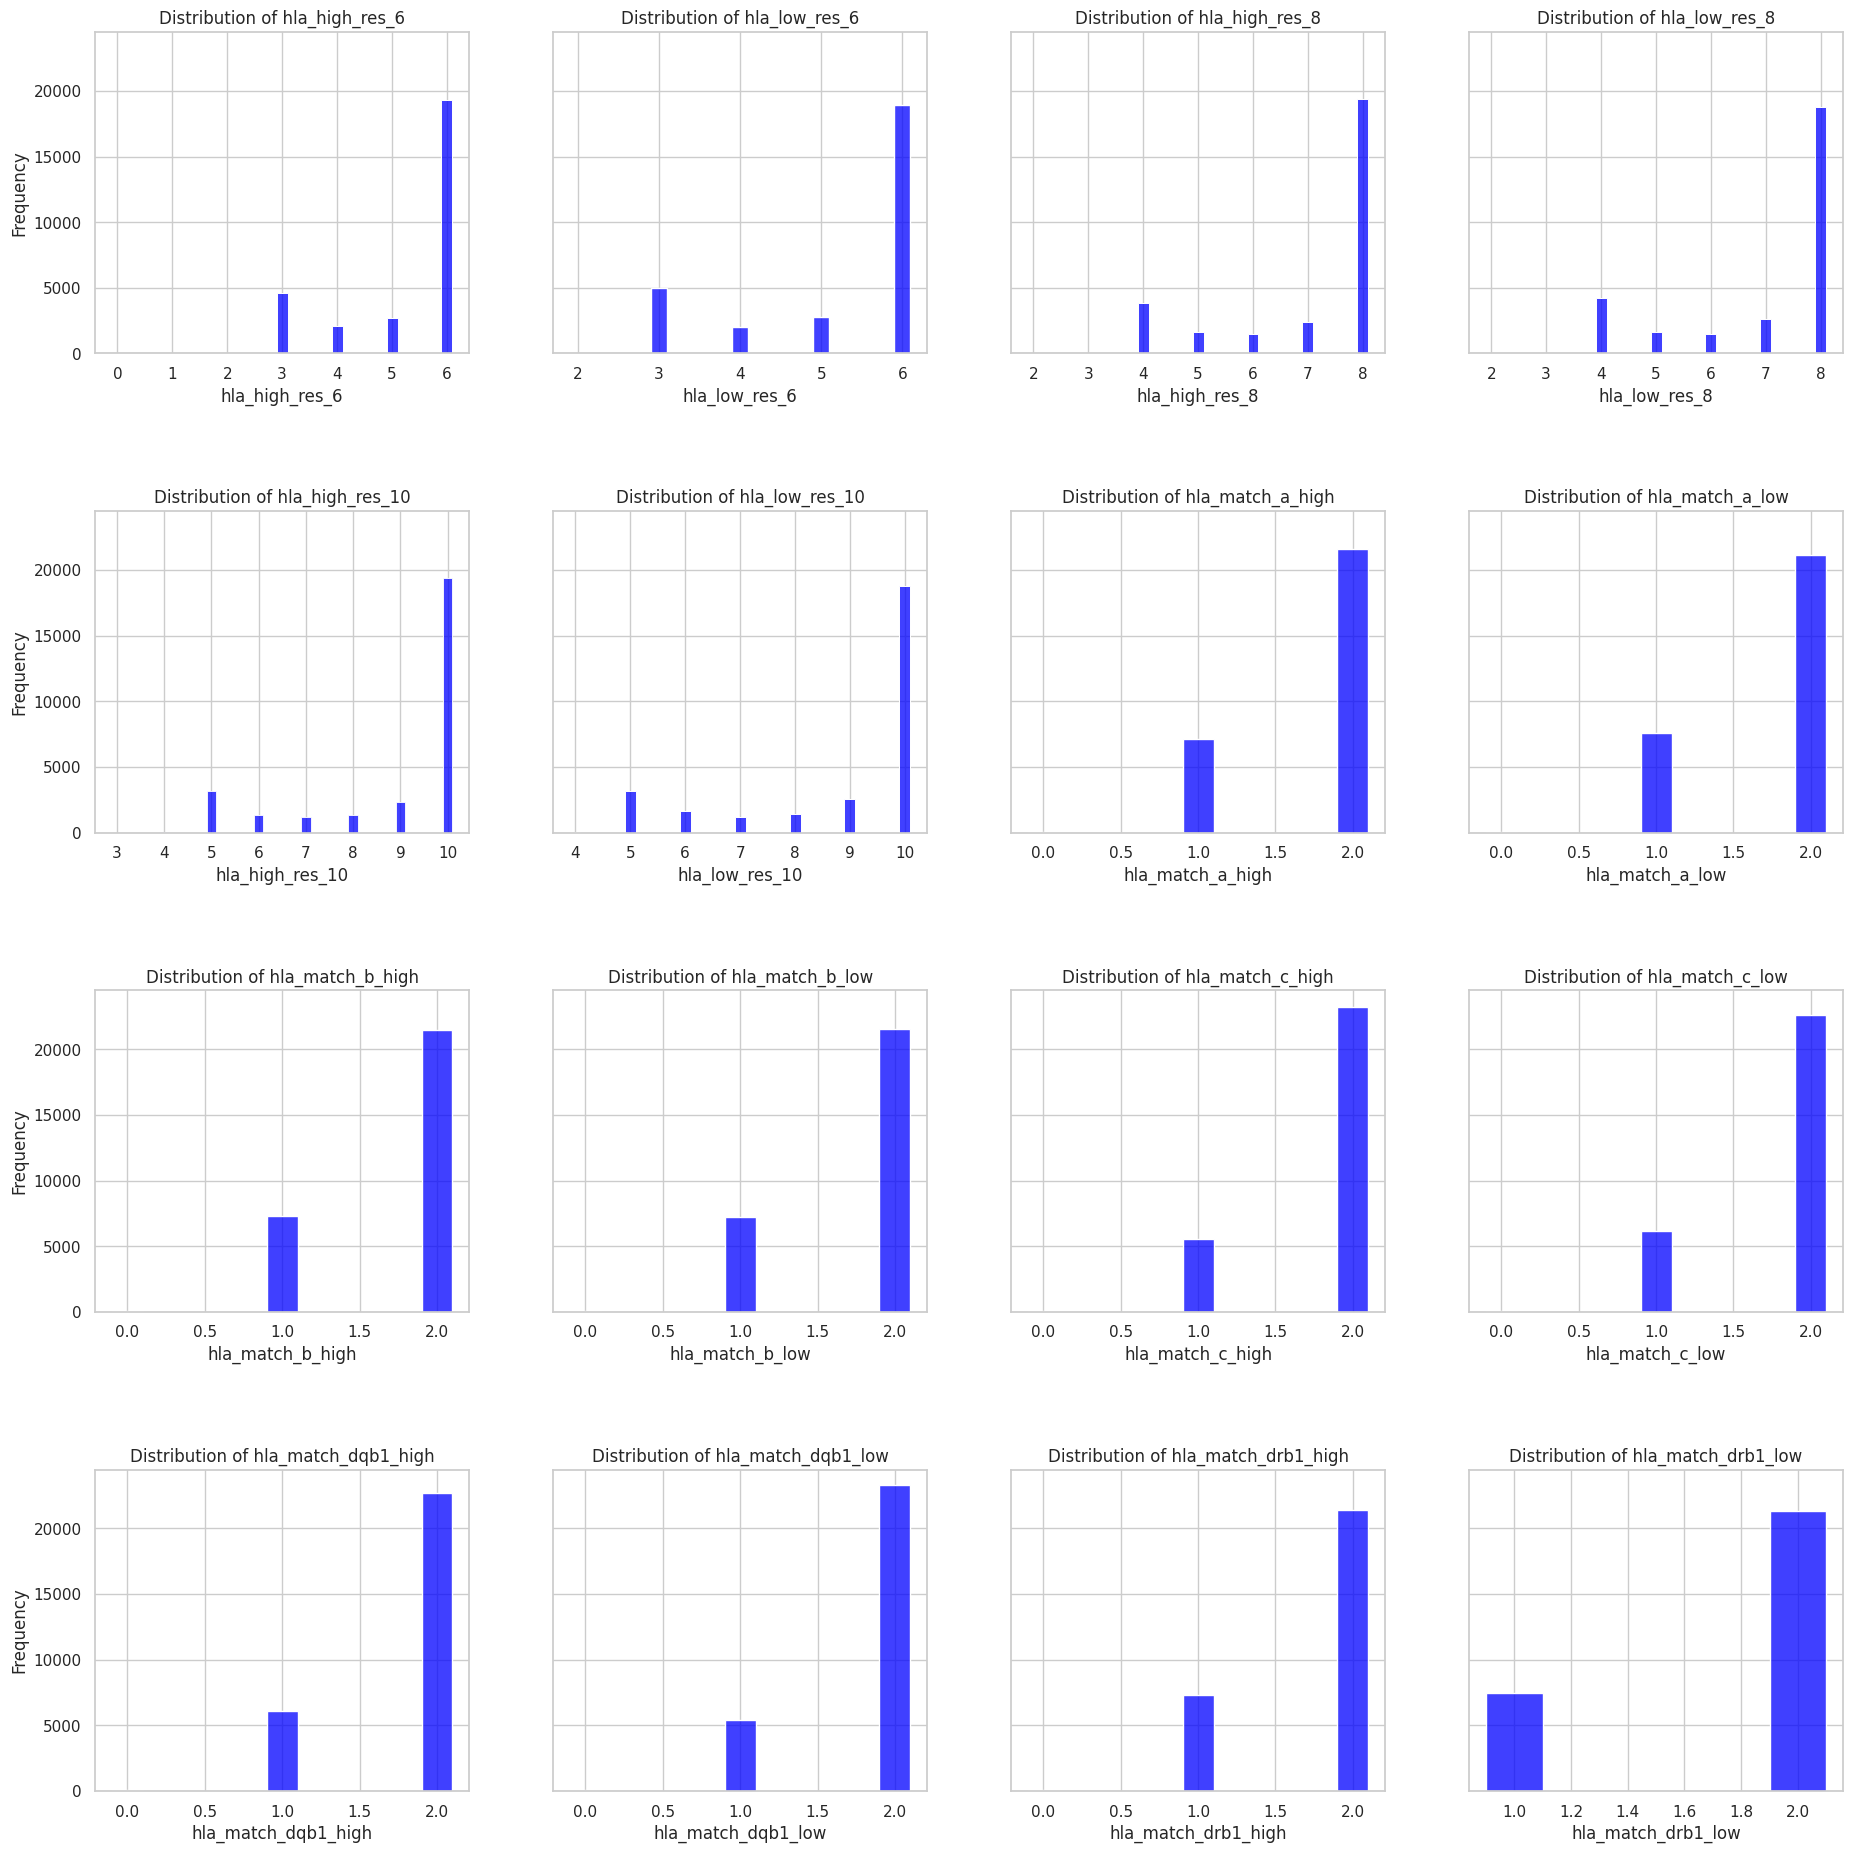

In [10]:
plot_histograms(df=df_hla_match_vars, rows = 4, cols= 4, shrink=0.2, share_y=True)

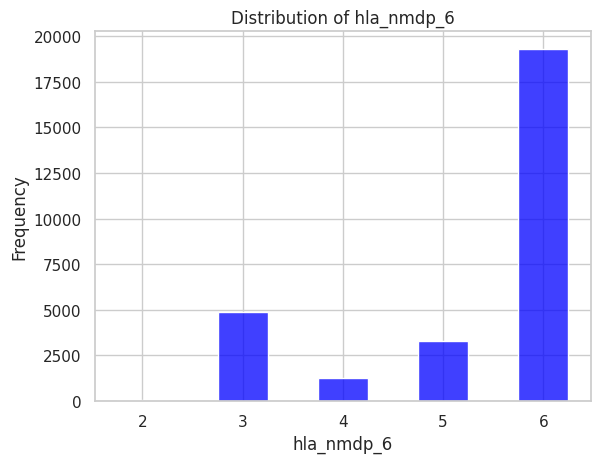

In [11]:
plot_histogram(df=hla_nmdp_6, var="hla_nmdp_6", shrink=0.5)

In [12]:
df_separated["num_hla"] = pd.concat([df_hla_match_vars, hla_nmdp_6], axis=1)

In [13]:
def show_correlation_matrix(df_num, vars):
  corr_matrix = df_num[vars].corr()
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
  plt.figure(figsize=(16, 16))
  sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidth=0.5, linecolor="black")
  plt.xticks(rotation=45)
  plt.title("Correlation matrix")
  plt.show()

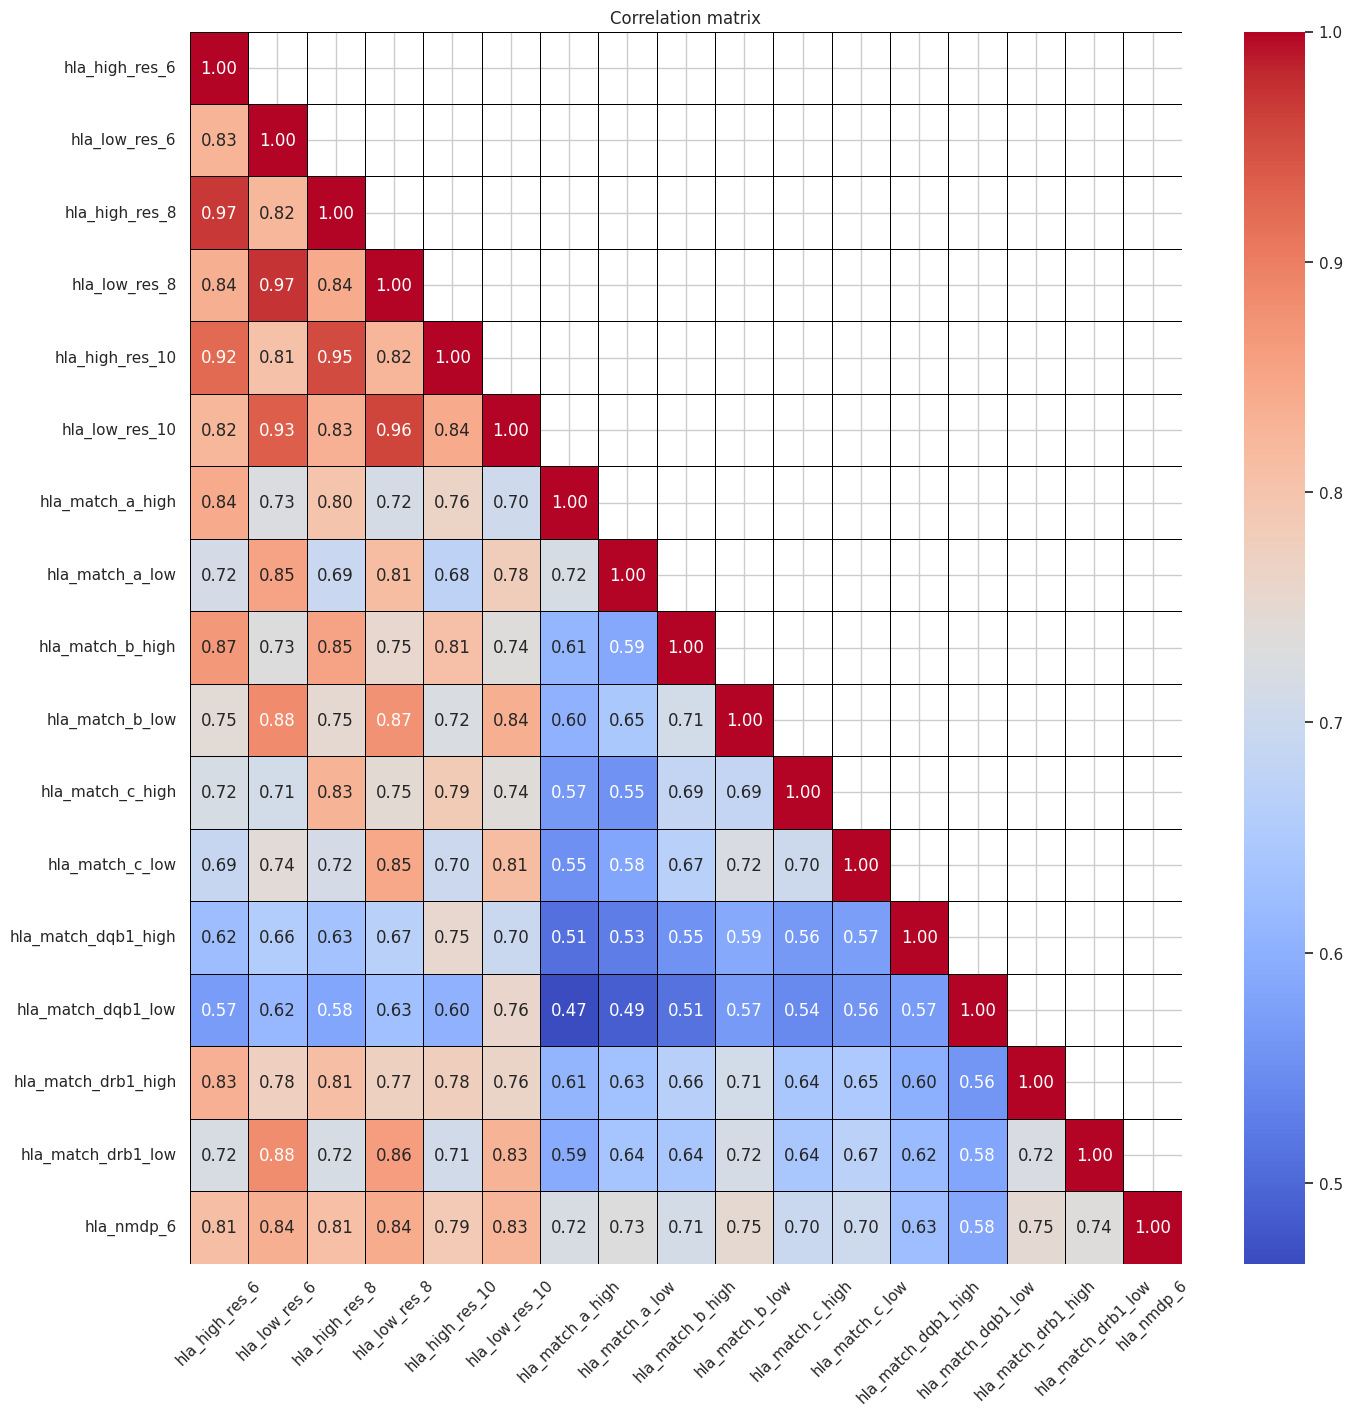

In [16]:
show_correlation_matrix(df_num = df_separated["num_hla"], vars = df_separated["num_hla"].columns)

Based on histograms and correlation matrix for HLA variables I have decided to create a ratio between hla_high and hla_low corresponding values as they are discrete. As some of values in denominator were zeros, in order to avoid going to infinity for combined_param, I have replaced output of calculated combined_param with max value for numerator.

In [17]:
def df_hla_ratios(df_num_hla):
    df = df_num_hla.copy()
    new_hla_params = []
    for col in df.columns:
      if 'high' in col:
          low_col = col.replace('high', 'low')
          if low_col in df.columns:
              high = df[col].fillna(0)
              low = df[low_col].fillna(0)

              combined_param = np.where(
                  (high == 0) & (low == 0),
                  0,
                  np.where(low == 0, high.max(), (high / low).round(2))
              )
              combined_param = pd.Series(combined_param, index=df.index, name=f"{col}_low_ratio")
              new_hla_params.append(combined_param)
    df_hla_params = pd.DataFrame(new_hla_params).T
    df_hla_params["hla_nmdp_6"] = df["hla_nmdp_6"]
    return df_hla_params

df_separated["num_hla"] = df_hla_ratios(df_num_hla = df_separated["num_hla"])
df_separated["num_non_hla"] = x_train[df_separated["num_non_hla"]]
df_separated["cat"] = x_train[df_separated["cat"]]

In [18]:
hla_match_vars = [var for var in df_separated["num_hla"].columns if "match" in var]

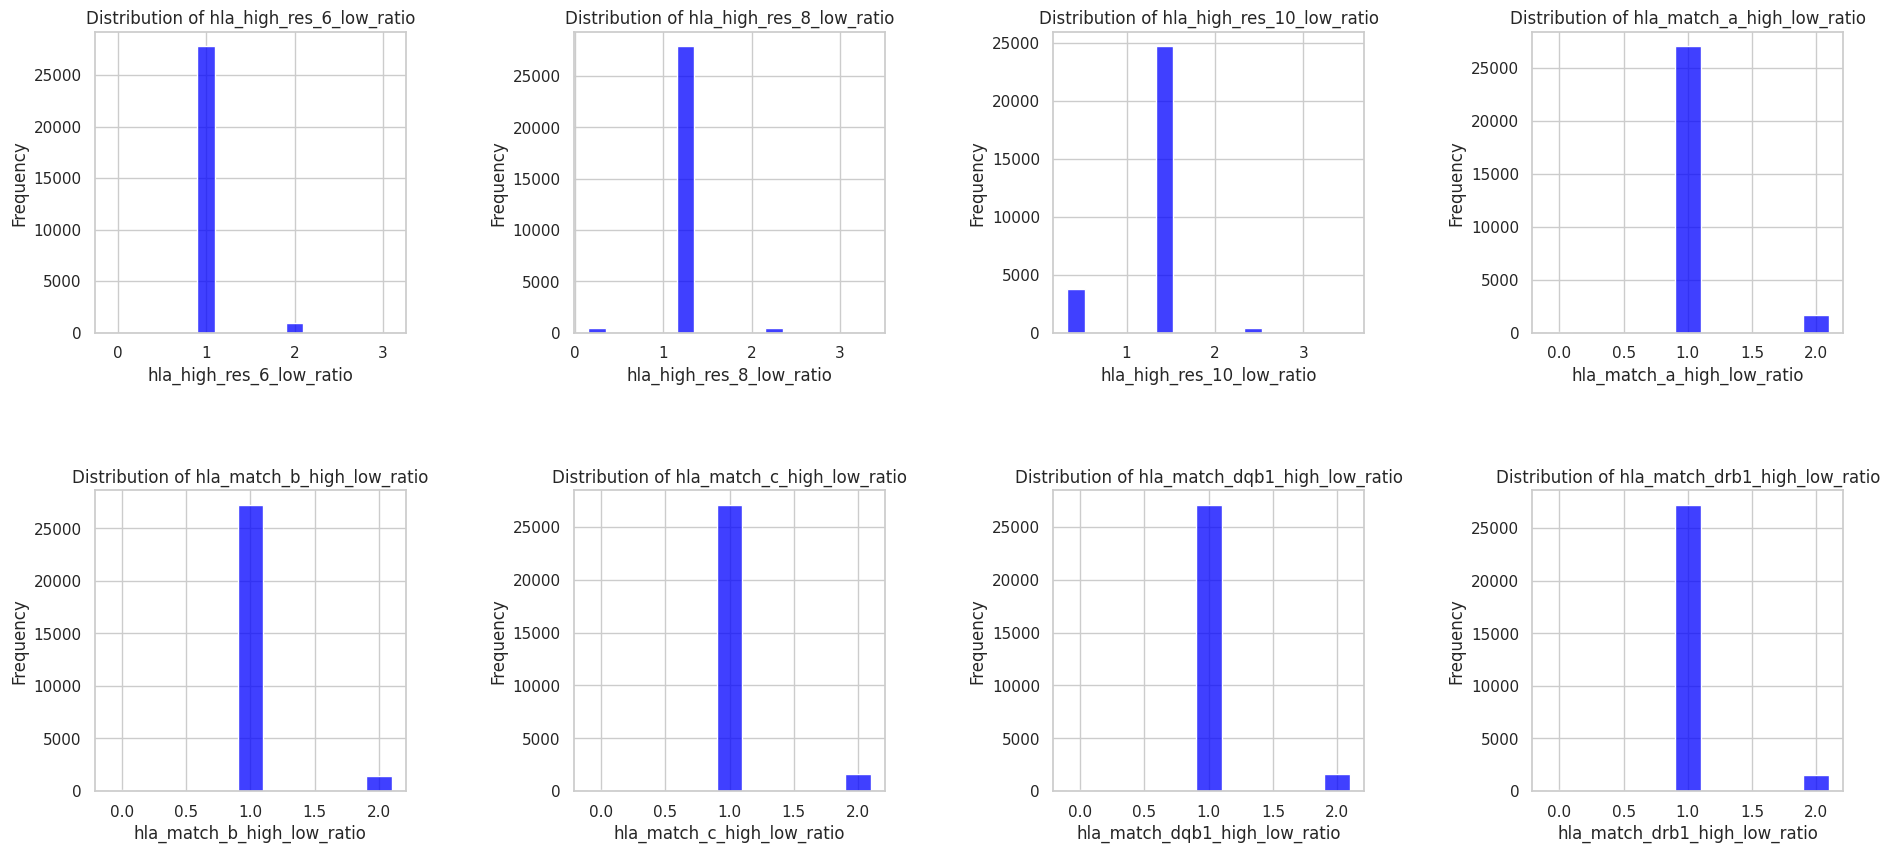

In [19]:
plot_histograms(df=df_separated["num_hla"], rows=2, cols=4, shrink=0.2)

In [20]:
def print_nans(df):
  for var in df.columns:
    no_of_nans = df[var].isnull().sum()
    print(f"NaNs of {var}: {no_of_nans}")

print_nans(df = df_separated["num_non_hla"])

NaNs of year_hct: 0
NaNs of donor_age: 1808
NaNs of age_at_hct: 0
NaNs of comorbidity_score: 477
NaNs of karnofsky_score: 870


Too many missing donor_age values won't be replaced with mode. Instead we will try to predict their values later on using imputer.

In [21]:
non_hla_vars = ['year_hct', 'age_at_hct', 'karnofsky_score', 'comorbidity_score']
replace_with_mode(df=df_separated["num_non_hla"], vars=non_hla_vars)

In [22]:
print_nans(df = df_separated["num_non_hla"])

NaNs of year_hct: 0
NaNs of donor_age: 1808
NaNs of age_at_hct: 0
NaNs of comorbidity_score: 0
NaNs of karnofsky_score: 0


In [23]:
def plot_compare(df, var, shrink=1):
  before = original[[var]]
  after = df[[var]]

  scores = pd.DataFrame({
    "Before": before[var].values,
    "After": after[var].values
  }, index=df.index).reset_index(drop=True)

  melted = scores.melt(var_name="Status", value_name=var)

  plt.figure(figsize=(10, 5))
  sns.histplot(data=melted, x=var, hue="Status", binwidth=0.9, palette={"Before": "blue", "After": "red"}, shrink=shrink, multiple='layer')
  plt.title(f"{var} Distribution Before & After Imputation")
  plt.xlabel(f"{var}")
  plt.ylabel("Count")
  plt.show()

Karnofsky_score recalculation. Missing values were replaced with mode value.

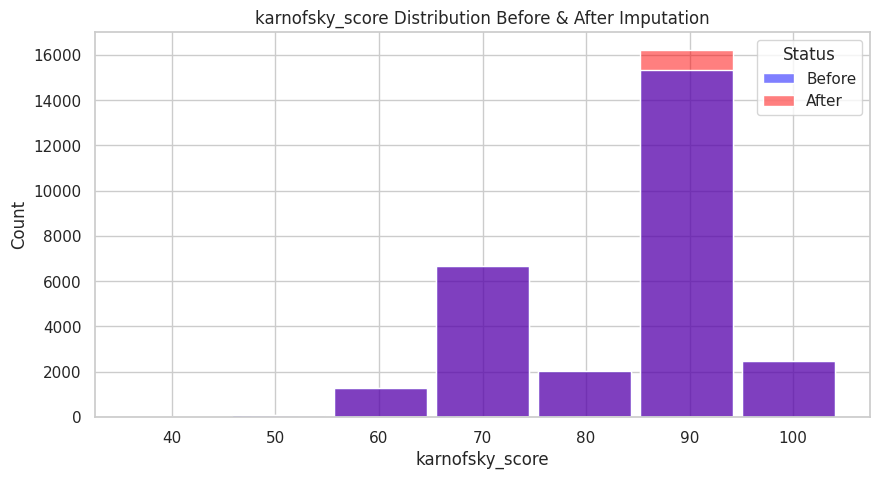

In [24]:
plot_compare(df=df_separated["num_non_hla"], var="karnofsky_score", shrink=10)

Comorbidity_score recalculation. Missing values were replaced with mode value.

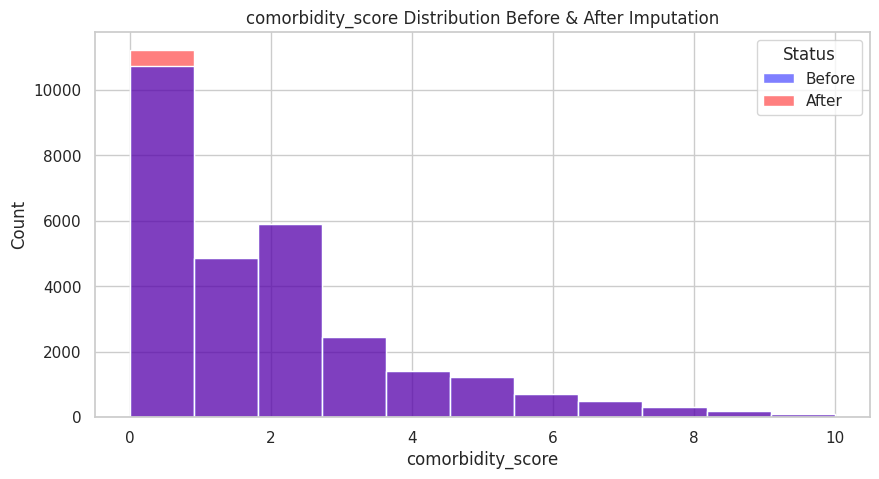

In [25]:
plot_compare(df=df_separated["num_non_hla"], var="comorbidity_score", shrink=1)

No recalculation was needed as there was no missing value for year_hct.

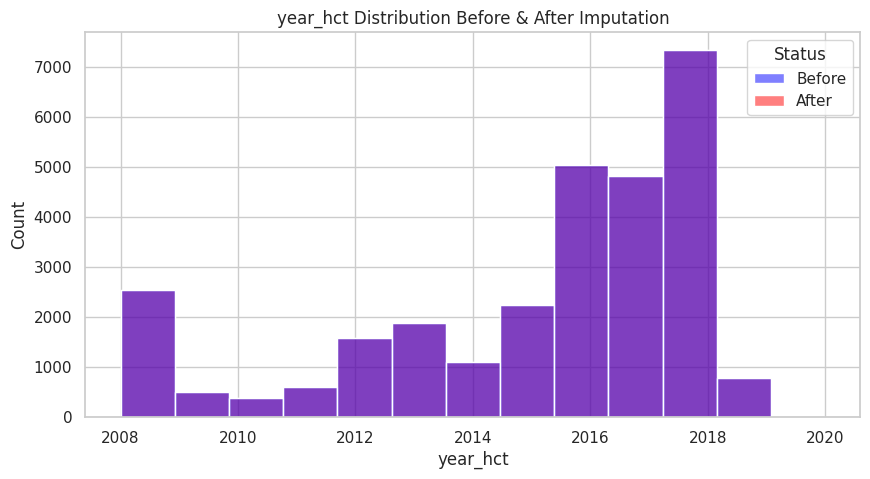

In [26]:
plot_compare(df=df_separated["num_non_hla"], var="year_hct", shrink=1)

No recalculation was needed as there was no missing value for age_at_hct.

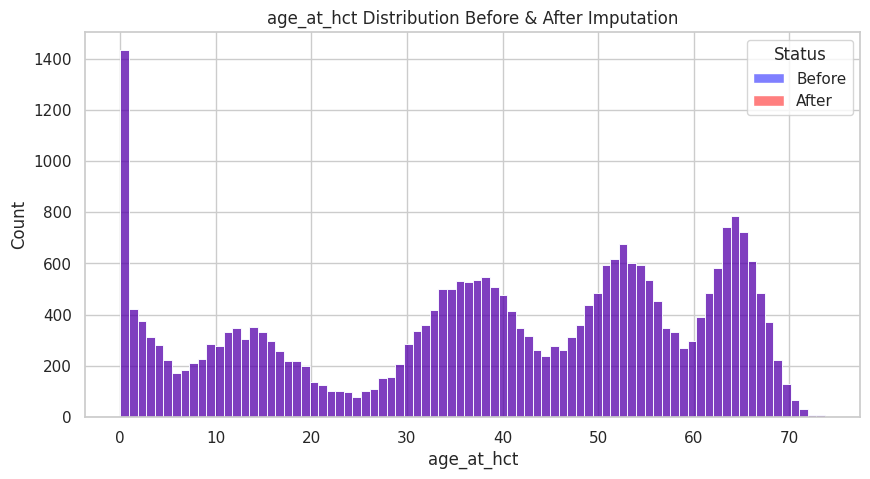

In [27]:
plot_compare(df=df_separated["num_non_hla"], var="age_at_hct", shrink=1)

In [28]:
df_separated["num_non_hla"]["age_at_hct"].value_counts().sort_values(ascending=False).head()

age_at_hct
0.044     1005
15.820       6
64.470       6
31.938       5
62.164       5
Name: count, dtype: int64

What is worth noticing that there is extremely unbeliveable that most of people within this sample had HCT at age of 0.044 (year) which means they were 16 days old.

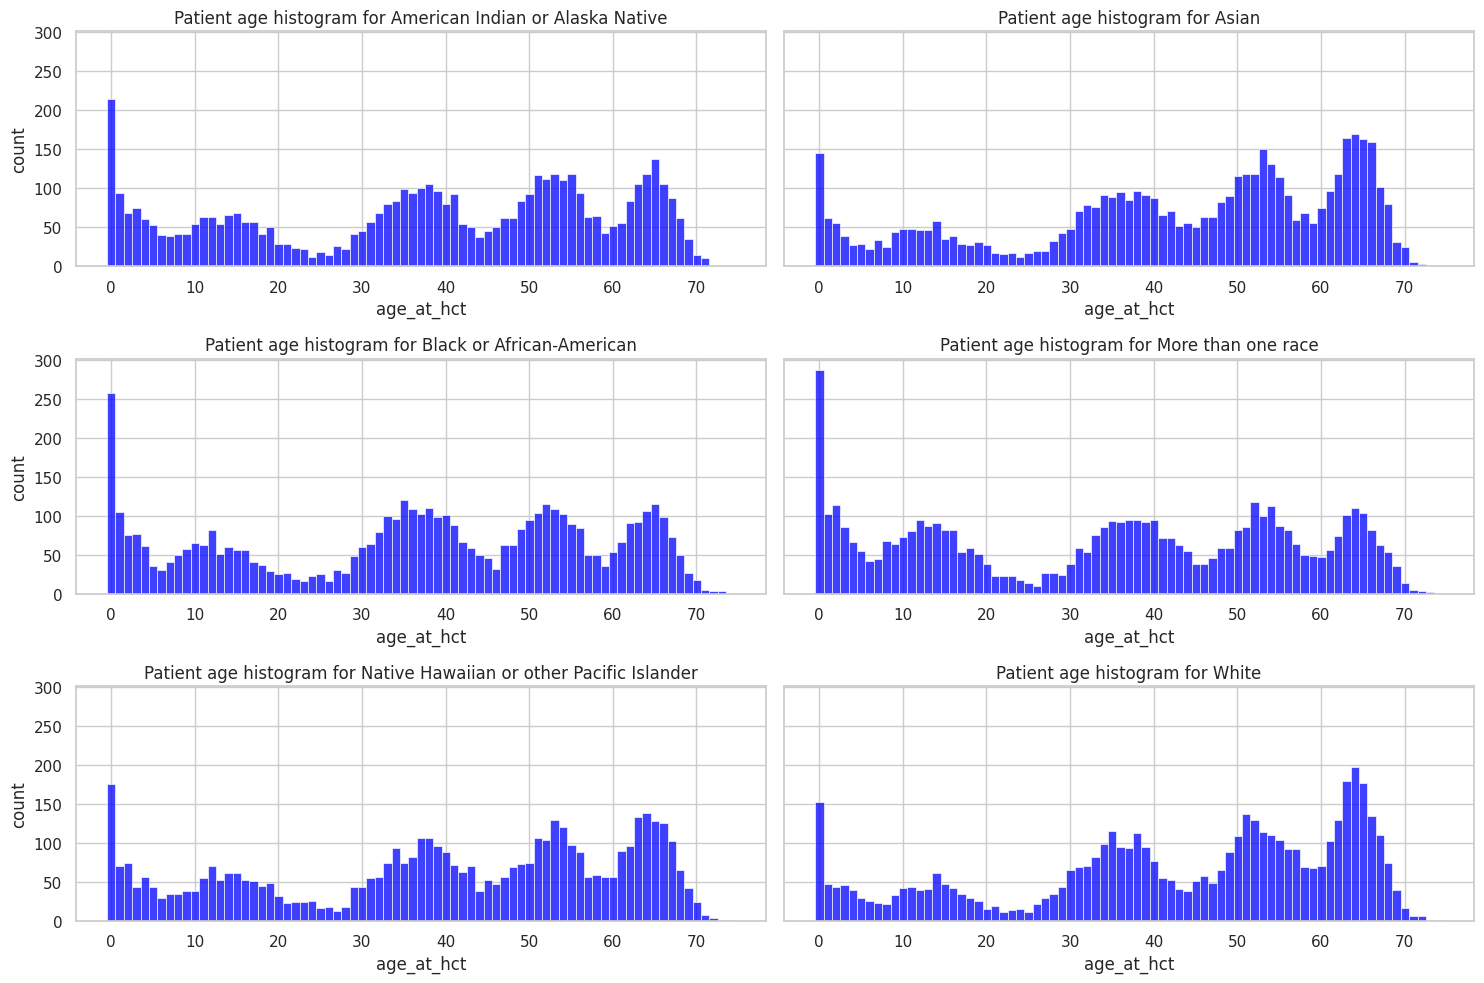

In [31]:
race_groups = df_separated['cat']['race_group'].sort_values().unique()
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(rows*5, cols*5), sharey=True)
axes = axes.flatten()
for i, col in enumerate(race_groups):
    subset = df_separated['num_non_hla'].loc[df_separated['cat']['race_group'] == col, 'age_at_hct']
    sns.histplot(subset, ax=axes[i], discrete=True, shrink=1, color='blue')
    axes[i].set_title(f'Patient age histogram for {col}')
    axes[i].set_xlabel('age_at_hct')
    axes[i].set_ylabel('count')
plt.tight_layout()
plt.show()

Additionally we can distinguish in every race group five modes. Distribution of patients that had HCT at ages indicated by these modes seem to be fairly unusual but not impossible. Two racial groups have higher mode at higher ages where older patients undergone HCT treatement: White and Asian.

I have decided to not drop observations with age_at_hct of 0.044 as it is the only one out of approx. 50 variables. It would be too aggressive to do that. However we could choose part of observations to preserve having this age and exclude the rest of them. For that I would pick the number of observations equal to mean observations of the whole dataset.

Merging numerical_non_hla_variables with cleaned_combined_hla in order to create df_cleaned_numerical. Note that donor_age is still missing some values and we want to evaluate using KNN algorithm to fill them with most probable outcomes.

In [32]:
df_cleaned_num = pd.concat([df_separated["num_hla"], df_separated["num_non_hla"]], axis=1)
df_cleaned_num.describe(include="all").T

count         mean        std       min  \
hla_high_res_6_low_ratio       28800.0     1.020097   0.181300     0.000   
hla_high_res_8_low_ratio       28800.0     1.021708   0.170054     0.250   
hla_high_res_10_low_ratio      28800.0     1.017601   0.160251     0.430   
hla_match_a_high_low_ratio     28800.0     1.035486   0.263609     0.000   
hla_match_b_high_low_ratio     28800.0     1.022812   0.255432     0.000   
hla_match_c_high_low_ratio     28800.0     1.037049   0.256007     0.000   
hla_match_dqb1_high_low_ratio  28800.0     1.015191   0.277400     0.000   
hla_match_drb1_high_low_ratio  28800.0     1.025469   0.256352     0.000   
hla_nmdp_6                     28800.0     5.282708   1.150898     2.000   
year_hct                       28800.0  2015.179444   3.153914  2008.000   
donor_age                      26992.0    42.511591  15.251434    18.010   
age_at_hct                     28800.0    38.663162  21.147581     0.044   
comorbidity_score              28800.0     1.674132   1.989754     0.000   
karnofsky_score                28800.0    84.018403  10.912164    40.000   

                                    25%       50%         75%       max  
hla_high_res_6_low_ratio          1.000     1.000     1.00000     3.000  
hla_high_res_8_low_ratio          1.000     1.000     1.00000     2.670  
hla_high_res_10_low_ratio         1.000     1.000     1.00000     2.500  
hla_match_a_high_low_ratio        1.000     1.000     1.00000     2.000  
hla_match_b_high_low_ratio        1.000     1.000     1.00000     2.000  
hla_match_c_high_low_ratio        1.000     1.000     1.00000     2.000  
hla_match_dqb1_high_low_ratio     1.000     1.000     1.00000     2.000  
hla_match_drb1_high_low_ratio     1.000     1.000     1.00000     2.000  
hla_nmdp_6                        5.000     6.000     6.00000     6.000  
year_hct                       2013.000  2016.000  2018.00000  2020.000  
donor_age                        28.447    40.063    56.13150    84.800  
age_at_hct                       19.539    41.006    55.96525    73.726  
comorbidity_score                 0.000     1.000     2.00000    10.000  
karnofsky_score                  70.000    90.000    90.00000   100.000

In [33]:
print_nans(df = df_separated["cat"])

NaNs of dri_score: 154
NaNs of psych_disturb: 2062
NaNs of cyto_score: 8068
NaNs of diabetes: 2119
NaNs of tbi_status: 0
NaNs of arrhythmia: 2202
NaNs of graft_type: 0
NaNs of vent_hist: 259
NaNs of renal_issue: 1915
NaNs of pulm_severe: 2135
NaNs of prim_disease_hct: 0
NaNs of cmv_status: 634
NaNs of tce_imm_match: 11133
NaNs of rituximab: 2148
NaNs of prod_type: 0
NaNs of cyto_score_detail: 11923
NaNs of conditioning_intensity: 4789
NaNs of ethnicity: 587
NaNs of obesity: 1760
NaNs of mrd_hct: 16597
NaNs of in_vivo_tcd: 225
NaNs of tce_match: 18996
NaNs of hepatic_severe: 1871
NaNs of prior_tumor: 1678
NaNs of peptic_ulcer: 2419
NaNs of gvhd_proph: 225
NaNs of rheum_issue: 2183
NaNs of sex_match: 261
NaNs of race_group: 0
NaNs of hepatic_mild: 1917
NaNs of tce_div_match: 11396
NaNs of donor_related: 158
NaNs of melphalan_dose: 1405
NaNs of cardiac: 2542
NaNs of pulm_moderate: 2047


In [34]:
def replace_with_unknown(df_cat):
  """Replaces missing values in categorical DataFrame with 'Unknown'"""
  for var in df_cat.columns:
    df_cat.loc[:, var] = df_cat[var].fillna("Unknown")

replace_with_unknown(df_cat=df_separated["cat"])

In [35]:
print_nans(df = df_separated["cat"])

NaNs of dri_score: 0
NaNs of psych_disturb: 0
NaNs of cyto_score: 0
NaNs of diabetes: 0
NaNs of tbi_status: 0
NaNs of arrhythmia: 0
NaNs of graft_type: 0
NaNs of vent_hist: 0
NaNs of renal_issue: 0
NaNs of pulm_severe: 0
NaNs of prim_disease_hct: 0
NaNs of cmv_status: 0
NaNs of tce_imm_match: 0
NaNs of rituximab: 0
NaNs of prod_type: 0
NaNs of cyto_score_detail: 0
NaNs of conditioning_intensity: 0
NaNs of ethnicity: 0
NaNs of obesity: 0
NaNs of mrd_hct: 0
NaNs of in_vivo_tcd: 0
NaNs of tce_match: 0
NaNs of hepatic_severe: 0
NaNs of prior_tumor: 0
NaNs of peptic_ulcer: 0
NaNs of gvhd_proph: 0
NaNs of rheum_issue: 0
NaNs of sex_match: 0
NaNs of race_group: 0
NaNs of hepatic_mild: 0
NaNs of tce_div_match: 0
NaNs of donor_related: 0
NaNs of melphalan_dose: 0
NaNs of cardiac: 0
NaNs of pulm_moderate: 0


Functions defined and stored in group_mappings_url will redeclare values in significantly dispersed or missing categorical features of training dataset.

In [36]:
def apply_categorical_mapping(df_cat):
  """Applies categorical mapping.
  DataFrame of categorical variables should be passed."""
  group_mappings_url = "https://raw.githubusercontent.com/micjedzierowski/Equity-post-HCT-survival-predictions/main/group_mappings.json"
  response = requests.get(group_mappings_url)
  group_mappings = json.loads(response.text)
  df = df_cat.copy()
  for _ in group_mappings:
    var = _['name']
    mapping = _['group_mapping']
    remaped = df[var].map(mapping).fillna("Uncertain")
    df[var] = remaped
  return df

df_cleaned_cat = apply_categorical_mapping(df_cat = df_separated["cat"])
df_cleaned_cat.describe().T, df_cleaned_cat.shape

(                        count unique                     top   freq
 dri_score               28800      5               Uncertain  11539
 psych_disturb           28800      3                      No  23005
 cyto_score              28800      5               Uncertain   9968
 diabetes                28800      3                      No  22201
 tbi_status              28800      5               Uncertain  18937
 arrhythmia              28800      3                      No  25203
 graft_type              28800      2        Peripheral blood  20546
 vent_hist               28800      3                      No  27721
 renal_issue             28800      3                      No  26548
 pulm_severe             28800      3                      No  24779
 prim_disease_hct        28800     10         Acute Leukemias  15320
 cmv_status              28800      5                     +/+  13596
 tce_imm_match           28800      4                 P-Match  13288
 rituximab               28800    

For categorical variables, especially from medical field, it is necessary to conduct statistical test of significance. Below is an example of chi-square test for two given variables: donor_related and melphalan_dose. First of all we need to create a table of contingency that shows how often values of both variables exist in our dataset.

**Chi-square test tells us if there is significant association between variables however we don't know how strong or weak it is.**

In general for this pair and all pairs of variables we are going to make hypotheses as following:

H0 - there is no association between two variables, they are independent on each other,

H1 -  there is association between two variables, they are dependent on each other.

For alpha a = 0.05 and P-value p, where p <= a, we conclude that there is a statistically significant association between donor_related and melphalan_dose.

In the other hand if p > a, we conclude that there is no evidence of a significant association between donor_related and melphalan_dose.

In [37]:
contingency_table = pd.crosstab(df_cleaned_cat['donor_related'], df_cleaned_cat['melphalan_dose'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2.round(2)}")
print(f"P-value: {p.round(2)}")
print(f"Degrees of Freedom: {dof}")

expected_df = pd.DataFrame(np.int32(expected), index=["Other", "Related", "Unrelated"], columns=["MEL", "MEL not given"])

Chi2 Statistic: 20.76
P-value: 0.0
Degrees of Freedom: 2


An example heatmap for contingency table of donor_related and melphalan_dose and expected values.

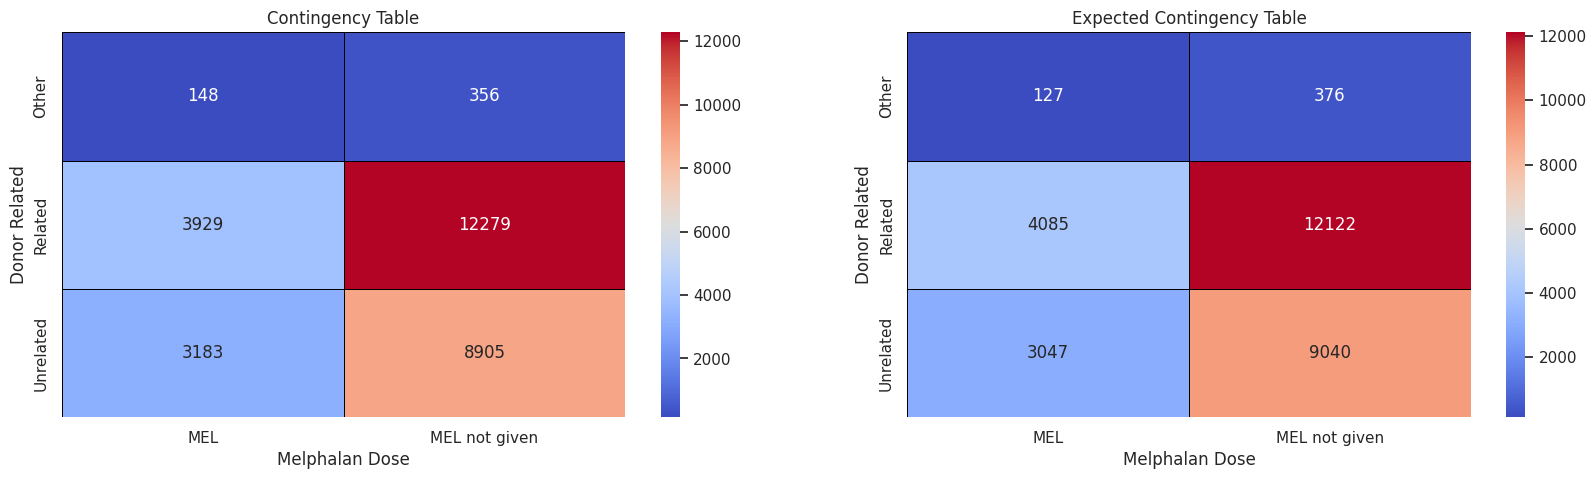

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for i, frame in enumerate([contingency_table, expected_df]):
    ax = axes[i]
    sns.heatmap(frame, annot=True, fmt='d', cmap='coolwarm', ax=ax, linewidths=0.5, linecolor="black")
    if i == 0:
        ax.set_title("Contingency Table")
    else:
        ax.set_title("Expected Contingency Table")
    ax.set_xlabel("Melphalan Dose")
    ax.set_ylabel("Donor Related")
plt.show()

From the chi-square test for donor_related and melphalan_dose we can observe that p ~ 0.0 which is below a = 0.05 treshold that tells us **there is significant association** between two of them.

In [39]:
def calculate_chi_square_matrix(df, cat_vars):
    results = pd.DataFrame(index=cat_vars, columns=cat_vars)

    for var1 in cat_vars:
        for var2 in cat_vars:
            if var1 == var2:
                results.loc[var1, var2] = 1.0
            else:
                contingency_table = pd.crosstab(df[var1], df[var2])
                chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
                results.loc[var1, var2] = p

    return results.astype(float).round(3)

chi_sqr_matrix = calculate_chi_square_matrix(df=df_cleaned_cat, cat_vars=df_cleaned_cat.columns)

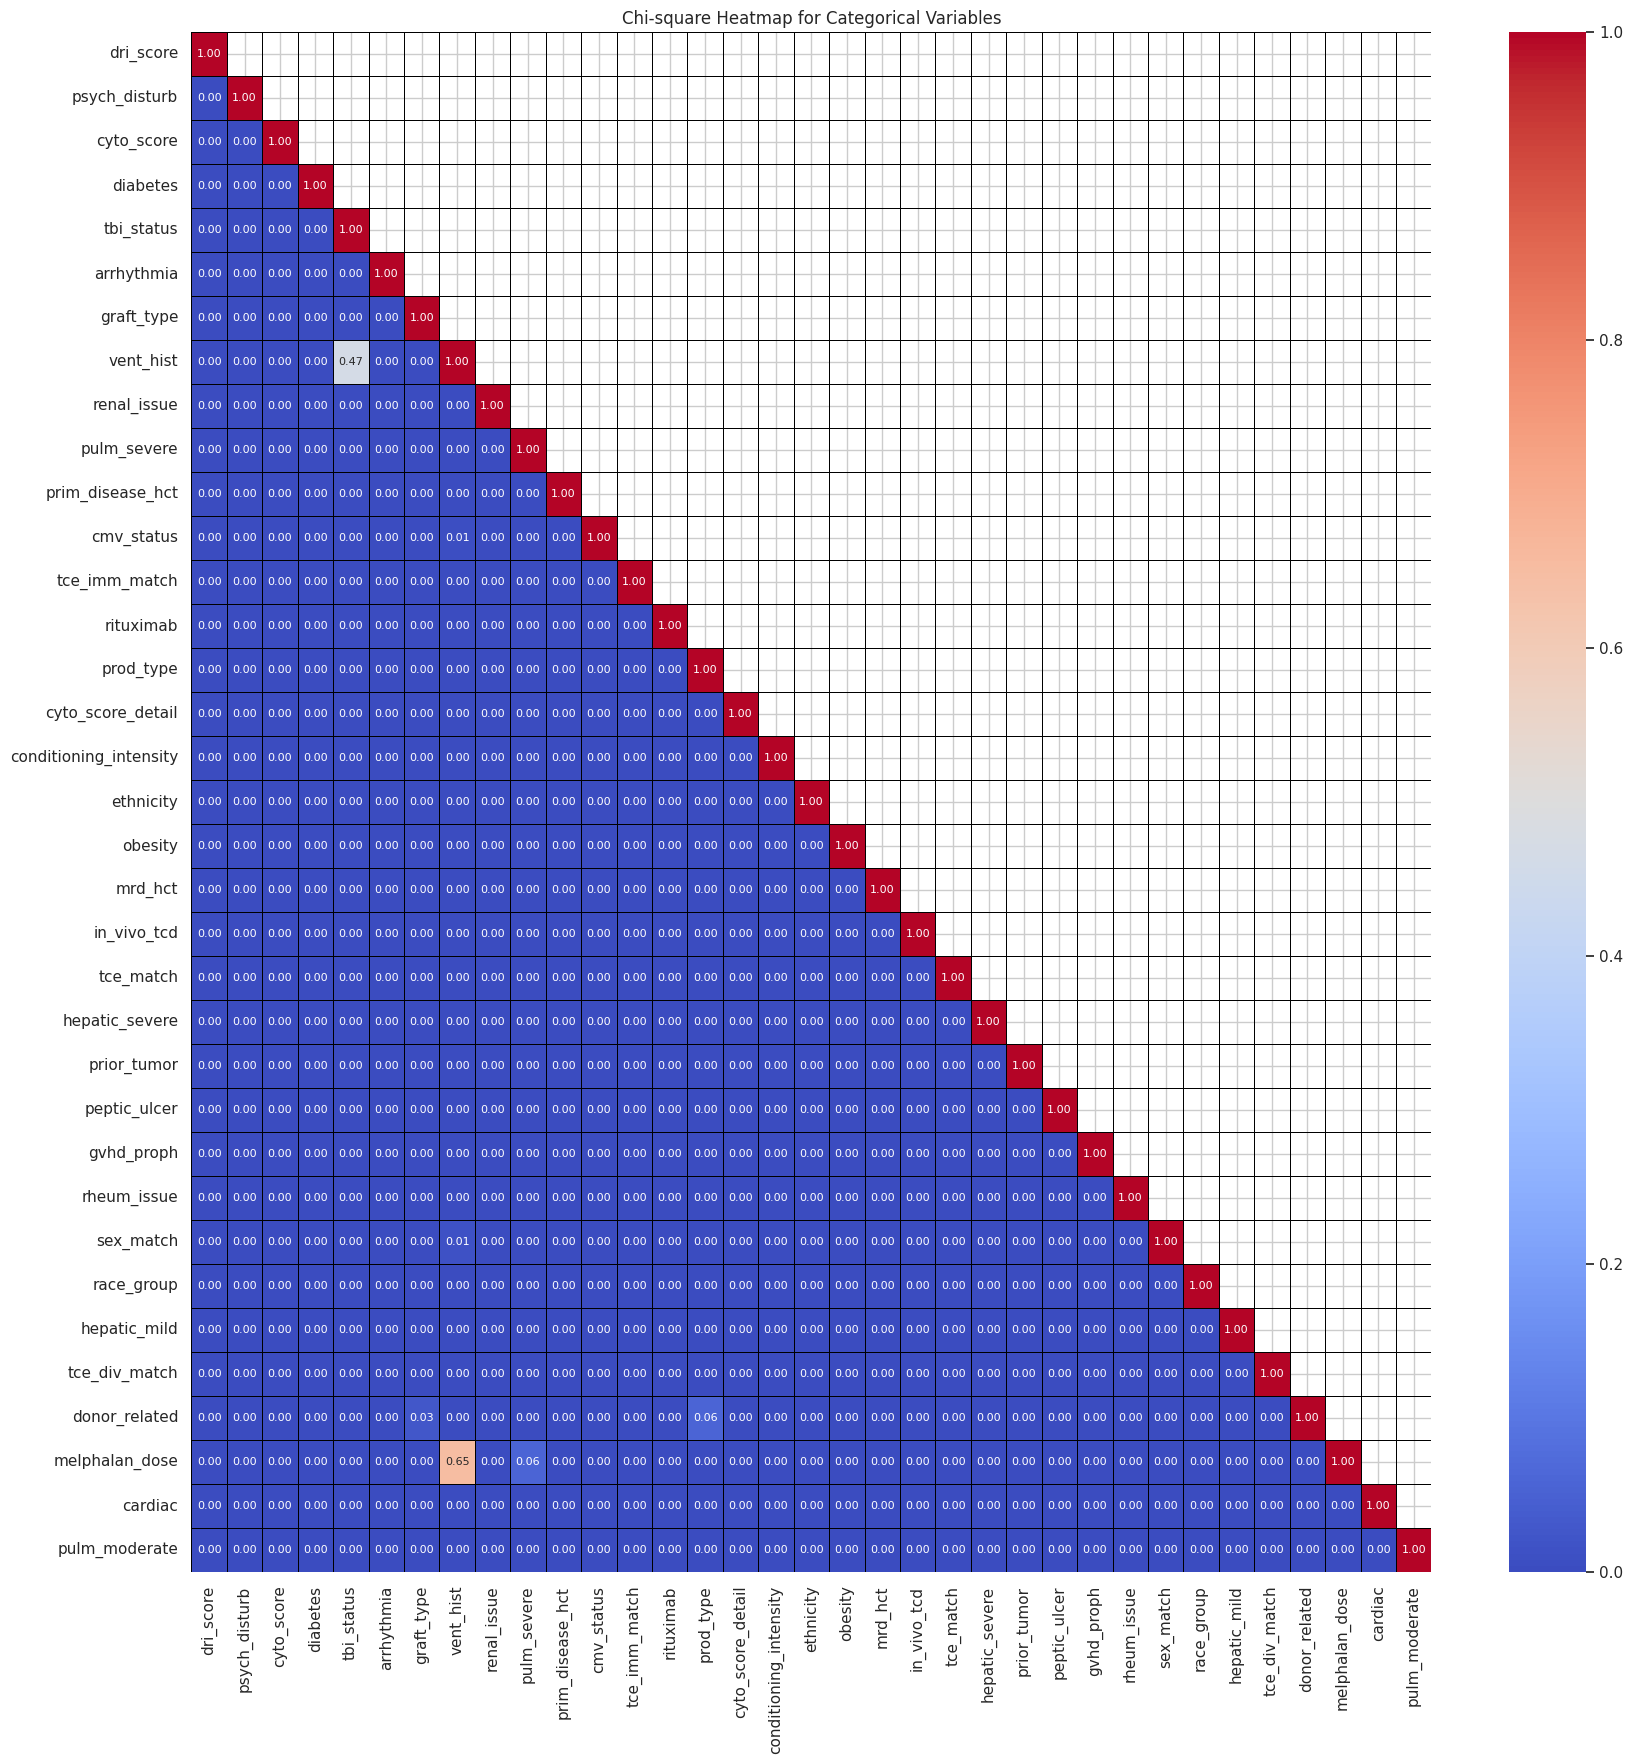

In [40]:
mask = np.triu(np.ones_like(chi_sqr_matrix, dtype=bool), k=1)
plt.figure(figsize=(20, 20))
sns.heatmap(chi_sqr_matrix, mask=mask, annot=True, annot_kws={"fontsize": 8}, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor="black")
plt.title("Chi-square Heatmap for Categorical Variables")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

**Cramér's V measures the strength of association between two categorical variables. It focuses on effect's size.**

Results close to 0 indicate there is a weak or negligible association between variables, from the other hand results closer to 1 indicate there is strong association.

In [41]:
def cramers_v(df, variable_1, variable_2):
    contingency_table = pd.crosstab(df[variable_1], df[variable_2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    N = df_cleaned_cat.shape[0]
    k = min(contingency_table.shape)
    return np.sqrt(chi2 / (N * (k - 1)))

Calculating Cramer's V matrix for categorical variables in df_cleaned_categorical.

In [42]:
def calculate_cramers_v_matrix(df, cat_vars):
    results = pd.DataFrame(index=cat_vars, columns=cat_vars)
    for var1 in cat_vars:
        for var2 in cat_vars:
            if var1 == var2:
                results.loc[var1, var2] = 1.0
            else:
                results.loc[var1, var2] = cramers_v(df=df, variable_1=var1, variable_2=var2)

    return results.astype(float).round(3)

cramers_v_matrix = calculate_cramers_v_matrix(df=df_cleaned_cat, cat_vars=df_cleaned_cat.columns)

The Cramer's V heatmap highlights a strong association between certain variable pairs, notably graft_type & prod_typ (0.87) and tce_imm_match & tce_div_match (0.69). While we could consider removing one variable from each pair for dimensionality reduction, I have chosen to retain them for now. A definite threshold for dropping a variable would be 0.90, as this level of association suggests potential collinearity.

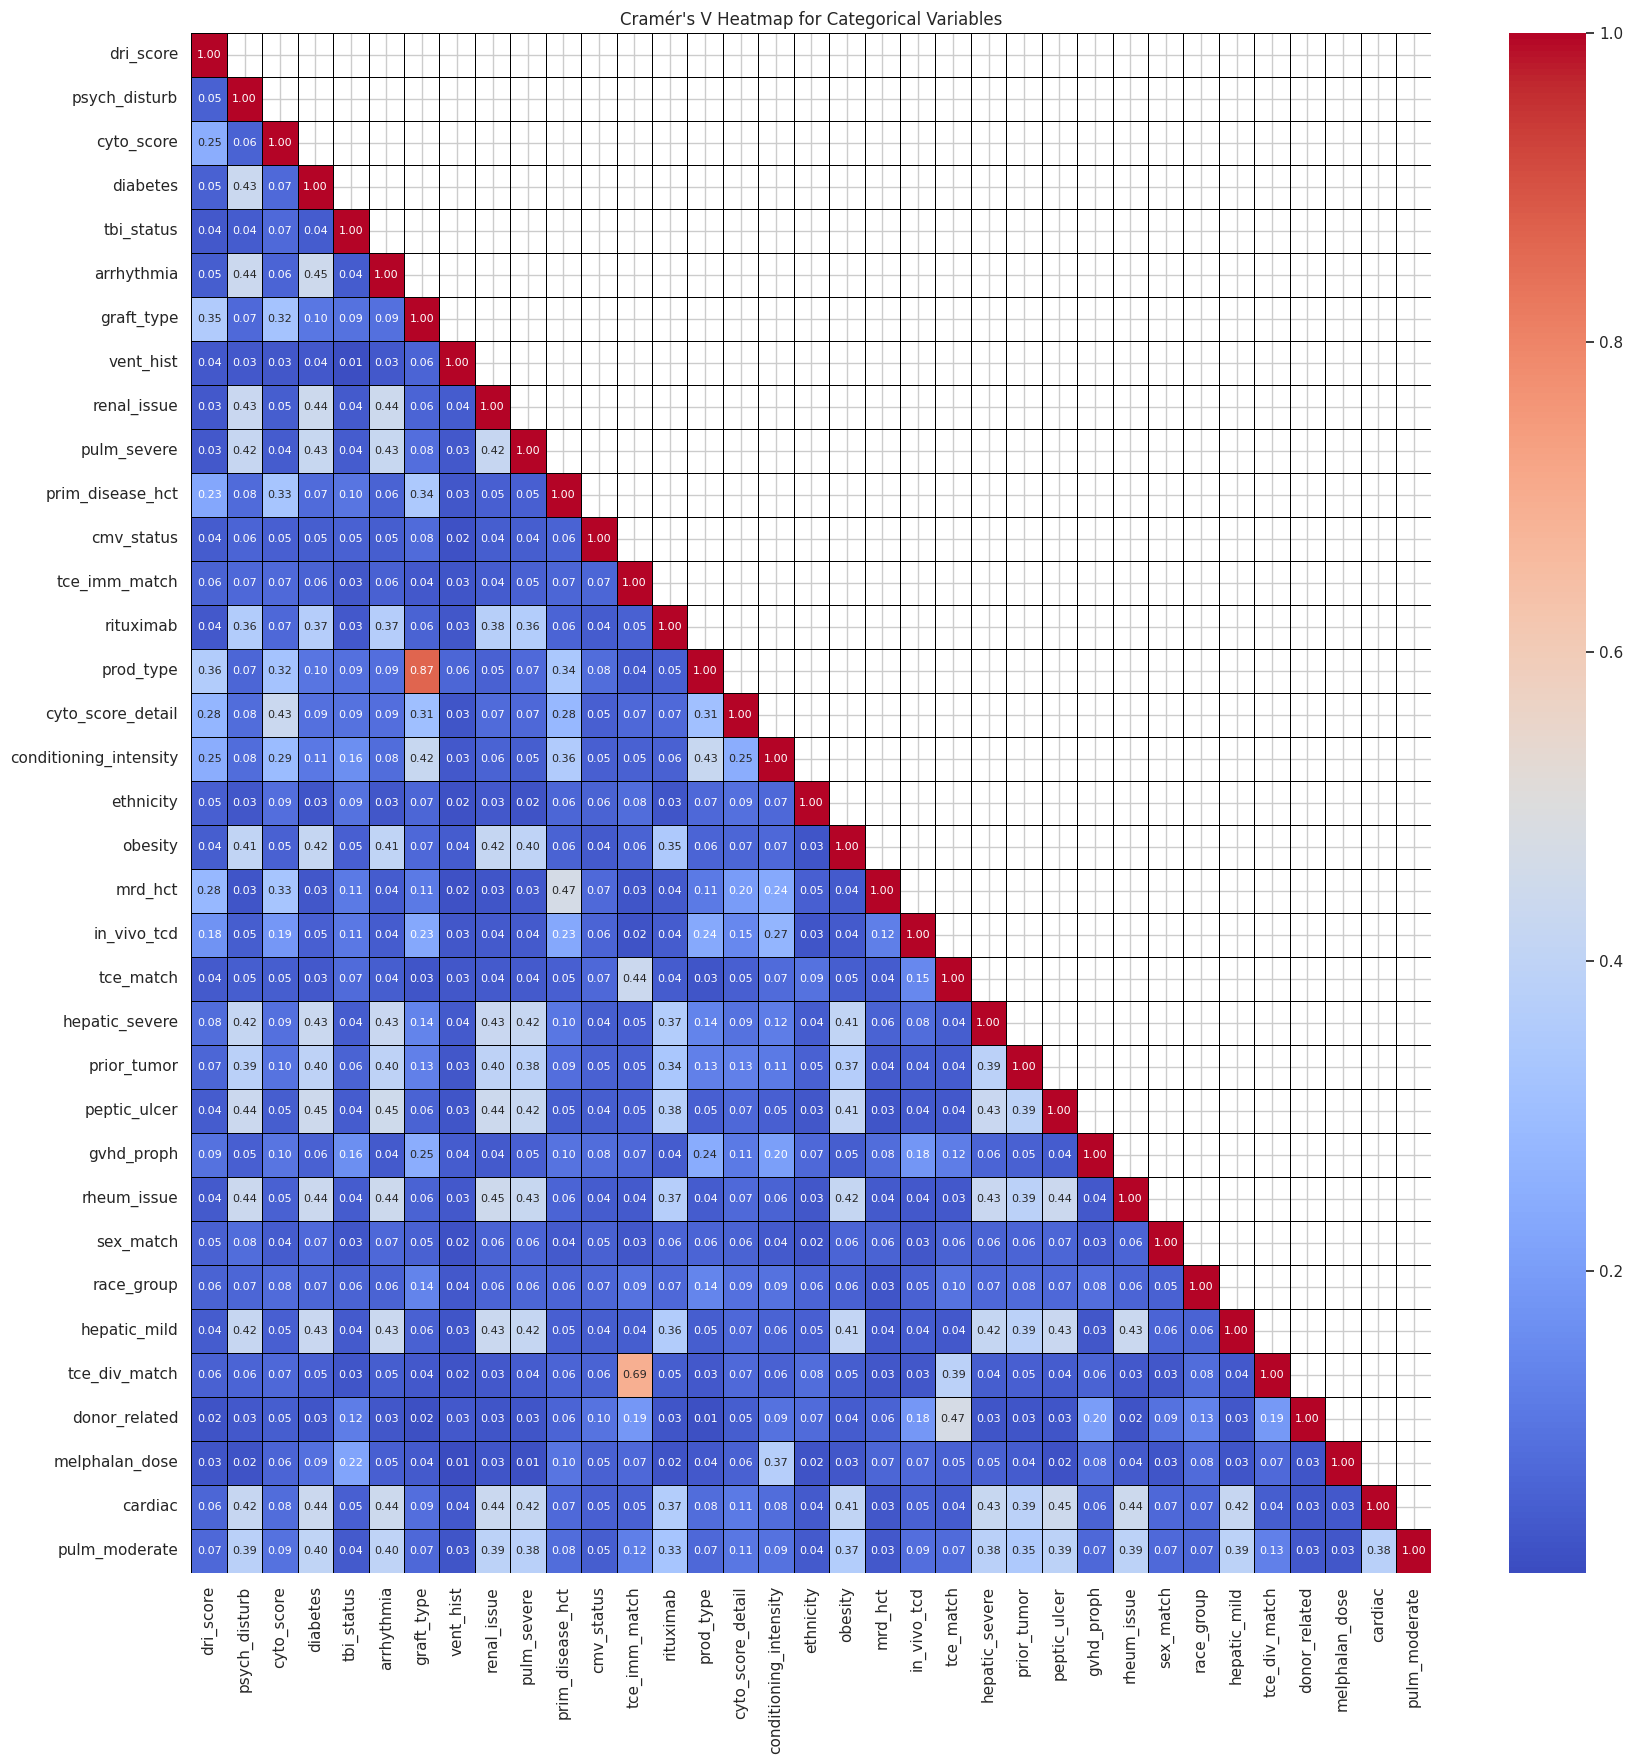

In [43]:
mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool), k=1)
plt.figure(figsize=(20, 20))
sns.heatmap(cramers_v_matrix, mask=mask, annot=True, annot_kws={"fontsize": 8}, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor="black")
plt.title("Cramér's V Heatmap for Categorical Variables")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Mapping for categorical and numerical variables. For categorical mapping weights of values frequencies will be stored. For numerical modes will be used.

In [44]:
def category_weight_mapping(df_cat):
    """Returns mapping of categorical variables"""
    mapping = {}
    for var in df_cat.columns:
        category_counts = df_cat[var].value_counts(normalize=True).round(3)
        mapping[var] = category_counts.to_dict()
    return mapping

cat_mapping = category_weight_mapping(df_cat = df_cleaned_cat)

{'dri_score': {'Uncertain': 0.401,
  'Intermediate': 0.362,
  'High': 0.163,
  'Low': 0.067,
  'Very high': 0.007},
 'psych_disturb': {'No': 0.799, 'Yes': 0.125, 'Uncertain': 0.077},
 'cyto_score': {'Uncertain': 0.346,
  'Poor': 0.306,
  'Intermediate': 0.221,
  'Favorable': 0.105,
  'Normal': 0.022},
 'diabetes': {'No': 0.771, 'Yes': 0.151, 'Uncertain': 0.078},
 'tbi_status': {'Uncertain': 0.658,
  'TBI + Cy': 0.212,
  'TBI <=cGy': 0.06,
  'TBI >cGy': 0.059,
  'TBI -cGy': 0.012},
 'arrhythmia': {'No': 0.875, 'Uncertain': 0.081, 'Yes': 0.044},
 'graft_type': {'Peripheral blood': 0.713, 'Bone marrow': 0.287},
 'vent_hist': {'No': 0.963, 'Yes': 0.028, 'Unknown': 0.009},
 'renal_issue': {'No': 0.922, 'Uncertain': 0.071, 'Yes': 0.007},
 'pulm_severe': {'No': 0.86, 'Uncertain': 0.08, 'Yes': 0.059},
 'prim_disease_hct': {'Acute Leukemias': 0.532,
  'Myelo Disorders': 0.163,
  'Infections or Disease Complications': 0.11,
  'Inherited or Immune Disorders': 0.056,
  'Lymphoma': 0.048,
  'Plasma

In [45]:
def numerical_mode_mapping(df_num):
    """Returns mapping of numerical variables.
    DataFrame of non HLA variables should be passed."""
    mapping = {}
    for var in df_num.columns:
        mode_value = df_num[var].mode()[0]
        mapping[var] = mode_value
    del mapping['donor_age']
    return mapping

num_mapping = numerical_mode_mapping(df_num = df_cleaned_num)

In [46]:
def apply_mode_mapping(df_num):
    """Applies mode mapping.
    Only numerical DataFrame should be passed."""
    df = df_num.copy()
    for var in num_mapping.keys():
      df[var] = df[var].fillna(num_mapping[var])
    return df

df_num_cleaned = apply_mode_mapping(df_num = df_cleaned_num)

In [47]:
def apply_weight_mapping(df_cat):
    """Applies weight mapping.
    DataFrame of categorical variables should be passed."""
    df = df_cat.copy()
    for var in cat_mapping.keys():
        df[var] = df[var].map(cat_mapping[var])
    return df

df_cat_cleaned = apply_weight_mapping(df_cat = df_cleaned_cat)

In [48]:
df_cleaned = pd.concat([df_num_cleaned, df_cat_cleaned], axis=1)
df_cleaned.describe(include="all").T

count         mean        std       min  \
hla_high_res_6_low_ratio       28800.0     1.020097   0.181300     0.000   
hla_high_res_8_low_ratio       28800.0     1.021708   0.170054     0.250   
hla_high_res_10_low_ratio      28800.0     1.017601   0.160251     0.430   
hla_match_a_high_low_ratio     28800.0     1.035486   0.263609     0.000   
hla_match_b_high_low_ratio     28800.0     1.022812   0.255432     0.000   
hla_match_c_high_low_ratio     28800.0     1.037049   0.256007     0.000   
hla_match_dqb1_high_low_ratio  28800.0     1.015191   0.277400     0.000   
hla_match_drb1_high_low_ratio  28800.0     1.025469   0.256352     0.000   
hla_nmdp_6                     28800.0     5.282708   1.150898     2.000   
year_hct                       28800.0  2015.179444   3.153914  2008.000   
donor_age                      26992.0    42.511591  15.251434    18.010   
age_at_hct                     28800.0    38.663162  21.147581     0.044   
comorbidity_score              28800.0     1.674132   1.989754     0.000   
karnofsky_score                28800.0    84.018403  10.912164    40.000   
dri_score                      28800.0     0.322974   0.110621     0.007   
psych_disturb                  28800.0     0.659701   0.277746     0.077   
cyto_score                     28800.0     0.273671   0.084457     0.022   
diabetes                       28800.0     0.623210   0.271589     0.078   
tbi_status                     28800.0     0.484809   0.244131     0.012   
arrhythmia                     28800.0     0.774192   0.266918     0.044   
graft_type                     28800.0     0.590910   0.192628     0.287   
vent_hist                      28800.0     0.927799   0.178432     0.009   
renal_issue                    28800.0     0.855012   0.230061     0.007   
pulm_severe                    28800.0     0.749854   0.273461     0.059   
prim_disease_hct               28800.0     0.329129   0.219618     0.007   
cmv_status                     28800.0     0.317828   0.153411     0.022   
tce_imm_match                  28800.0     0.375682   0.126911     0.046   
rituximab                      28800.0     0.823192   0.247965     0.021   
prod_type                      28800.0     0.586392   0.189213     0.292   
cyto_score_detail              28800.0     0.372102   0.124147     0.042   
conditioning_intensity         28800.0     0.302592   0.116198     0.121   
ethnicity                      28800.0     0.737186   0.268955     0.034   
obesity                        28800.0     0.770244   0.269483     0.062   
mrd_hct                        28800.0     0.431054   0.174158     0.144   
in_vivo_tcd                    28800.0     0.518570   0.120305     0.008   
tce_match                      28800.0     0.488186   0.244116     0.030   
hepatic_severe                 28800.0     0.775481   0.267594     0.051   
prior_tumor                    28800.0     0.699728   0.278719     0.068   
peptic_ulcer                   28800.0     0.820185   0.244257     0.009   
gvhd_proph                     28800.0     0.387732   0.195994     0.009   
rheum_issue                    28800.0     0.822480   0.246213     0.016   
sex_match                      28800.0     0.248736   0.035737     0.009   
race_group                     28800.0     0.166517   0.001794     0.163   
hepatic_mild                   28800.0     0.761927   0.271630     0.061   
tce_div_match                  28800.0     0.368469   0.132586     0.021   
donor_related                  28800.0     0.493442   0.094567     0.018   
melphalan_dose                 28800.0     0.622967   0.215371     0.252   
cardiac                        28800.0     0.740700   0.274002     0.053   
pulm_moderate                  28800.0     0.588096   0.259718     0.077   

                                    25%       50%         75%       max  
hla_high_res_6_low_ratio          1.000     1.000     1.00000     3.000  
hla_high_res_8_low_ratio          1.000     1.000     1.00000     2.670  
hla_high_r

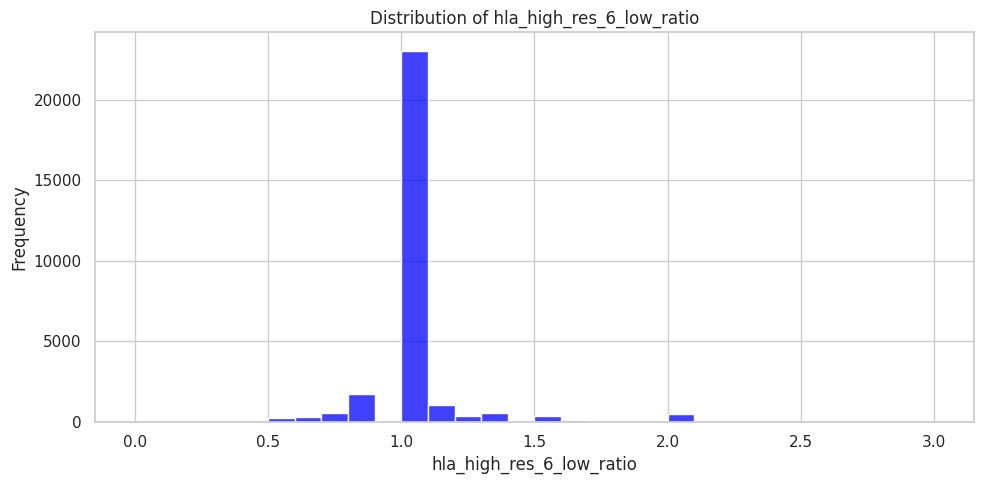

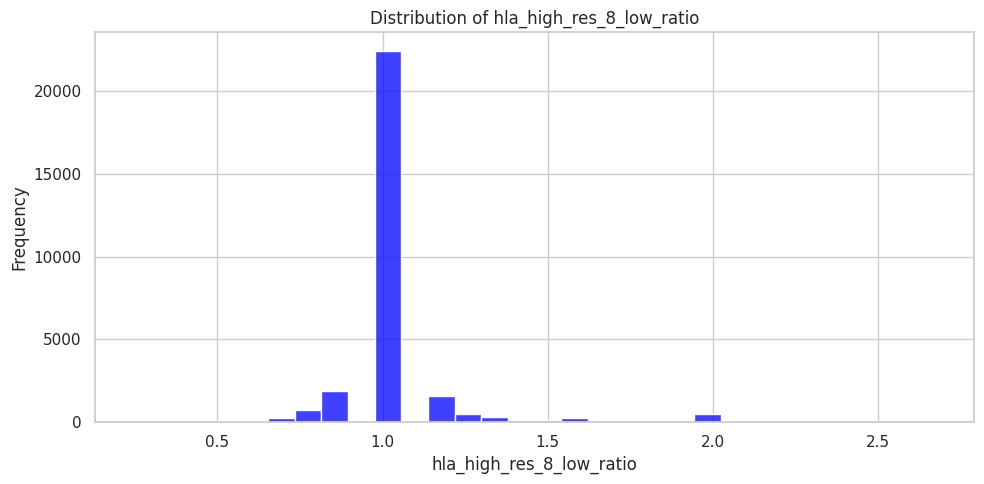

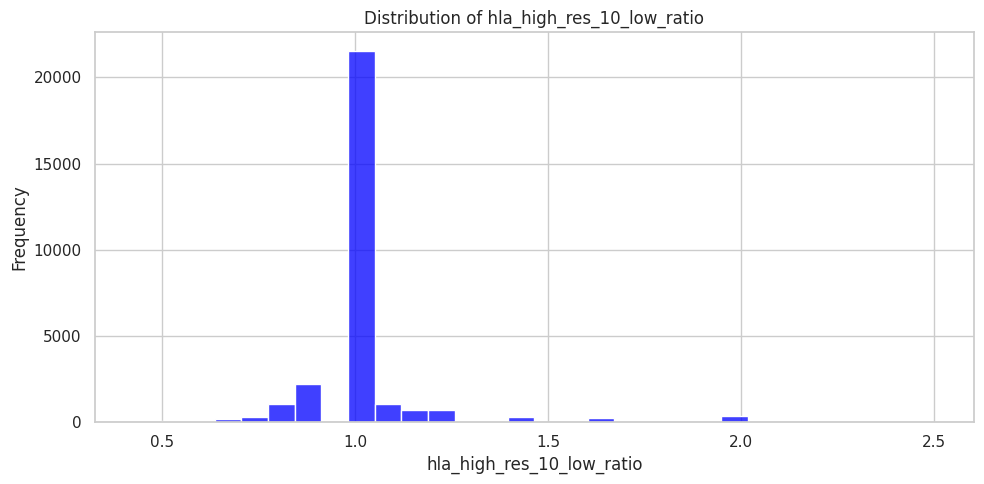

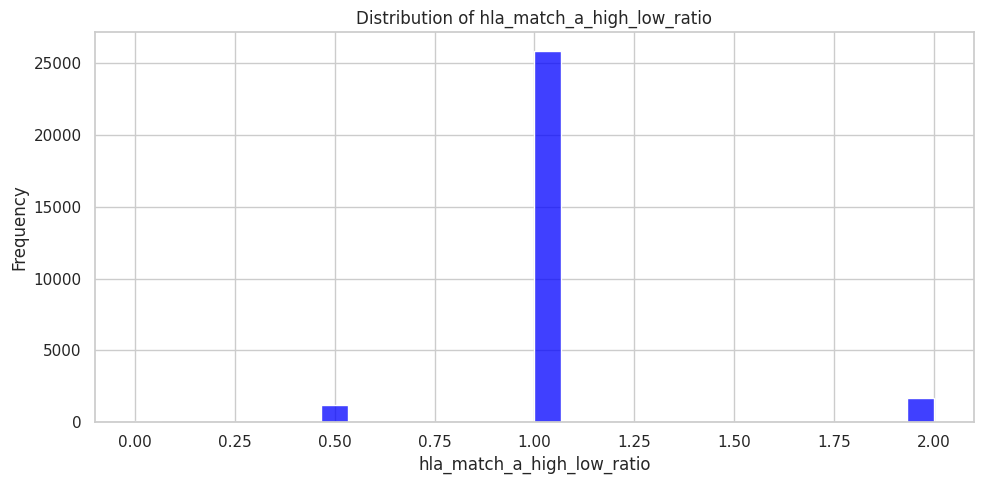

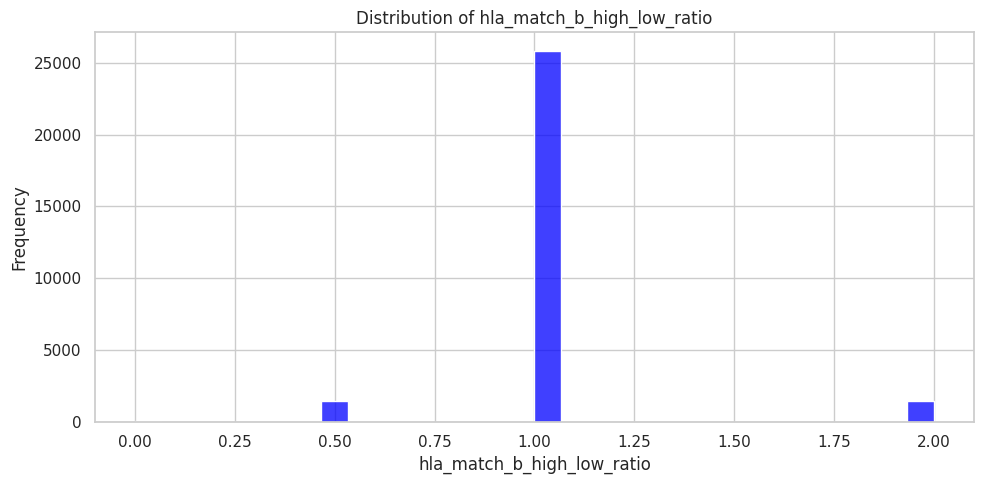

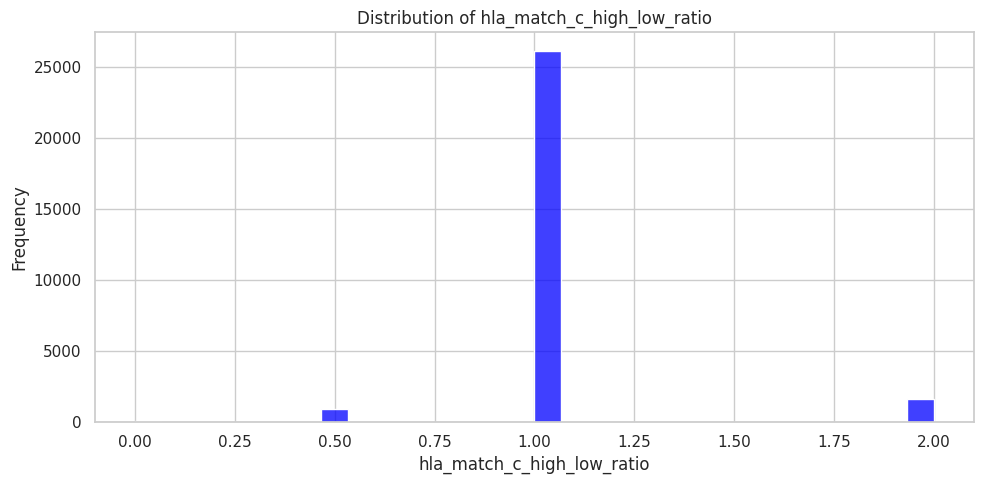

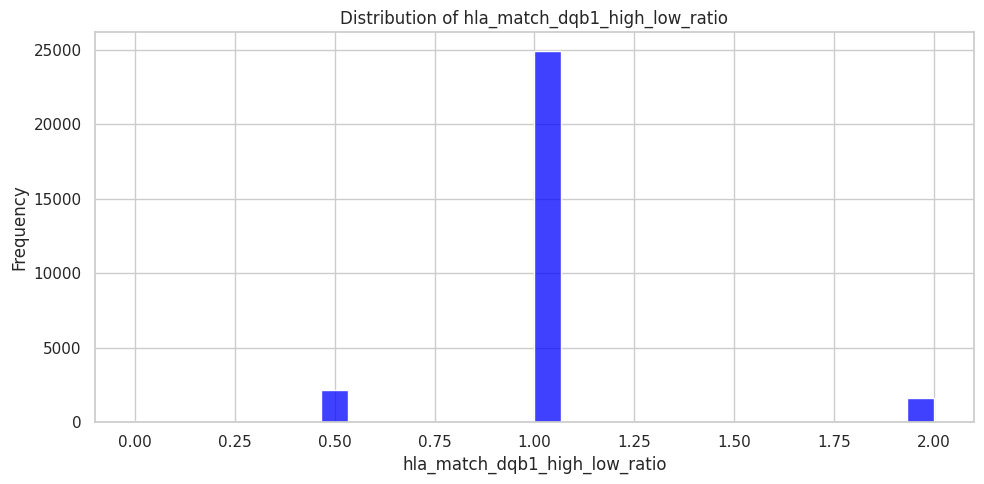

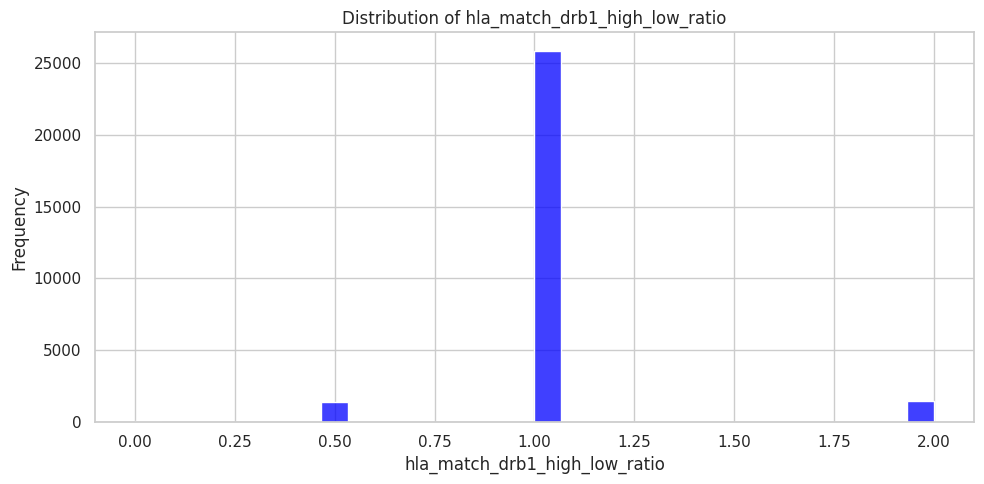

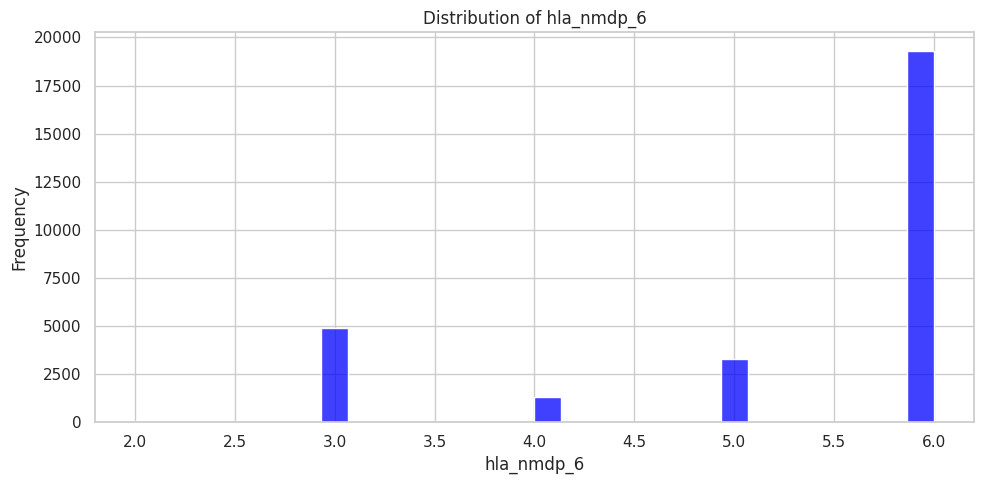

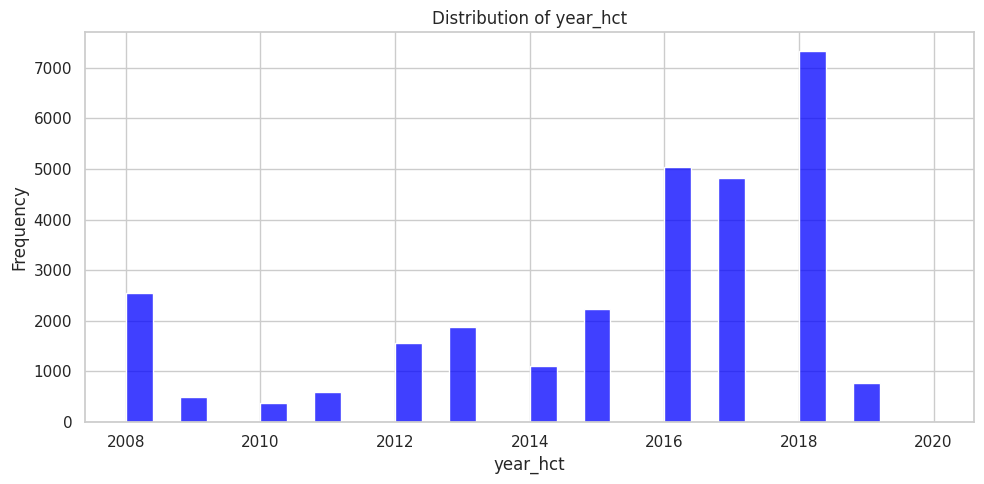

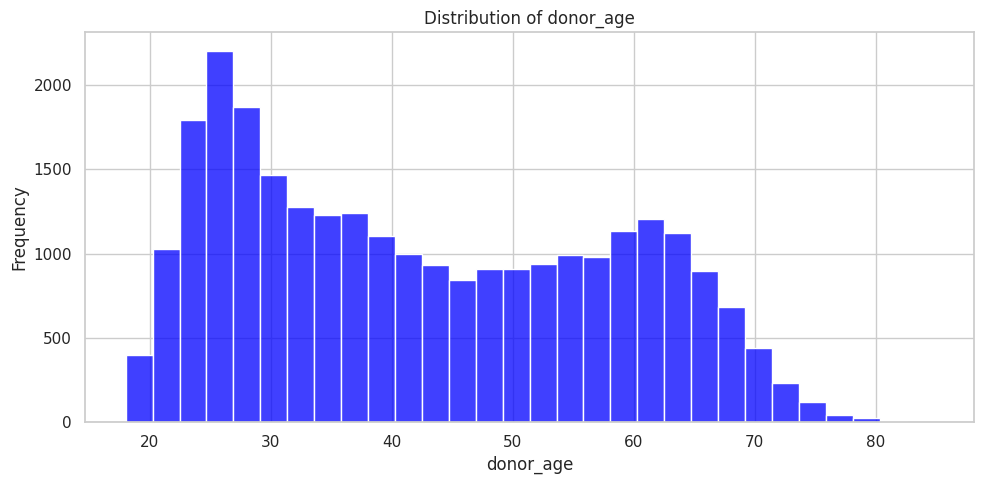

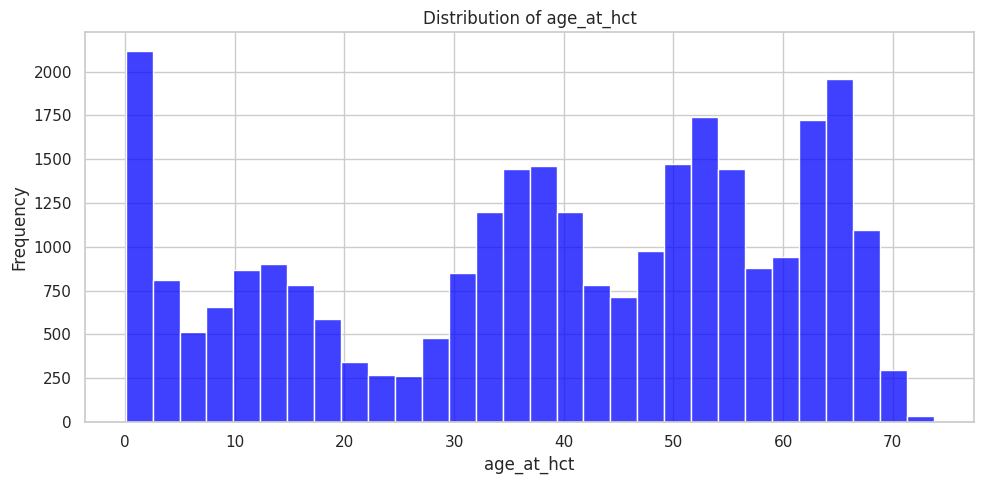

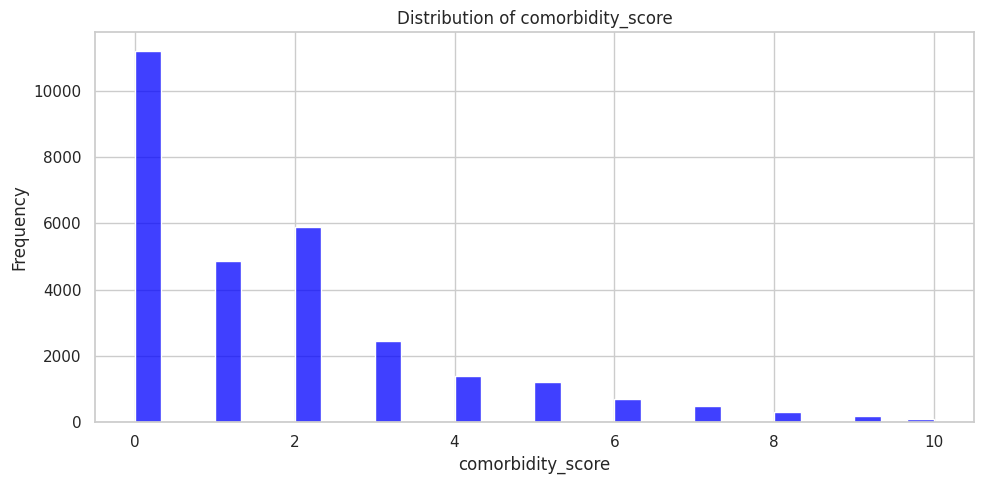

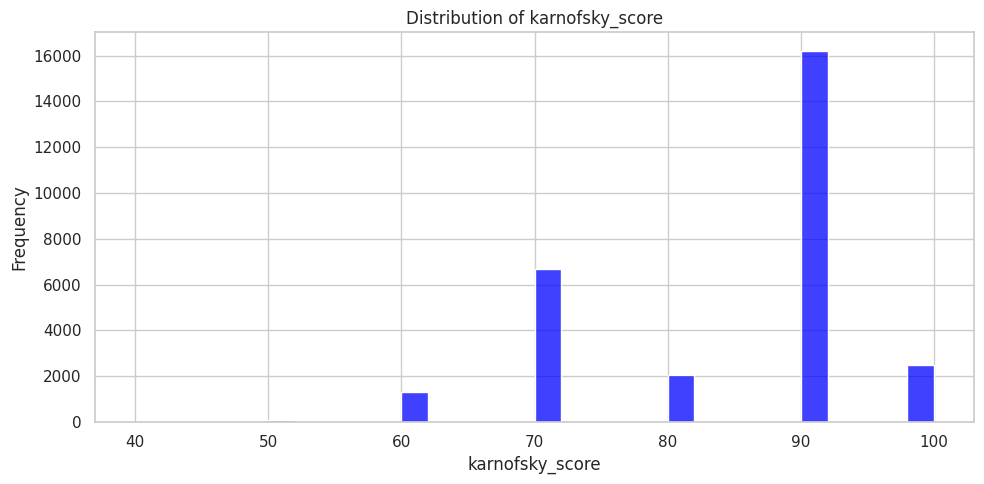

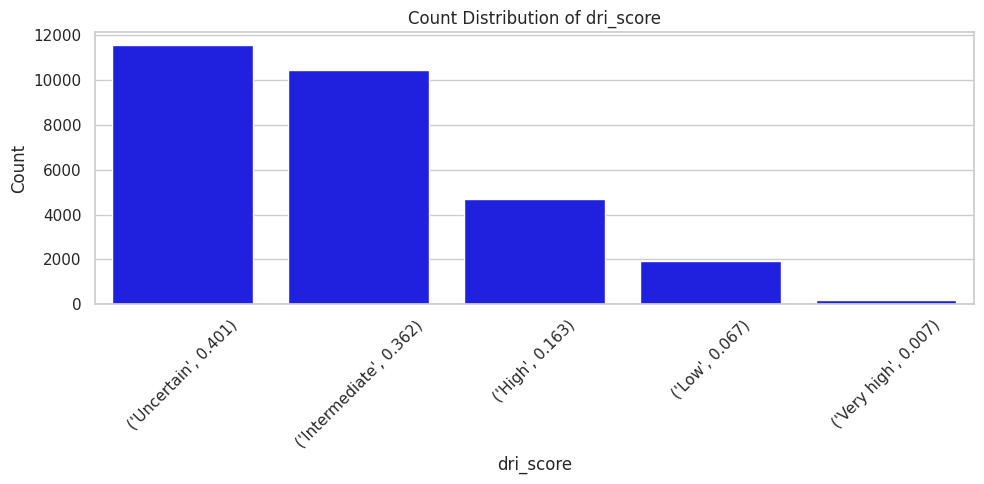

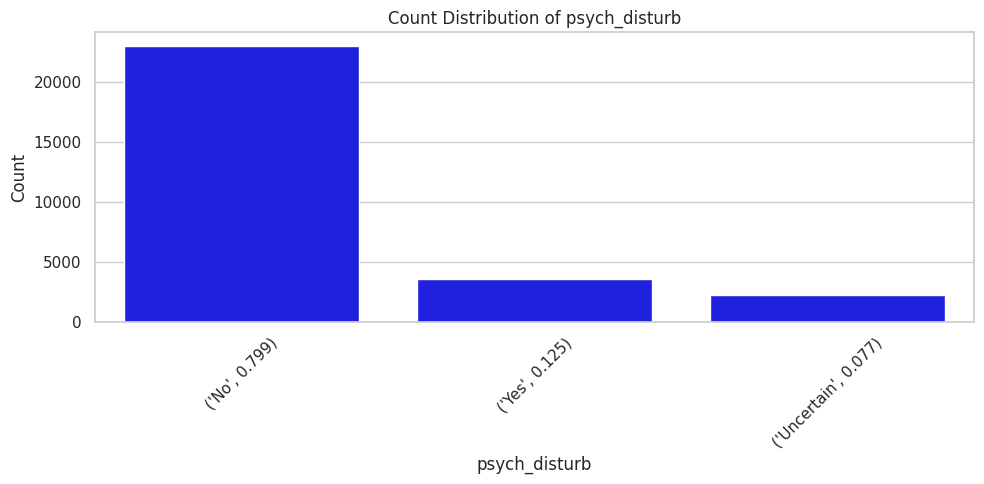

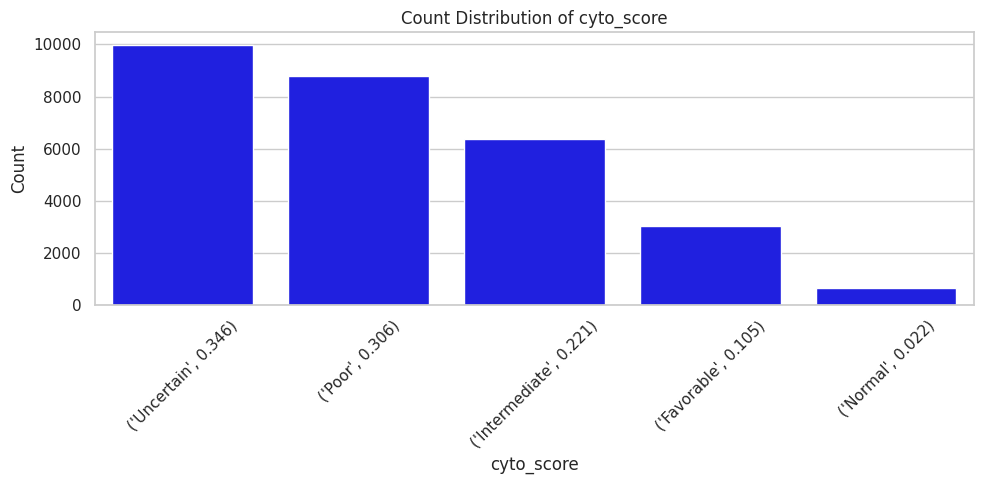

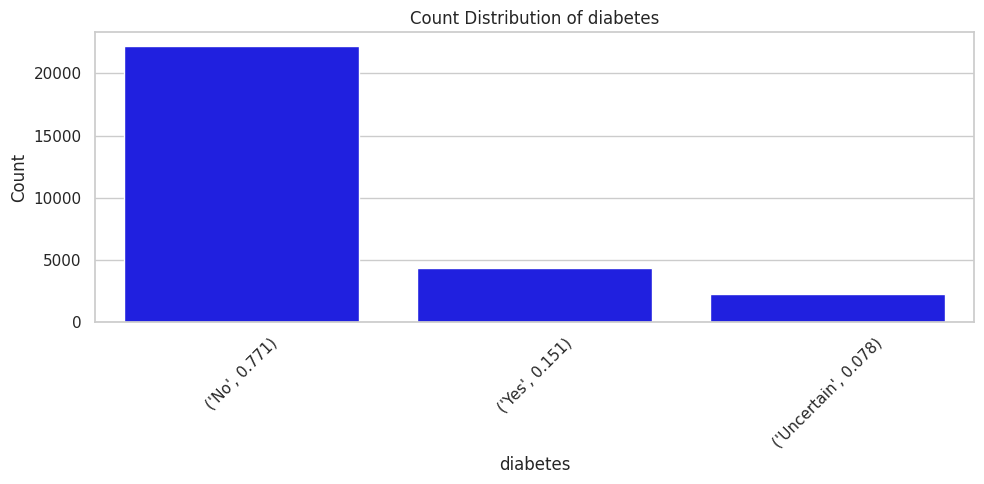

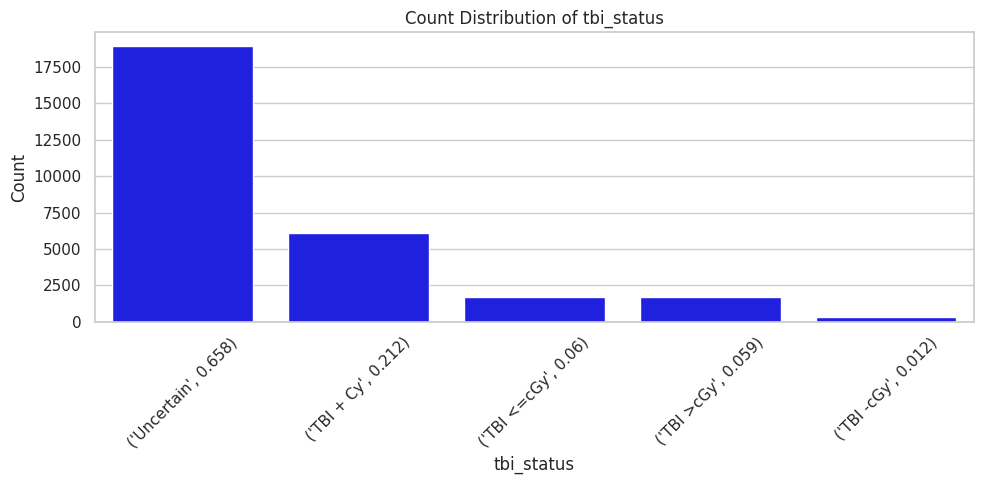

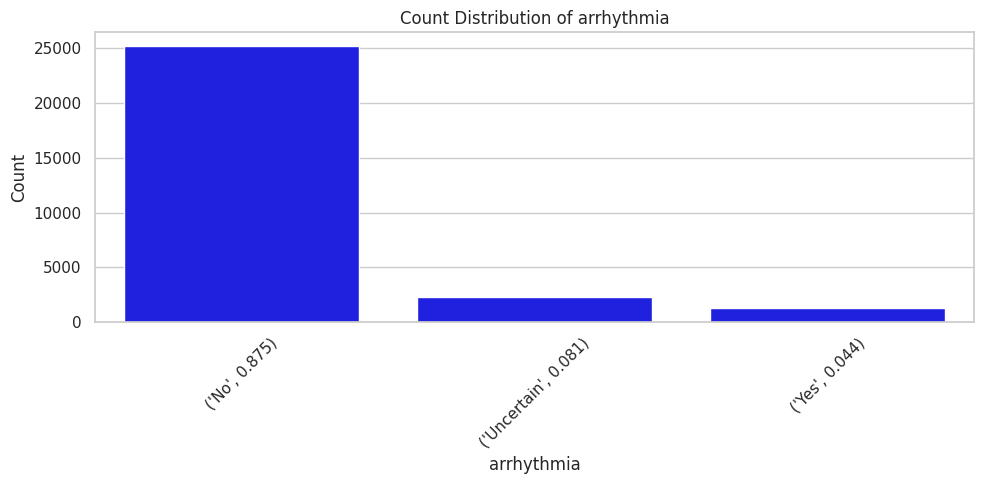

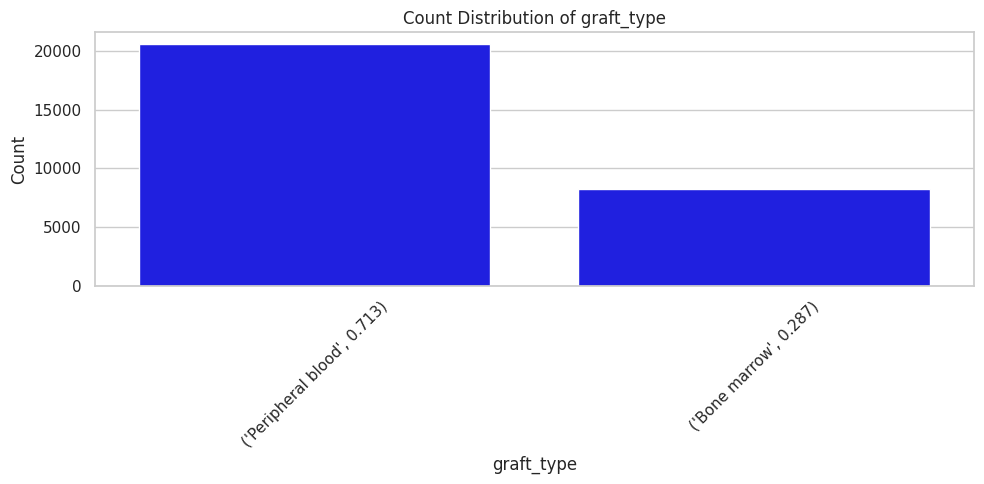

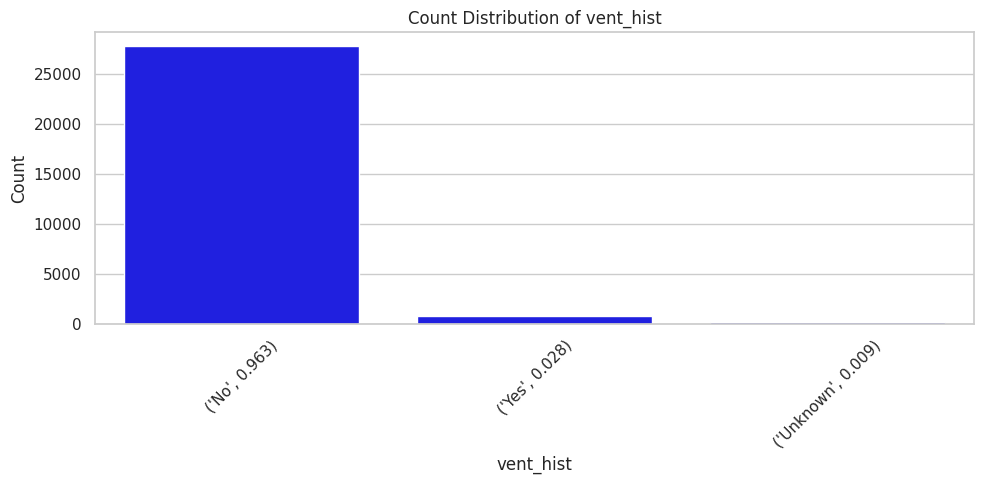

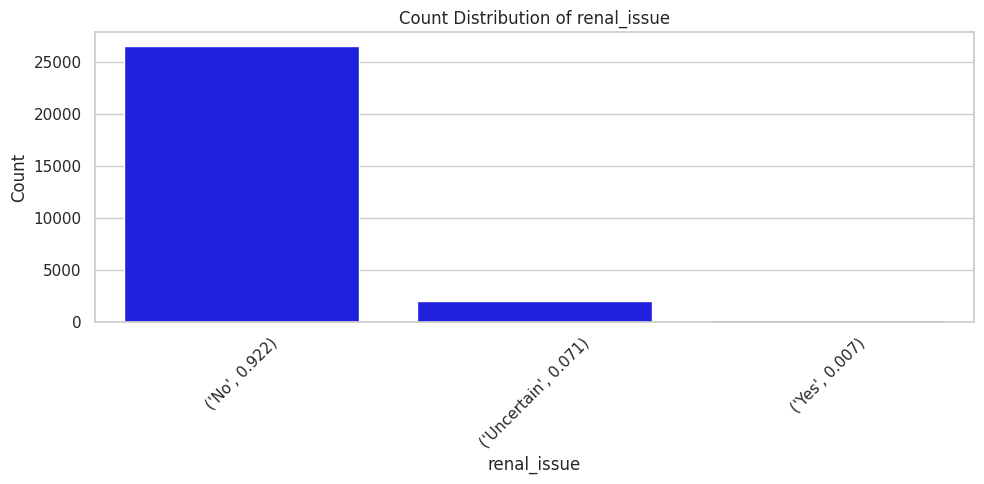

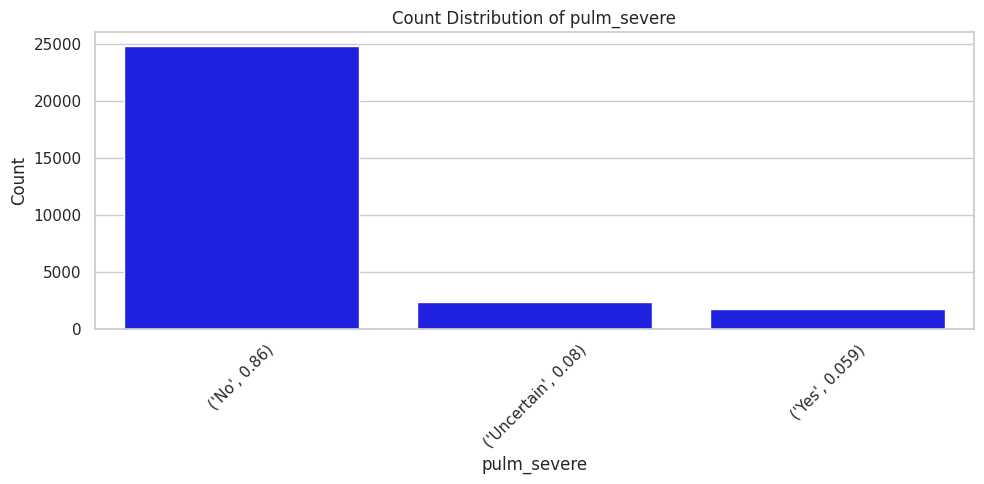

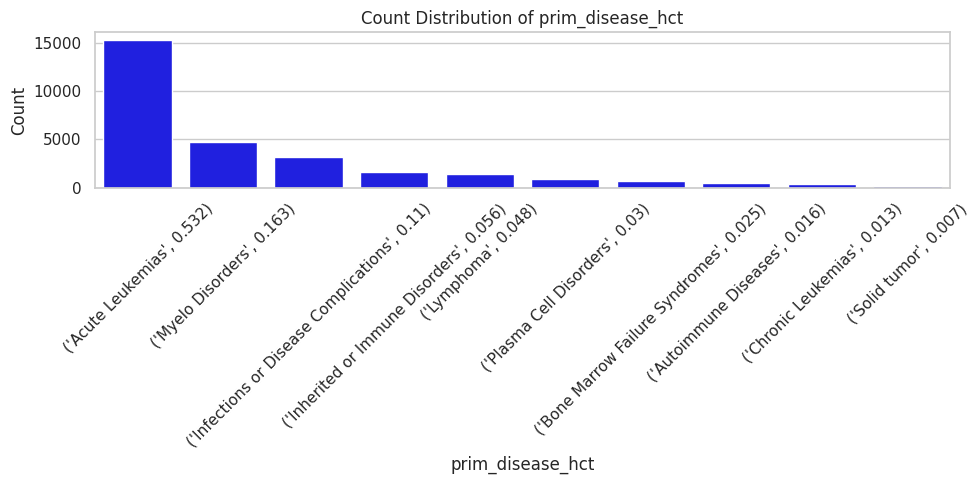

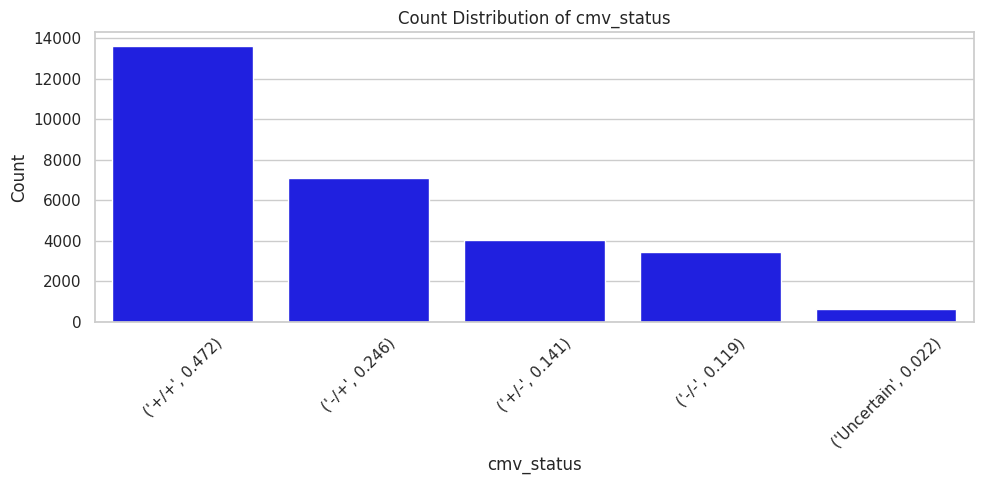

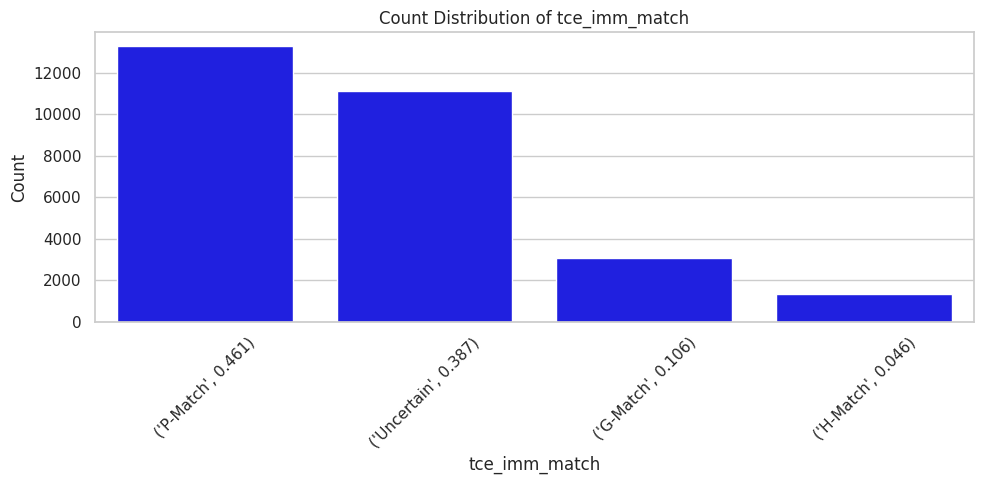

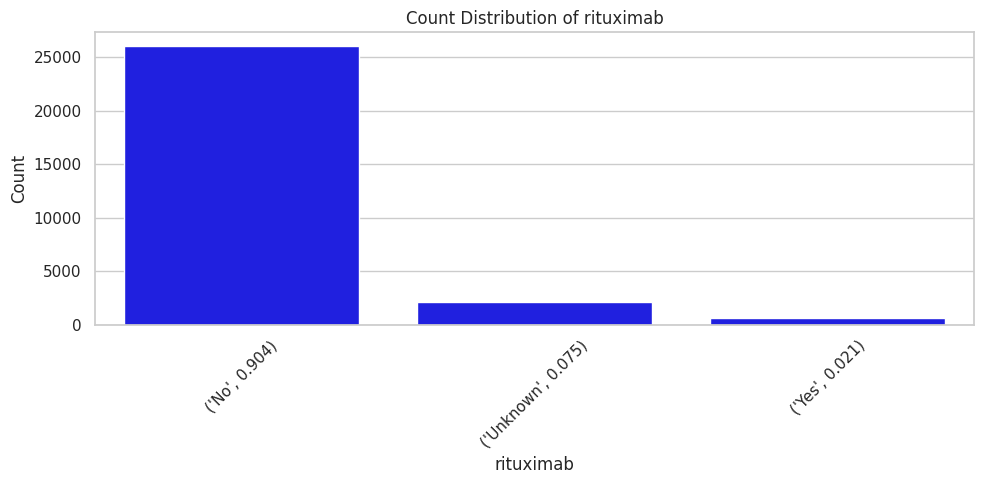

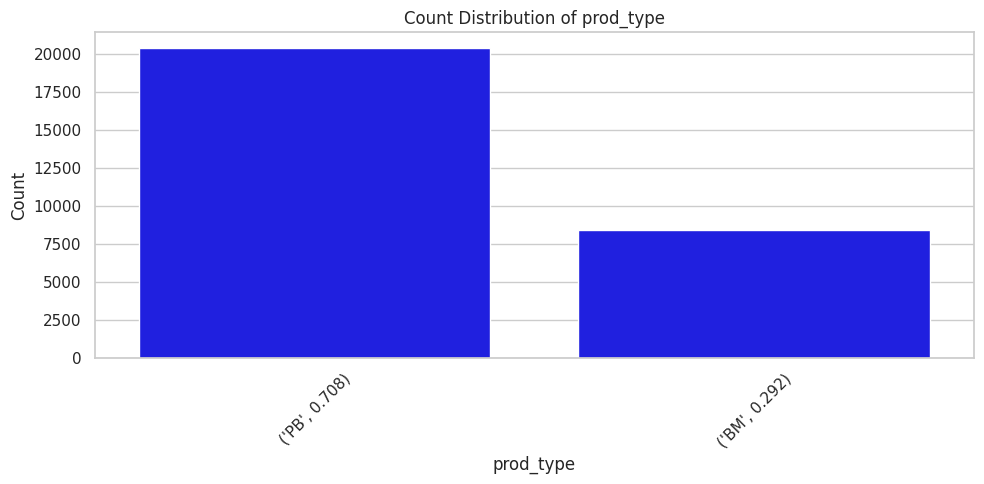

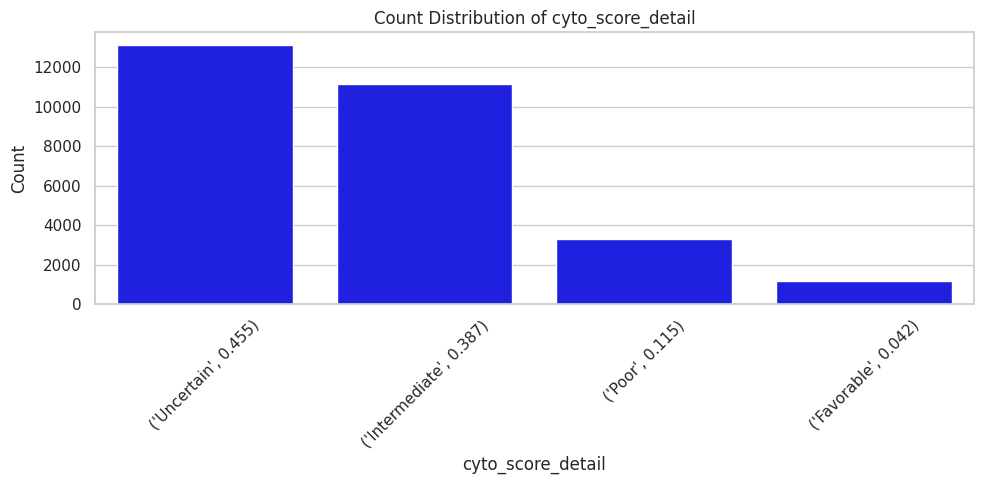

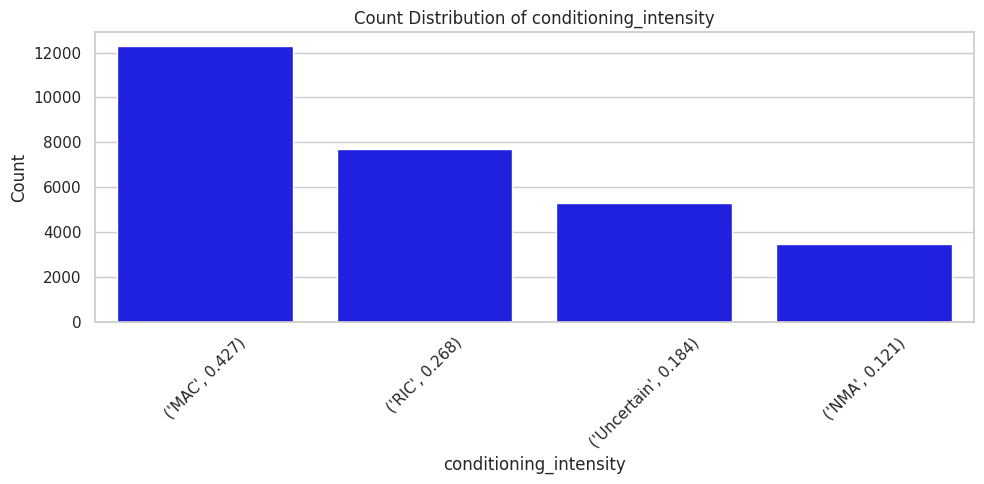

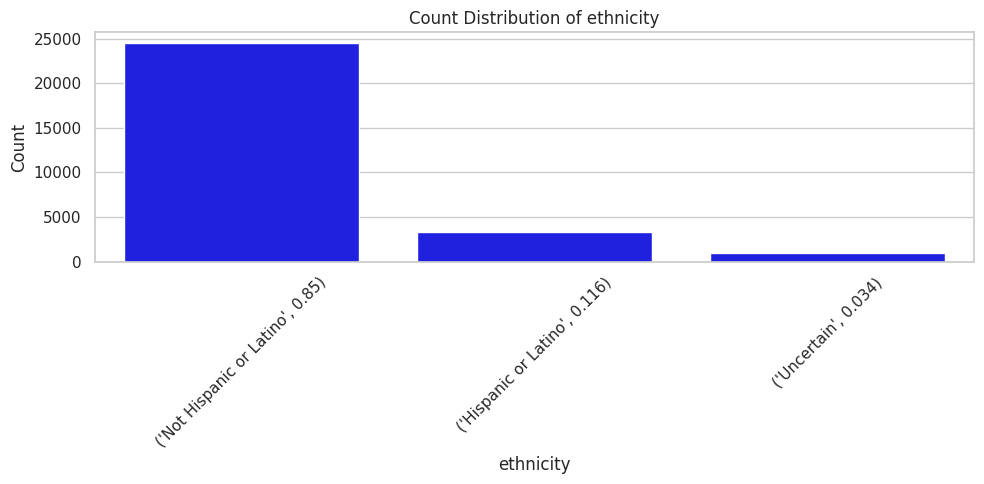

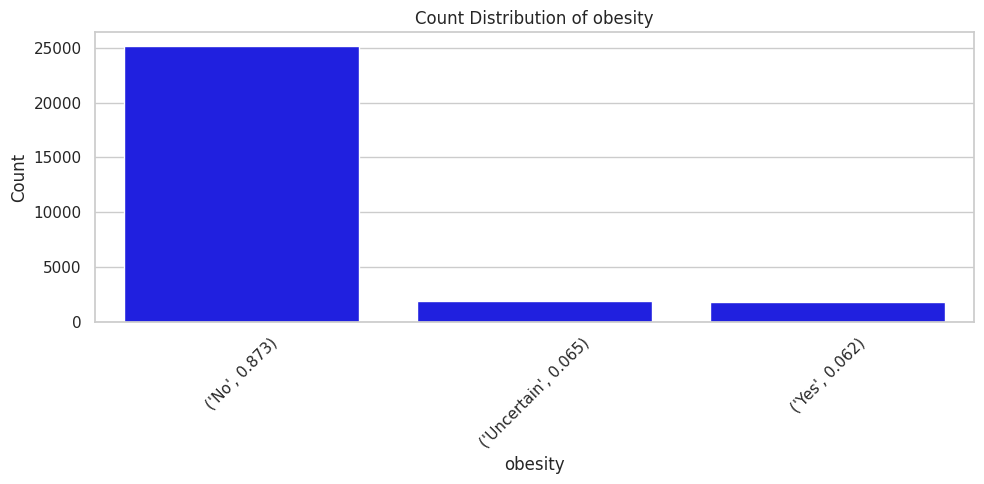

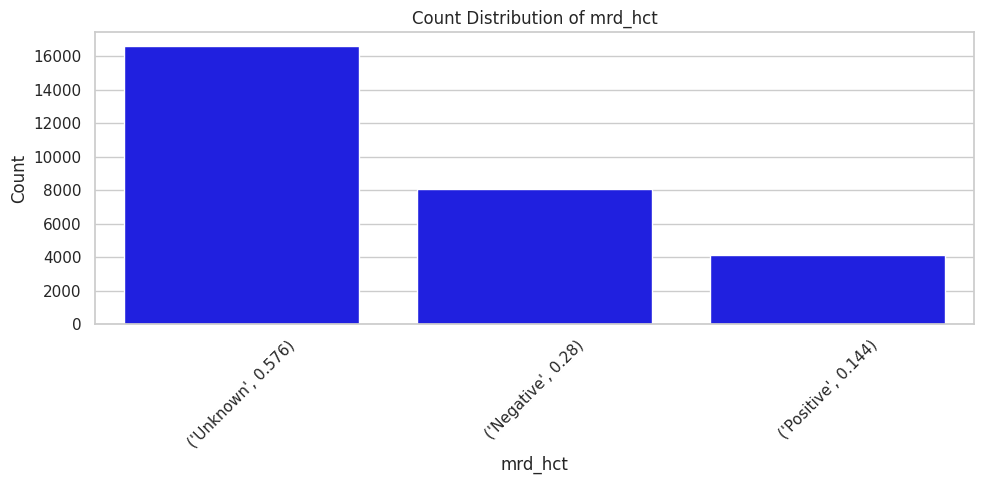

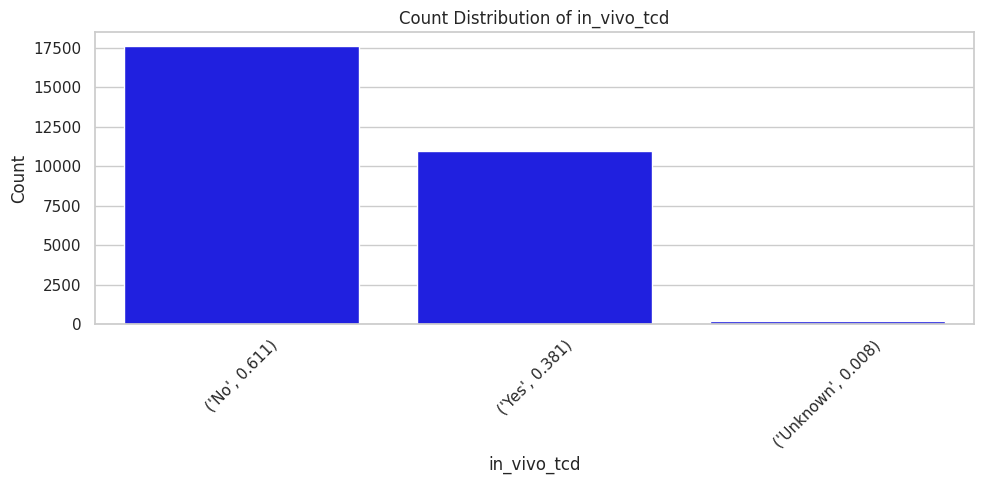

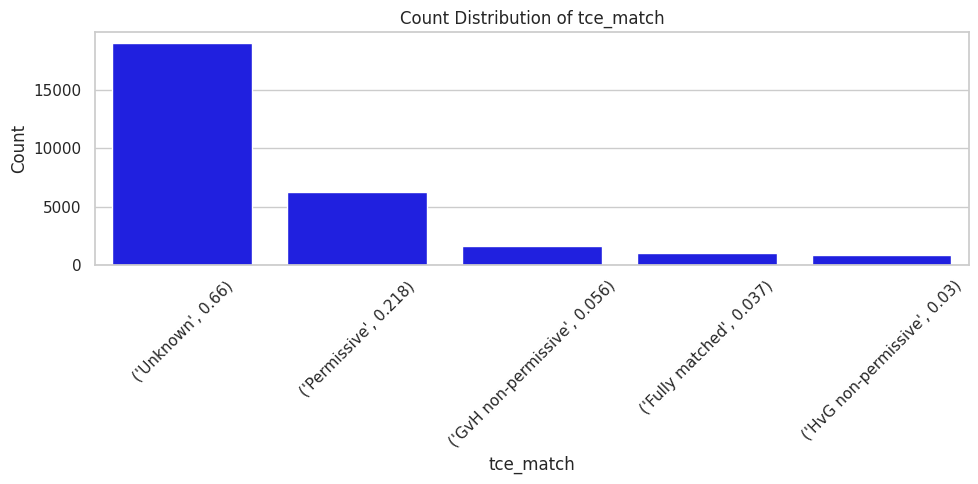

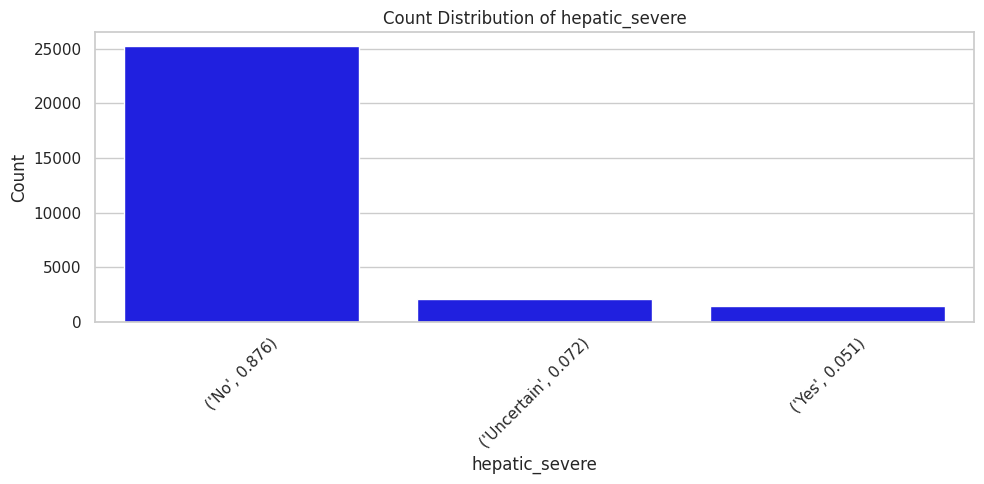

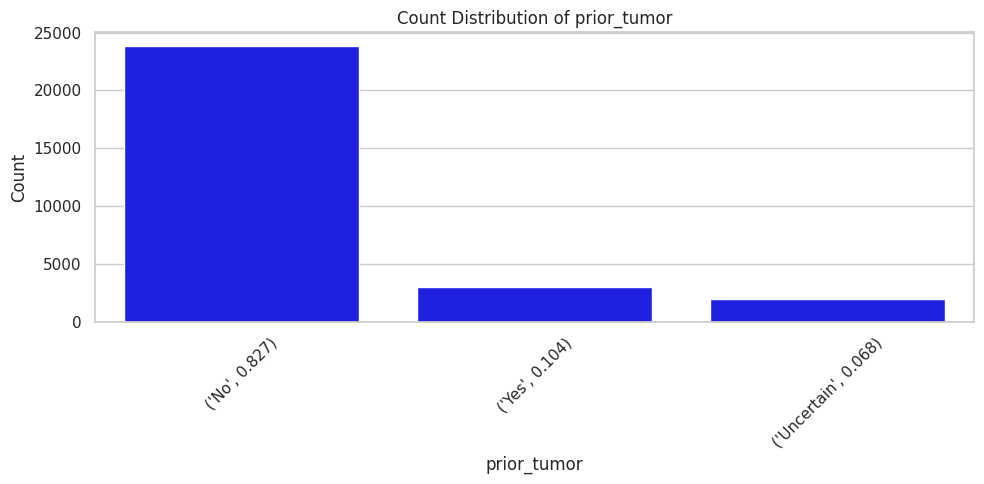

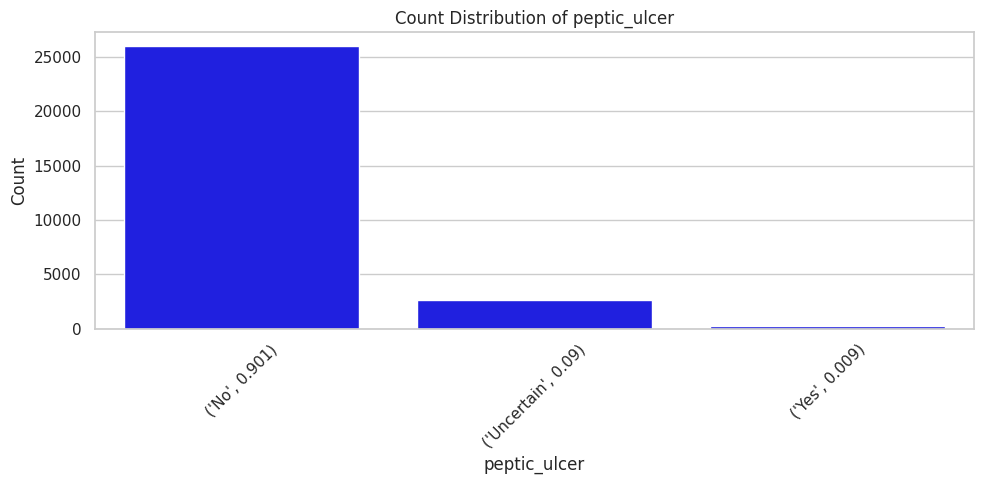

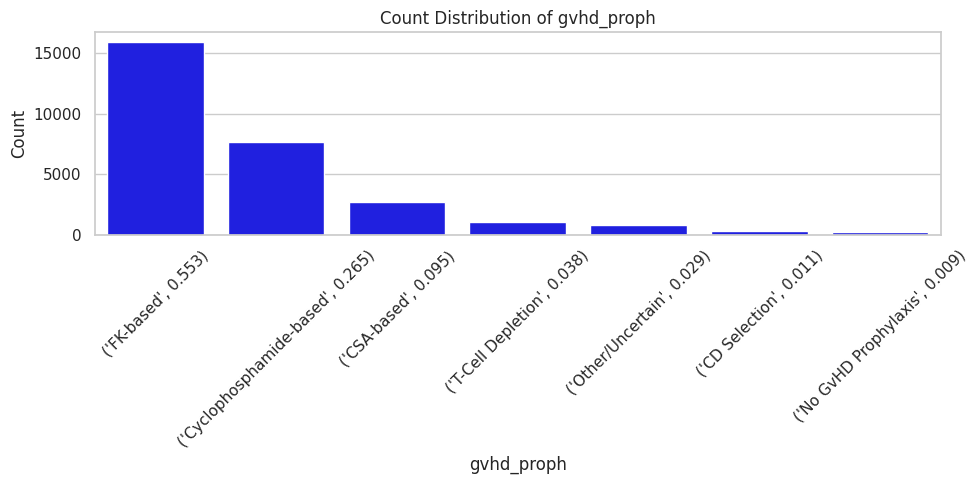

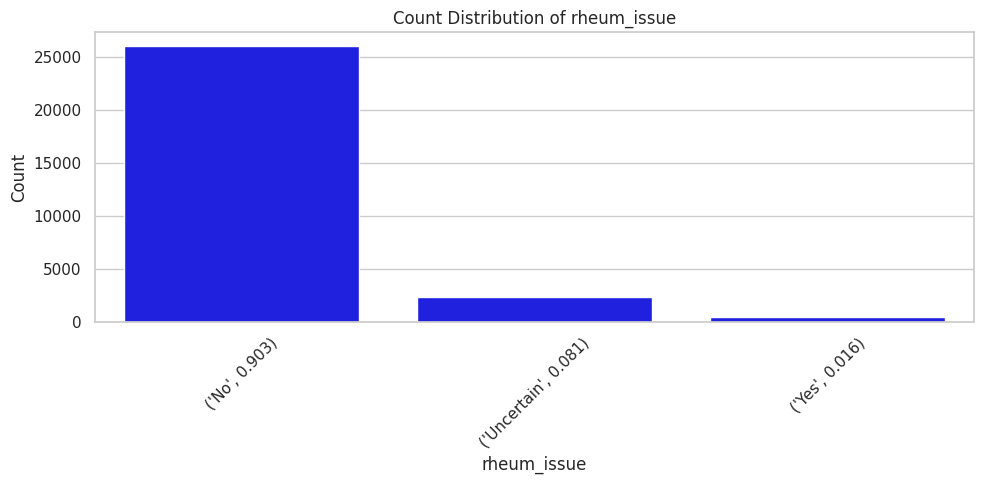

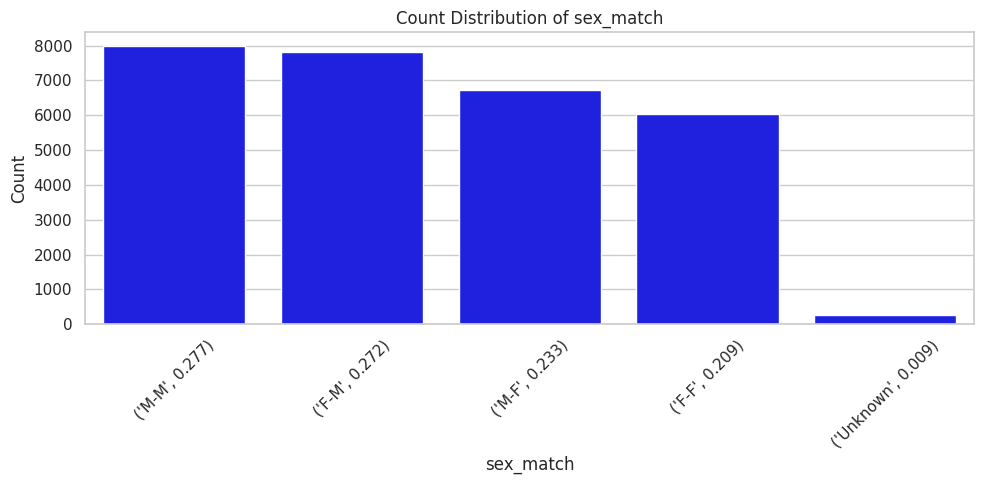

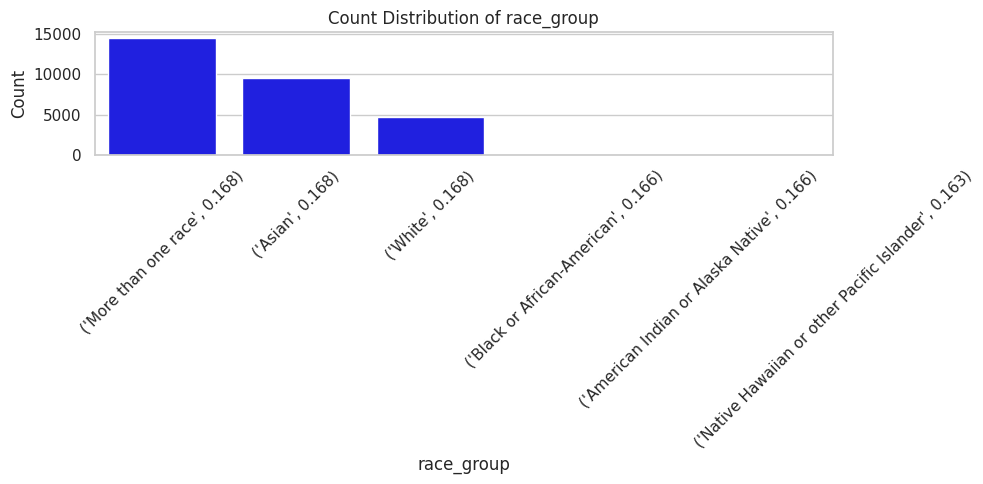

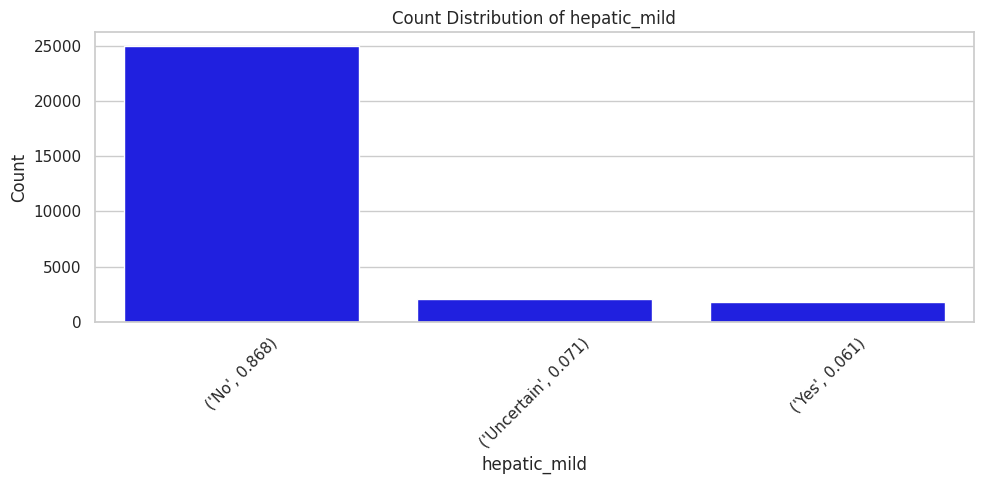

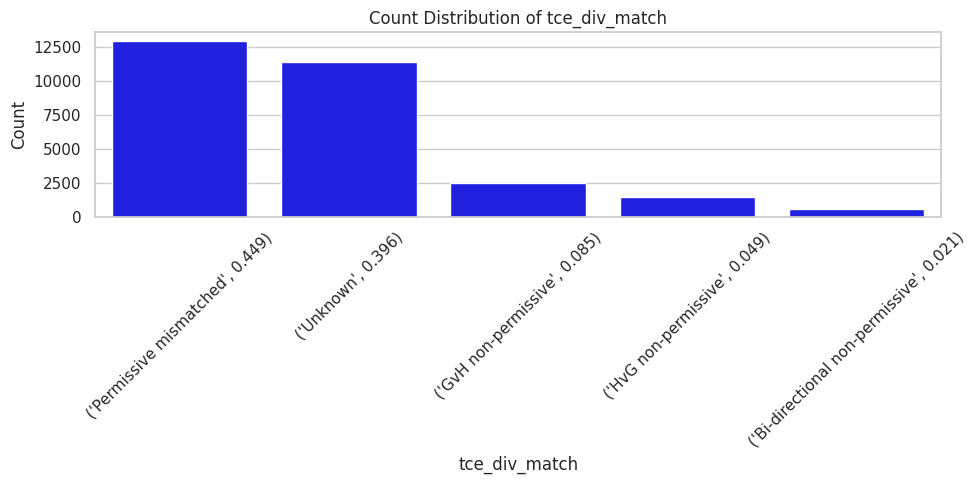

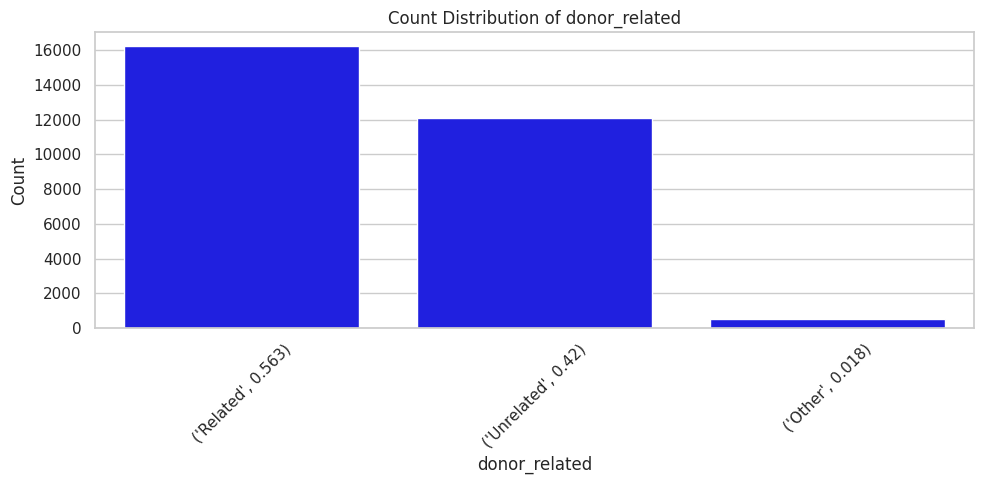

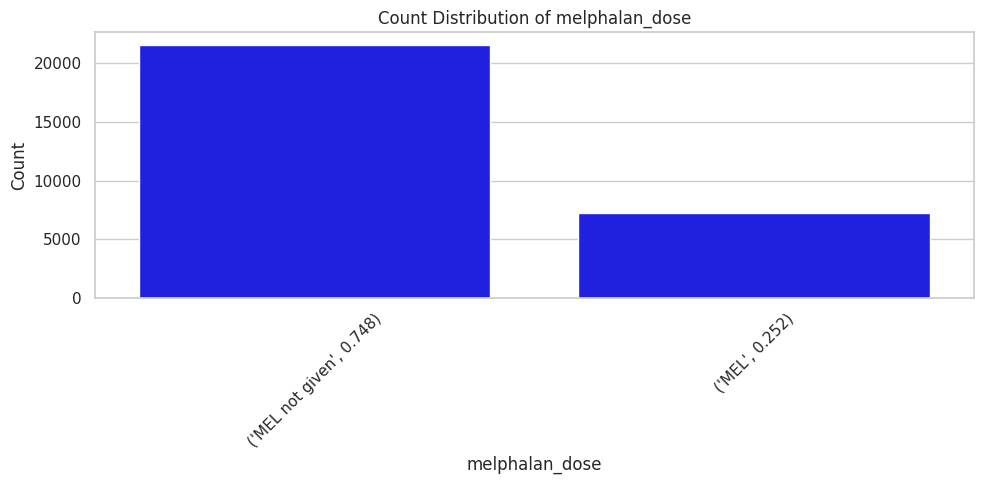

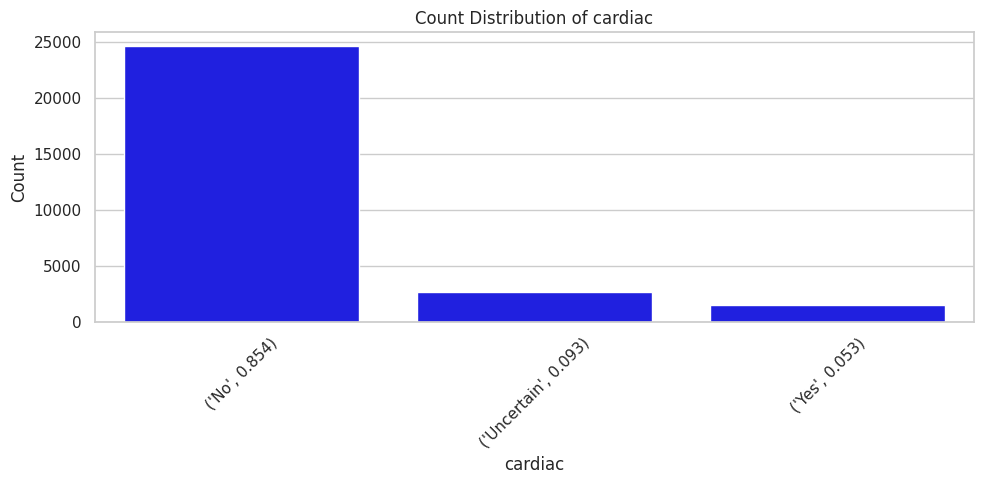

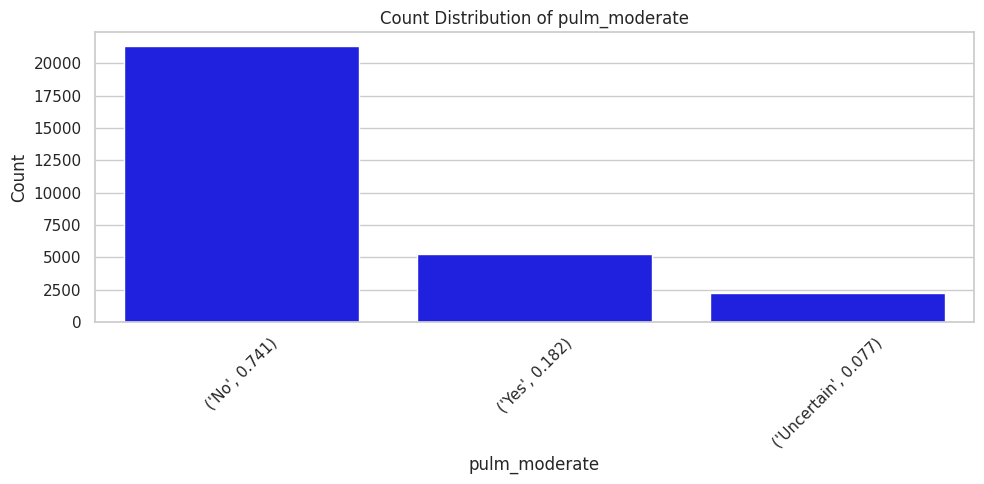

In [52]:
for col in df_cleaned_num.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_cleaned[col], bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

for col in df_cleaned_cat.columns:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=df_cleaned[col], order=df_cleaned[col].value_counts().index, color='blue')
    ax.set_xticks(range(len(cat_mapping[col].items())))
    ax.set_xticklabels(cat_mapping[col].items(), rotation=45)
    plt.title(f'Count Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Let's check the values of year_hct.

In [56]:
df_cleaned['year_hct'].value_counts().sort_index(ascending = False)

year_hct
2020       4
2019     774
2018    7336
2017    4830
2016    5049
2015    2243
2014    1098
2013    1871
2012    1571
2011     599
2010     378
2009     503
2008    2544
Name: count, dtype: int64

As year_hct is not useful in current format we need to convert it in a more meaningful way. More reasonable approach is to replace it with year_since_hct.

In [57]:
def replace_year_hct(df_cleaned):
  """Replaces variable 'year_hct' with 'years_since_hct'."""
  df = df_cleaned.copy()
  df['year_since_hct'] = df['year_hct'].max()
  df['year_since_hct'] = df['year_since_hct'] - df['year_hct']
  df.drop(columns='year_hct', inplace=True)
  return df

df_cleaned = replace_year_hct(df_cleaned = df_cleaned)
df_cleaned.head()

hla_high_res_6_low_ratio  hla_high_res_8_low_ratio  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   hla_high_res_10_low_ratio  hla_match_a_high_low_ratio  \
0                        1.0                         1.0   
1                        1.0                         1.0   
2                        1.0                         1.0   
3                        1.0                         1.0   
4                        1.0                         1.0   

   hla_match_b_high_low_ratio  hla_match_c_high_low_ratio  \
0                         1.0                         1.0   
1                         1.0                         1.0   
2                         1.0                         1.0   
3                         1.0                         1.0   
4                         1.0                         1.0   

   hla_match_dqb1_high_low_ratio  hla_match_drb1_high_low_ratio  hla_nmdp_6  \
0                            1.0                            1.0         6.0   
1                            1.0                            1.0         6.0   
2                            1.0                            1.0         6.0   
3                            1.0                            1.0         6.0   
4                            1.0                            1.0         5.0   

   donor_age  ...  rheum_issue  sex_match  race_group  hepatic_mild  \
0        NaN  ...        0.903      0.233       0.168         0.868   
1      72.29  ...        0.903      0.209       0.168         0.868   
2        NaN  ...        0.903      0.272       0.168         0.868   
3      29.23  ...        0.903      0.277       0.168         0.061   
4      56.81  ...        0.903      0.233       0.166         0.868   

   tce_div_match  donor_related  melphalan_dose  cardiac  pulm_moderate  \
0          0.396          0.420           0.748    0.854          0.741   
1          0.449          0.563           0.748    0.854          0.182   
2          0.449          0.563           0.748    0.854          0.741   
3          0.449          0.420           0.748    0.854          0.741   
4          0.449          0.563           0.252    0.854          0.741   

   year_since_hct  
0               4  
1              12  
2               1  
3              11  
4               2  

[5 rows x 49 columns]

Now we need to normalize numerical features for better model performance in the next step for evaluating most accurately missing donor_age values. Additionally we will keep all variables withing the same range from 0 to 1. This operation assures that model will not put more emphasis on any variable than it would do otherwise.

In [58]:
def apply_scaler(df_cleaned):
  """Applies MinMaxScaler to numerical variables."""
  df = df_cleaned.copy()
  scaler = MinMaxScaler()
  num_columns = list(df_cleaned_num.columns)
  num_columns.remove("year_hct")
  num_columns.append("year_since_hct")
  rescaled = pd.DataFrame(scaler.fit_transform(df[num_columns]), columns=num_columns)
  df[num_columns] = rescaled
  return df

df_cleaned = apply_scaler(df_cleaned = df_cleaned)
df_cleaned.describe().T

count      mean       std    min       25%  \
hla_high_res_6_low_ratio       28800.0  0.340032  0.060433  0.000  0.333333   
hla_high_res_8_low_ratio       28800.0  0.318888  0.070270  0.000  0.309917   
hla_high_res_10_low_ratio      28800.0  0.283865  0.077416  0.000  0.275362   
hla_match_a_high_low_ratio     28800.0  0.517743  0.131804  0.000  0.500000   
hla_match_b_high_low_ratio     28800.0  0.511406  0.127716  0.000  0.500000   
hla_match_c_high_low_ratio     28800.0  0.518524  0.128003  0.000  0.500000   
hla_match_dqb1_high_low_ratio  28800.0  0.507595  0.138700  0.000  0.500000   
hla_match_drb1_high_low_ratio  28800.0  0.512734  0.128176  0.000  0.500000   
hla_nmdp_6                     28800.0  0.820677  0.287725  0.000  0.750000   
donor_age                      26992.0  0.366845  0.228349  0.000  0.156266   
age_at_hct                     28800.0  0.524133  0.287011  0.000  0.264583   
comorbidity_score              28800.0  0.167413  0.198975  0.000  0.000000   
karnofsky_score                28800.0  0.733640  0.181869  0.000  0.500000   
dri_score                      28800.0  0.322974  0.110621  0.007  0.362000   
psych_disturb                  28800.0  0.659701  0.277746  0.077  0.799000   
cyto_score                     28800.0  0.273671  0.084457  0.022  0.221000   
diabetes                       28800.0  0.623210  0.271589  0.078  0.771000   
tbi_status                     28800.0  0.484809  0.244131  0.012  0.212000   
arrhythmia                     28800.0  0.774192  0.266918  0.044  0.875000   
graft_type                     28800.0  0.590910  0.192628  0.287  0.287000   
vent_hist                      28800.0  0.927799  0.178432  0.009  0.963000   
renal_issue                    28800.0  0.855012  0.230061  0.007  0.922000   
pulm_severe                    28800.0  0.749854  0.273461  0.059  0.860000   
prim_disease_hct               28800.0  0.329129  0.219618  0.007  0.110000   
cmv_status                     28800.0  0.317828  0.153411  0.022  0.141000   
tce_imm_match                  28800.0  0.375682  0.126911  0.046  0.387000   
rituximab                      28800.0  0.823192  0.247965  0.021  0.904000   
prod_type                      28800.0  0.586392  0.189213  0.292  0.292000   
cyto_score_detail              28800.0  0.372102  0.124147  0.042  0.387000   
conditioning_intensity         28800.0  0.302592  0.116198  0.121  0.184000   
ethnicity                      28800.0  0.737186  0.268955  0.034  0.850000   
obesity                        28800.0  0.770244  0.269483  0.062  0.873000   
mrd_hct                        28800.0  0.431054  0.174158  0.144  0.280000   
in_vivo_tcd                    28800.0  0.518570  0.120305  0.008  0.381000   
tce_match                      28800.0  0.488186  0.244116  0.030  0.218000   
hepatic_severe                 28800.0  0.775481  0.267594  0.051  0.876000   
prior_tumor                    28800.0  0.699728  0.278719  0.068  0.827000   
peptic_ulcer                   28800.0  0.820185  0.244257  0.009  0.901000   
gvhd_proph                     28800.0  0.387732  0.195994  0.009  0.265000   
rheum_issue                    28800.0  0.822480  0.246213  0.016  0.903000   
sex_match                      28800.0  0.248736  0.035737  0.009  0.233000   
race_group                     28800.0  0.166517  0.001794  0.163  0.166000   
hepatic_mild                   28800.0  0.761927  0.271630  0.061  0.868000   
tce_div_match                  28800.0  0.368469  0.132586  0.021  0.396000   
donor_related                  28800.0  0.493442  0.094567  0.018  0.420000   
melphalan_dose                 28800.0  0.622967  0.215371  0.252  0.252000   
cardiac                        28800.0  0.740700  0.274002  0.053  0.854000   
pulm_moderate                  28800.0  0.588096  0.259718  0.077  0.182000   
year_since_hct                 28800.0  0.401713  0.262826  0.000  0.166667   

                                    50%       75%    max  
hla_high_res_6_low_rati

The next part is to impute missing donor_age values using an imputer. For this task we are going to evaluate three kinds of imputers and evaluate the results of their transformations. These are:


1.   K-Nearest Neighbours Imputer,
2.   Random Forest Regressor,
3.   Iterative Imputer.

As it can be seen KNN and Iterative Imputer are part of sklearn.impute module. Their behaviour is simplier and more intuitive for imputation as they are designed to handle such cases. Slighlty different approach is taken when using Random Forest Regressor as it belongs to sklearn.ensemble module. By doing so we have to explicitly separate missing and actual donor_age values. This model is going to be trained on a subset containing donor_ages and then we are going to predict missing values of the second subset.

In [59]:
imputed_variants = {
    "KNN": {
        "imputer": None,
        "donor_age": None
    },
    "Random Forest Regressor": {
        "imputer": None,
        "donor_age": None
    },
    "Iterative Imputer": {
        "imputer": None,
        "donor_age": None
    },
}

def knn_impute_donor_age(df_cleaned, neighbors=5):
    df = df_cleaned.copy()
    X = pd.DataFrame(df)

    knn_imputer = KNNImputer(n_neighbors = neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns = X.columns)

    imputed_variants["KNN"]["donor_age"] = df_imputed['donor_age']
    imputed_variants["KNN"]["imputer"] = knn_imputer

def rf_impute_donor_age(df_cleaned):
    df = df_cleaned.copy()

    df_train = df[df["donor_age"].notna()]
    df_missing = df[df["donor_age"].isnull()]

    X_train = df_train.drop(columns = ["donor_age"])
    y_train = df_train["donor_age"]

    X_missing = df_missing.drop(columns = ["donor_age"])

    rf = RandomForestRegressor(n_estimators = 100, random_state = SEED)
    rf.fit(X_train, y_train)

    df.loc[df["donor_age"].isna(), "donor_age"] = rf.predict(X_missing)

    imputed_variants["Random Forest Regressor"]["donor_age"] = df['donor_age']
    imputed_variants["Random Forest Regressor"]["imputer"] = rf

def iterative_imputer_donor_age(df_cleaned):
    df = df_cleaned.copy()
    X = pd.DataFrame(df)

    iter_imp = IterativeImputer(random_state = SEED)
    df_imputed = pd.DataFrame(iter_imp.fit_transform(X), columns = X.columns)

    imputed_variants["Iterative Imputer"]["donor_age"] = df_imputed['donor_age']
    imputed_variants["Iterative Imputer"]["imputer"] = iter_imp

In [60]:
knn_impute_donor_age(df_cleaned = df_cleaned)
rf_impute_donor_age(df_cleaned = df_cleaned)
iterative_imputer_donor_age(df_cleaned = df_cleaned)

All variables have been preprocessed and transformed, donor_age missing values were imputted with different algorithms: K-Nearest Neighbours, Random Forest Regressor and Iterative Imputer.

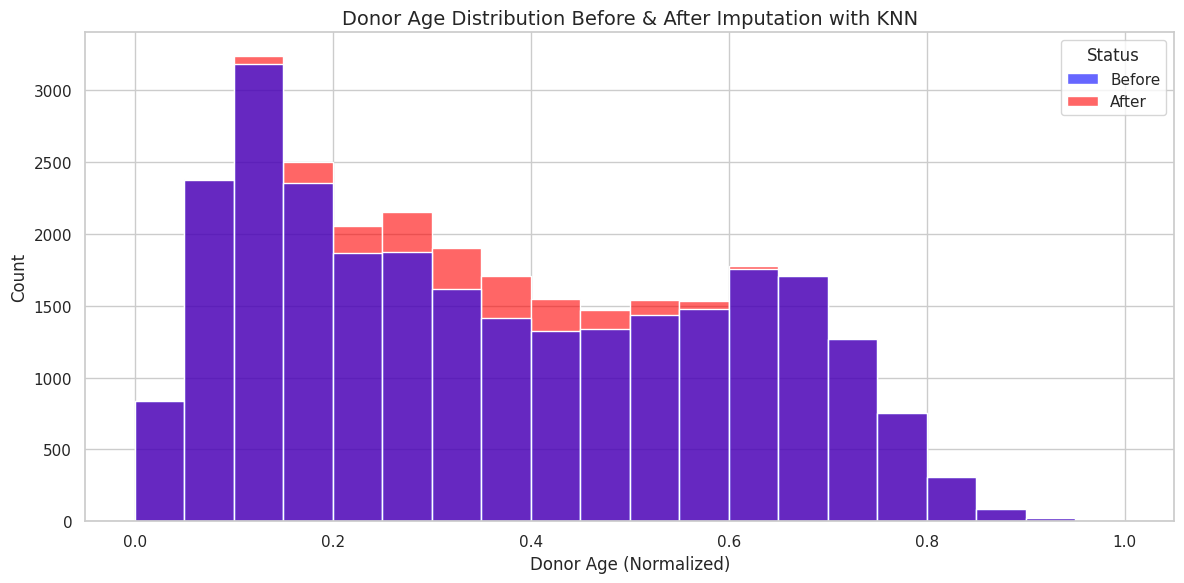

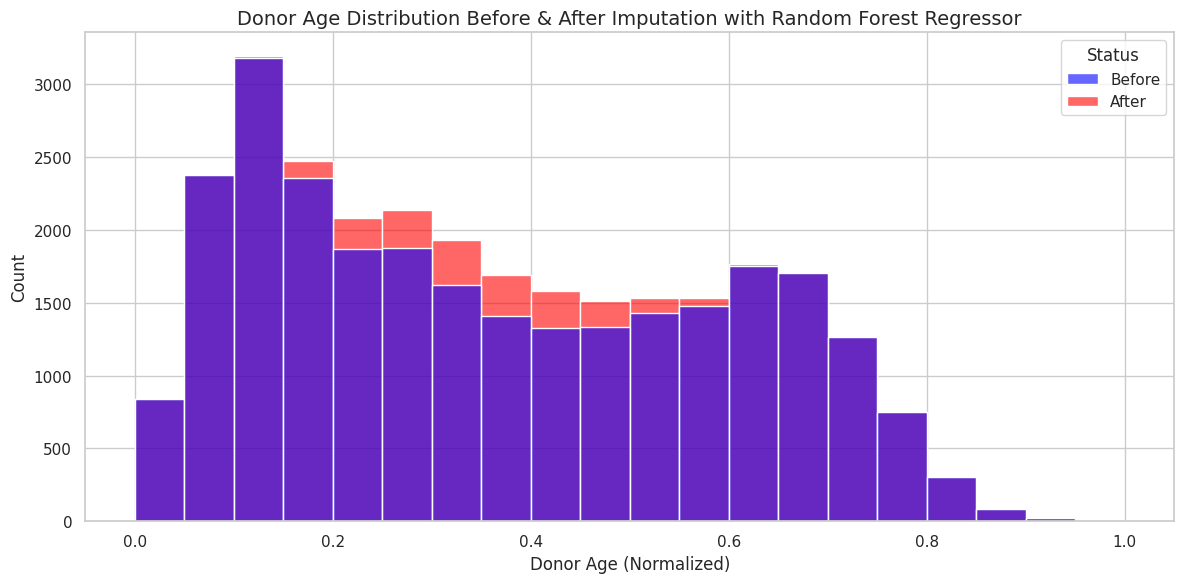

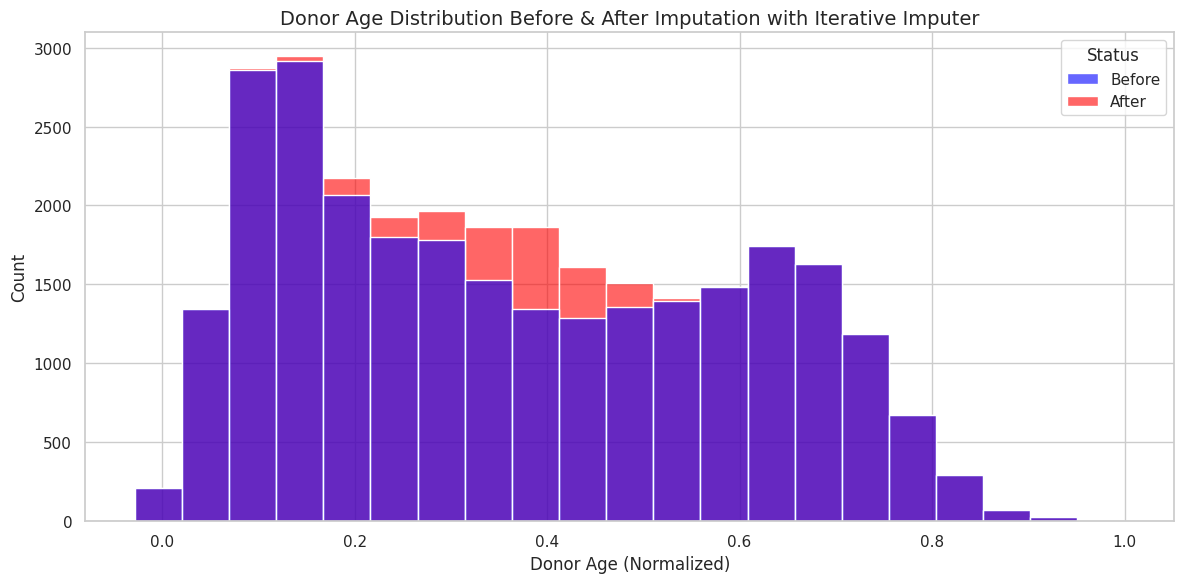

In [61]:
for key, value in imputed_variants.items():
  df = pd.DataFrame({
    "Before": df_cleaned["donor_age"],
    "After": value["donor_age"].values
    }
  )

  donor_ages_melted = df.melt(var_name="Status", value_name="donor_age")

  plt.figure(figsize=(12, 6))
  sns.histplot(data=donor_ages_melted, x="donor_age", hue="Status",
              binwidth=0.05, palette={"Before": "blue", "After": "red"},
              alpha=0.6, multiple='layer')

  plt.title(f"Donor Age Distribution Before & After Imputation with {key}", fontsize=14)
  plt.xlabel("Donor Age (Normalized)", fontsize=12)
  plt.ylabel("Count", fontsize=12)
  plt.tight_layout()
  plt.show()

ANOVA Test for comparison of means between two groups:

H0: The means of the groups are equal.

H1: At least one group mean is different from the others.

p > 0.05 → The means of the groups are similar (no significant difference).

p < 0.05 → At least one group mean is significantly different from the others.

In [62]:
for key, value in imputed_variants.items():
  anova_test = f_oneway(df_cleaned['donor_age'].fillna(0), value["donor_age"])
  print(f"ANOVA Test for {key}:", anova_test.statistic.round(3), anova_test.pvalue.round(3))

ANOVA Test for KNN: 125.649 0.0
ANOVA Test for Random Forest Regressor: 132.775 0.0
ANOVA Test for Iterative Imputer: 137.774 0.0


Levene's Test for comparison of variances between two groups:

H0: The variances among the groups are equal.

H1: The variances among the groups are not equal.

p > 0.05 → Variances are similar.

p < 0.05 → Variances differ significantly.

In [63]:
for key, value in imputed_variants.items():
  levene_test = levene(df_cleaned['donor_age'].fillna(0), value["donor_age"])
  print(f"Levene's Test for {key}", levene_test.statistic.round(3), levene_test.pvalue.round(3))

Levene's Test for KNN 187.225 0.0
Levene's Test for Random Forest Regressor 198.776 0.0
Levene's Test for Iterative Imputer 227.424 0.0


The Iterative Imputer has the highest F-statistic among the three imputers.  It suggests that it explains the most variance between group means (df_cleaned ['donor_age'].fillna(0) and imputed_iter_df) compared to within groups. Based on the ANOVA results, the Iterative Imputer would be the best choice, as it indicates the strongest group mean differences and the best performance in terms of this statistical measure.

In [64]:
df_cleaned['donor_age'] = imputed_variants['Iterative Imputer']["donor_age"]

def apply_donor_age(df_cleaned, imputer):
  df = df_cleaned.copy()
  columns_to_transform = list(imputed_variants[imputer]["imputer"].feature_names_in_)
  df = df[columns_to_transform]
  df_imputed = imputed_variants[imputer]["imputer"].transform(df)
  return pd.DataFrame(df_imputed, columns=columns_to_transform)

Description of target data and its graphical representation. EFS time is given in units of months which will be converted into years to maintain cohesion with other variables repesented in years.

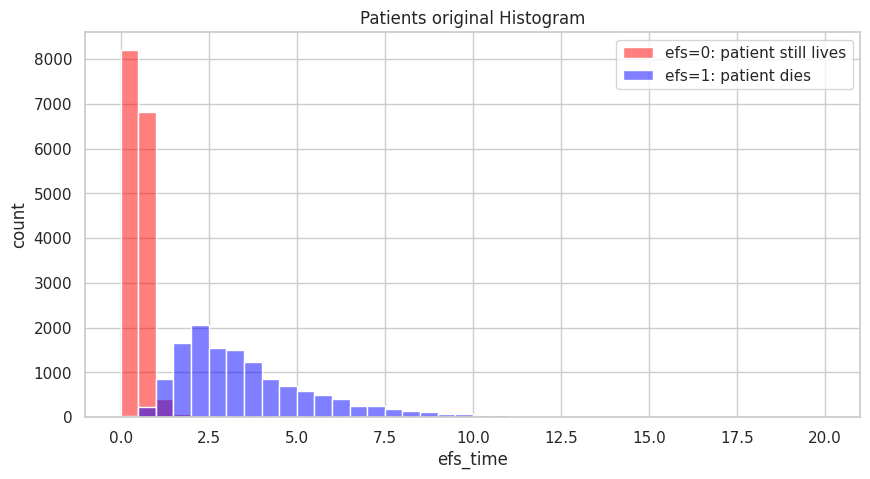

In [65]:
df_efs = original[['ID', 'efs', 'efs_time']]
df_efs.loc[:, 'efs_time'] = (df_efs['efs_time'] / 12).round(2) # Converting efs_time from months into years.

plt.figure(figsize=(10, 5))
sns.histplot(data=df_efs, x="efs_time", hue="efs", bins=np.linspace(0, 20, 41),
             alpha=0.5, kde=False, multiple="layer", palette={0: "blue", 1: "red"})

plt.xlabel('efs_time')
plt.ylabel('count')
plt.title('Patients original Histogram')
plt.legend(labels=['efs=0: patient still lives', 'efs=1: patient dies'])
plt.show()

In [66]:
df_efs.describe().T

count          mean          std   min      25%       50%  \
ID        28800.0  14399.500000  8313.988213  0.00  7199.75  14399.50   
efs       28800.0      0.539306     0.498461  0.00     0.00      1.00   
efs_time  28800.0      1.936457     2.066673  0.03     0.47      0.82   

               75%       max  
ID        21599.25  28799.00  
efs           1.00      1.00  
efs_time      2.92     13.07

C-index is like an AUC score for survival models. It checks if the model correctly ranks survival times, not their exact values. It measures how well a model ranks survival times (discriminative power). Higher C-index tells us the model ranks survival time better (closer to 1.0 = better ranking).

In [67]:
df_y_train = df_efs.copy()      # ID, efs and efs_time
df_x_train = df_cleaned.copy()  # Features
patient_ids = df_y_train.sort_values(by="efs_time")["ID"].values

# Convert y into survival format
y_survival = Surv.from_dataframe(event="efs", time="efs_time", data=df_y_train)

Dictionary of models with its' parameters. For usage convenience.

In [75]:
models = {
    "cox": {
        "model_class": CoxPHSurvivalAnalysis,
        "params": {
              "alpha": 0.1
        },
        "name": "Cox Proportional Hazards",
        "model": None
    },
    "rsf": {
        "model_class": RandomSurvivalForest,
        "params": {
              "n_estimators": 10,
              "min_samples_split" : 40,
              "min_samples_leaf": 20,
              "max_features" : 20,
              "n_jobs": -1,
              "random_state": SEED
        },
        "name": "Random Survival Forest",
        "model": None
    },
    "gbsa": {
        "model_class": GradientBoostingSurvivalAnalysis,
        "params": {
              "loss": "coxph",
              "learning_rate": 0.1,
              "n_estimators": 20,
              "max_depth": 4,
              "subsample": 0.8,
              "random_state": SEED,
              "n_iter_no_change": 10
        },
        "name": "Gradient Boosting Survival Analysis",
        "model": None
    },
    "st": {
        "model_class": SurvivalTree,
        "params": {
              "max_depth": 20,
              "min_samples_split": 40,
              "min_samples_leaf": 20,
              "max_features": 20,
              "random_state": SEED
        },
        "name": "Survival Tree",
        "model": None
    }
}

c_index_scores_models = {}

In [69]:
def model_cv(model_class, model_name, params, df, surv, splits = 5, random_state = SEED):
  kf = KFold(n_splits = splits, shuffle = True, random_state = random_state)
  df = df.copy()
  surv = surv.copy()
  oof_preds = np.zeros(len(df))
  c_index_scores = []
  highest_c_index = 0
  best_model_path = os.path.join(best_models_dir, f"Best_{model_name}.joblib")

  for fold, (trn_idx, val_idx) in enumerate(kf.split(df)):

      X_trn, X_val = df.iloc[trn_idx], df.iloc[val_idx]
      y_trn, y_val = surv[trn_idx], surv[val_idx]

      model = model_class(**params)
      model.fit(X_trn, y_trn)

      y_pred = model.predict(X_val)
      oof_preds[val_idx] = y_pred

      c_index = concordance_index_censored(y_val["efs"], y_val["efs_time"], y_pred)[0]
      c_index_scores.append(c_index.round(4))
      if c_index > highest_c_index:
        highest_c_index = c_index
        dump(model, best_model_path)

      print(f"Fold {fold+1}: C-Index = {c_index:.4f}")
      del X_trn, X_val, y_trn, y_val, model, y_pred
      gc.collect()

  df_y_train[f"{model_name}_pred"] = oof_preds
  c_index_scores_models.setdefault(model_name, {})
  c_index_scores_models[model_name]["c_scores"] = c_index_scores
  c_index_scores_models[model_name]["c_mean"] = np.mean(c_index_scores).round(4)

## **Cox Proportional Hazard Target with KFold Cross Validation**

In [76]:
model_cv(model_class = models["cox"]["model_class"],
         model_name = models["cox"]["name"],
         params = models["cox"]["params"],
         df = df_x_train,
         surv = y_survival)

Fold 1: C-Index = 0.6481
Fold 2: C-Index = 0.6364
Fold 3: C-Index = 0.6408
Fold 4: C-Index = 0.6423
Fold 5: C-Index = 0.6321


## **Random Survival Forest with KFold Cross Validation**

In [77]:
model_cv(model_class = models["rsf"]["model_class"],
         model_name = models["rsf"]["name"],
         params = models["rsf"]["params"],
         df = df_x_train,
         surv = y_survival)

Fold 1: C-Index = 0.6547
Fold 2: C-Index = 0.6452
Fold 3: C-Index = 0.6540
Fold 4: C-Index = 0.6471
Fold 5: C-Index = 0.6487


## **Gradient Boosting Survival Analysis with KFold Cross Validation**

In [78]:
model_cv(model_class = models["gbsa"]["model_class"],
         model_name = models["gbsa"]["name"],
         params = models["gbsa"]["params"],
         df = df_x_train,
         surv = y_survival)

Fold 1: C-Index = 0.6534
Fold 2: C-Index = 0.6435
Fold 3: C-Index = 0.6528
Fold 4: C-Index = 0.6428
Fold 5: C-Index = 0.6426


## **Survival Tree with KFold Cross Validation**

In [79]:
model_cv(model_class = models["st"]["model_class"],
         model_name = models["st"]["name"],
         params = models["st"]["params"],
         df = df_x_train,
         surv = y_survival)

Fold 1: C-Index = 0.6240
Fold 2: C-Index = 0.6142
Fold 3: C-Index = 0.6121
Fold 4: C-Index = 0.6106
Fold 5: C-Index = 0.6144


In [80]:
models["cox"]["model"] = load(os.path.join(best_models_dir, "Best_Cox Proportional Hazards.joblib"))
models["rsf"]["model"] = load(os.path.join(best_models_dir, "Best_Random Survival Forest.joblib"))
models["gbsa"]["model"] = load(os.path.join(best_models_dir, "Best_Gradient Boosting Survival Analysis.joblib"))
models["st"]["model"] = load(os.path.join(best_models_dir, "Best_Survival Tree.joblib"))

## **Feature importances of trained models**

Models such as Random Survival Forest and Survival Tree don't have parametr feature_importances_ therefore we need to use some work around in order to evaluate them.

https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html#Permutation-based-Feature-Importance

In [81]:
def permutation_feature_importances(model):

  feature_importance = permutation_importance(models[model]["model"], df_x_train.copy(), y_survival.copy(), n_repeats=5, random_state=SEED)
  feature_importance_df = pd.DataFrame(
      {
          "importances_mean": feature_importance.importances_mean,
          "importances_std": feature_importance.importances_std,
      },
      index=df_x_train.columns,
  ).sort_values(by="importances_mean", ascending=False)

  return feature_importance_df

rsf_importance_df = permutation_feature_importances(model="rsf")
st_importance_df = permutation_feature_importances(model="st")

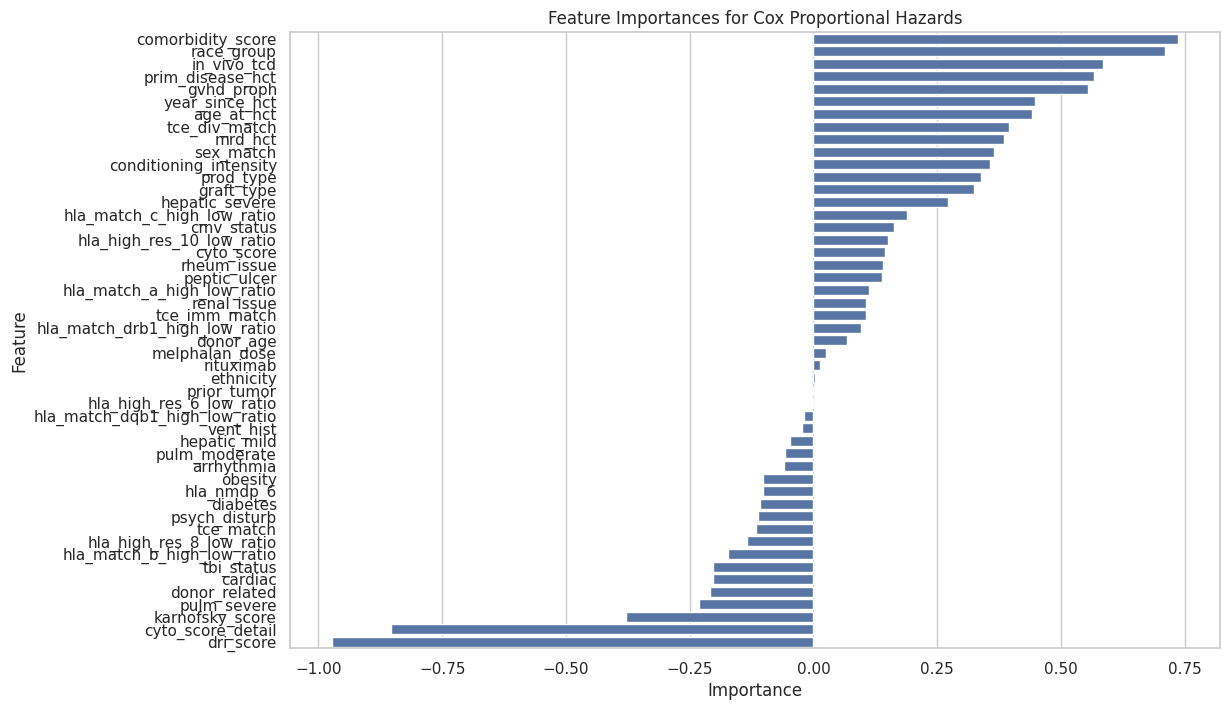

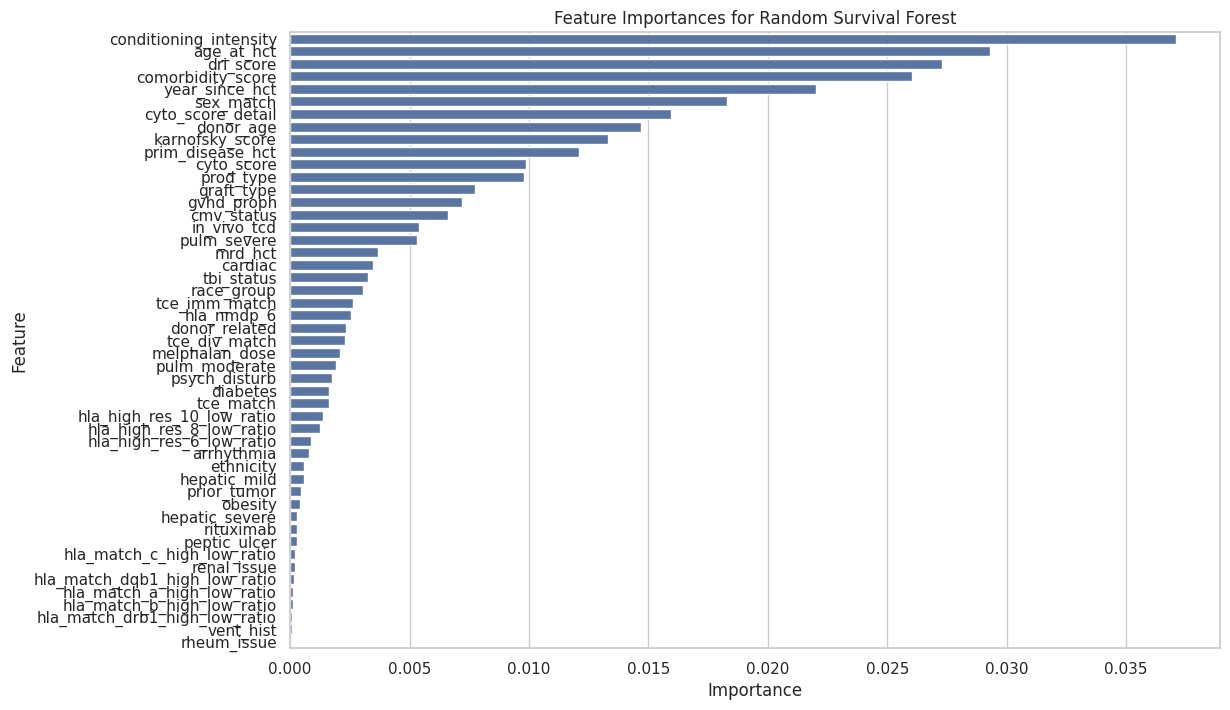

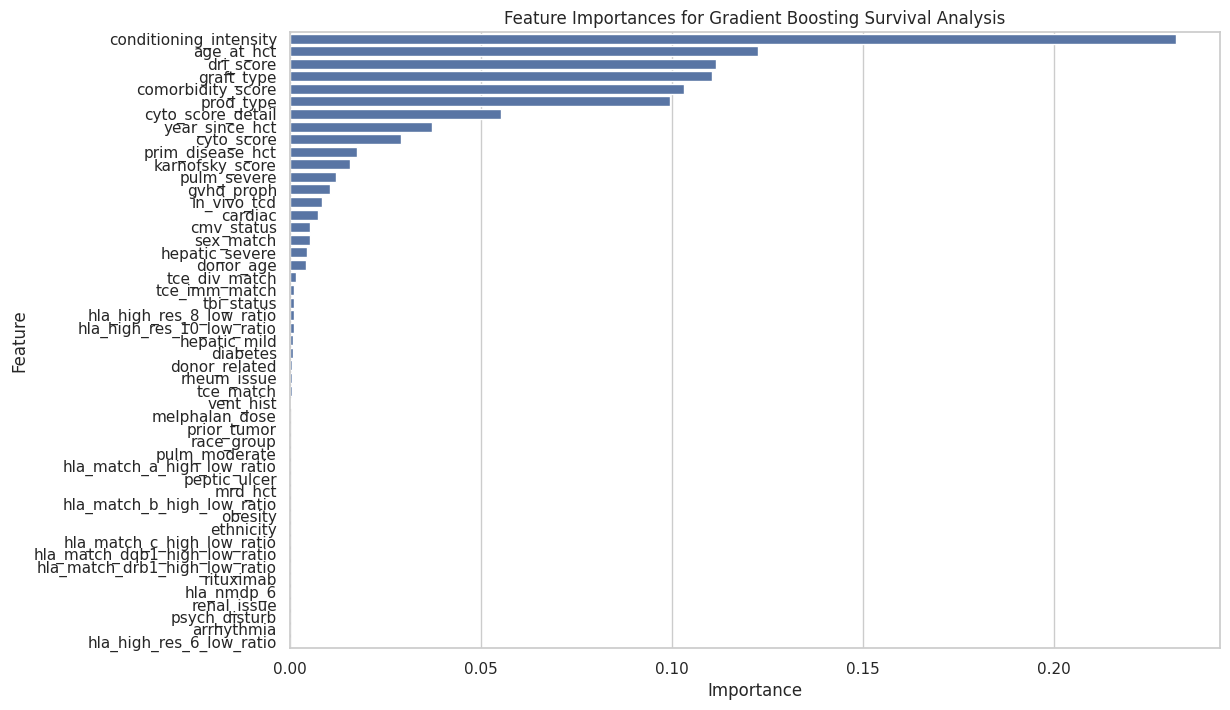

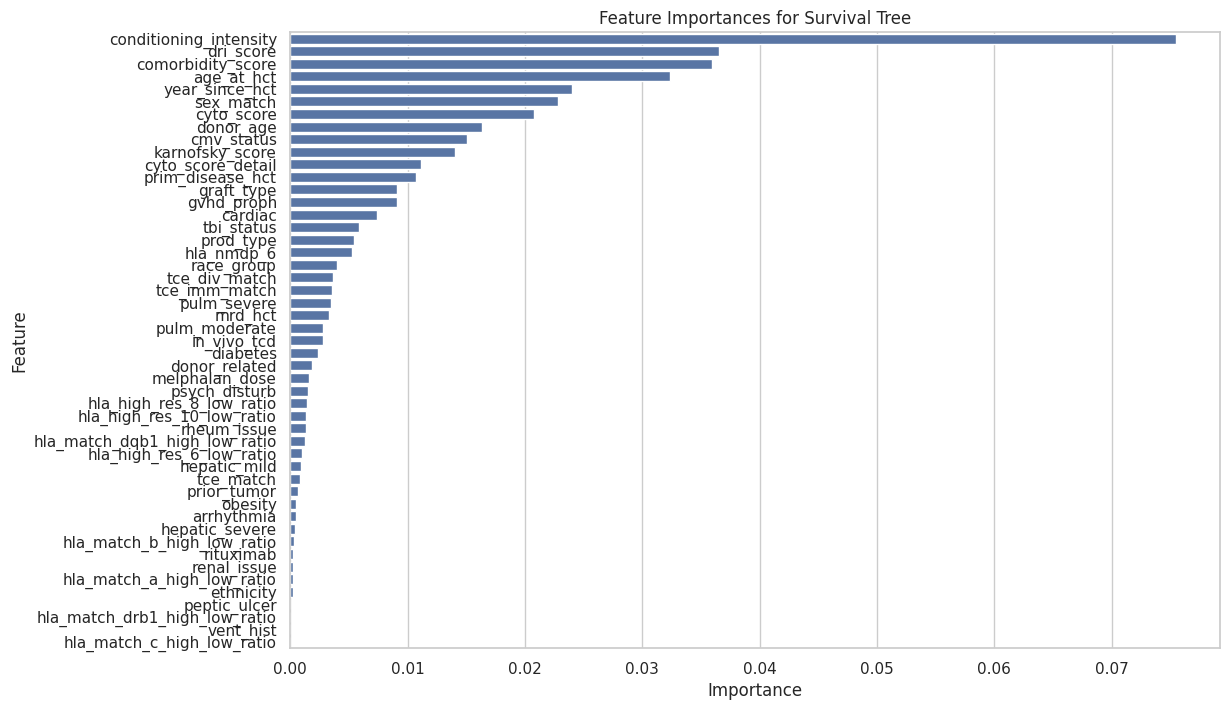

In [82]:
feature_importances = {
    "cox": pd.DataFrame({"Feature": df_x_train.columns, "Importance": models["cox"]["model"].coef_})
            .sort_values(by="Importance", ascending=False),
    "rsf": rsf_importance_df.rename(columns={"importances_mean": "Importance"})
            .reset_index().rename(columns={"index": "Feature"}),
    "gbsa": pd.DataFrame({"Feature": df_x_train.columns, "Importance": models["gbsa"]["model"].feature_importances_})
            .sort_values(by="Importance", ascending=False),
    "st": st_importance_df.rename(columns={"importances_mean": "Importance"})
            .reset_index().rename(columns={"index": "Feature"}),
}

def plot_feature_importances(model, feature_importances):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title(f'Feature Importances for {models[model]["name"]}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

for model, importances in feature_importances.items():
    plot_feature_importances(model=model, feature_importances=importances)

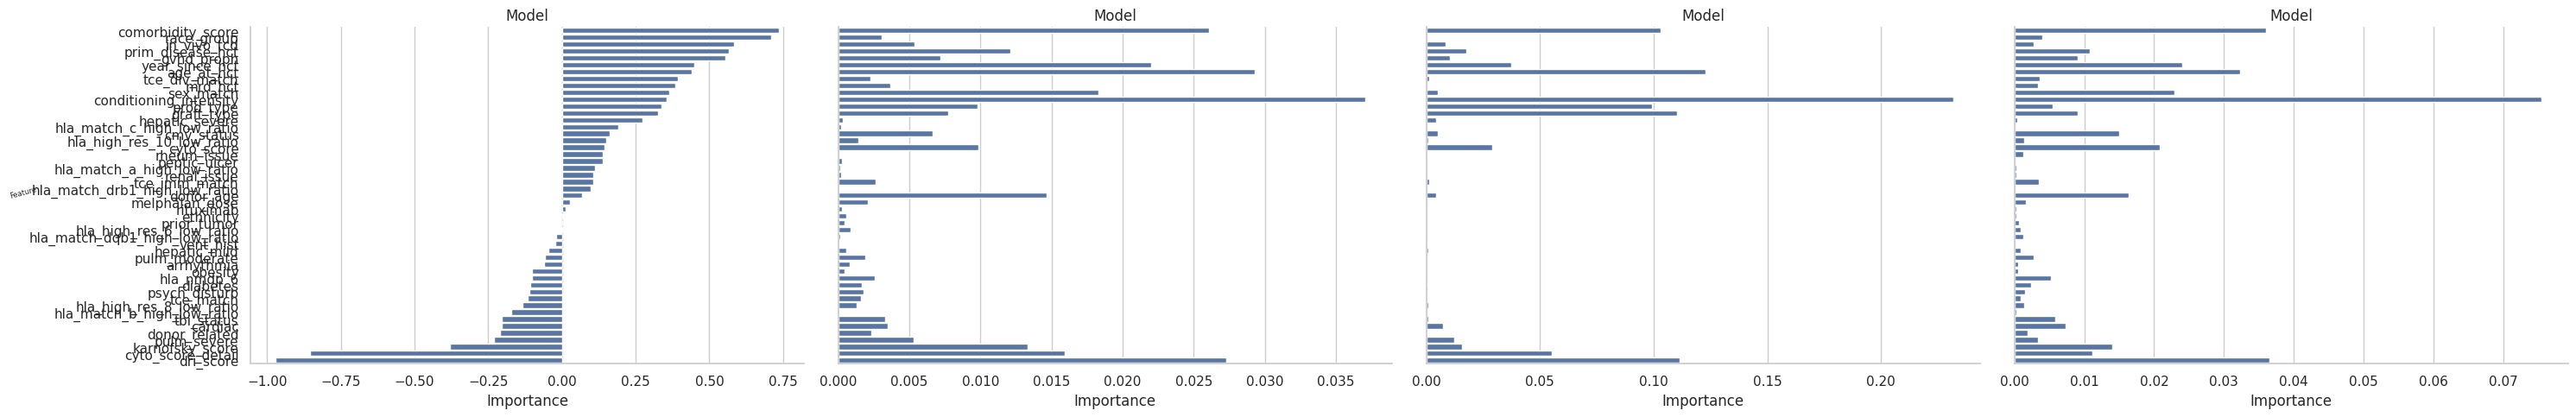

In [84]:
all_importances = pd.concat([
    feature_importances['cox'].assign(Model='Cox'),
    feature_importances['rsf'].assign(Model='Random Survival Forest'),
    feature_importances['gbsa'].assign(Model='Gradient Boosting Survival Analysis'),
    feature_importances['st'].assign(Model='Survival Tree')
])


g = sns.FacetGrid(all_importances, col="Model", sharex=False, sharey=True, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="Importance", y="Feature", order=all_importances["Feature"].unique())
g.set_axis_labels("Importance", "Feature")
g.set_ylabels(rotation = 15, fontsize = 6)
g.set_titles(col_template="Model")

## **Plot of C-Index Scores for each model**

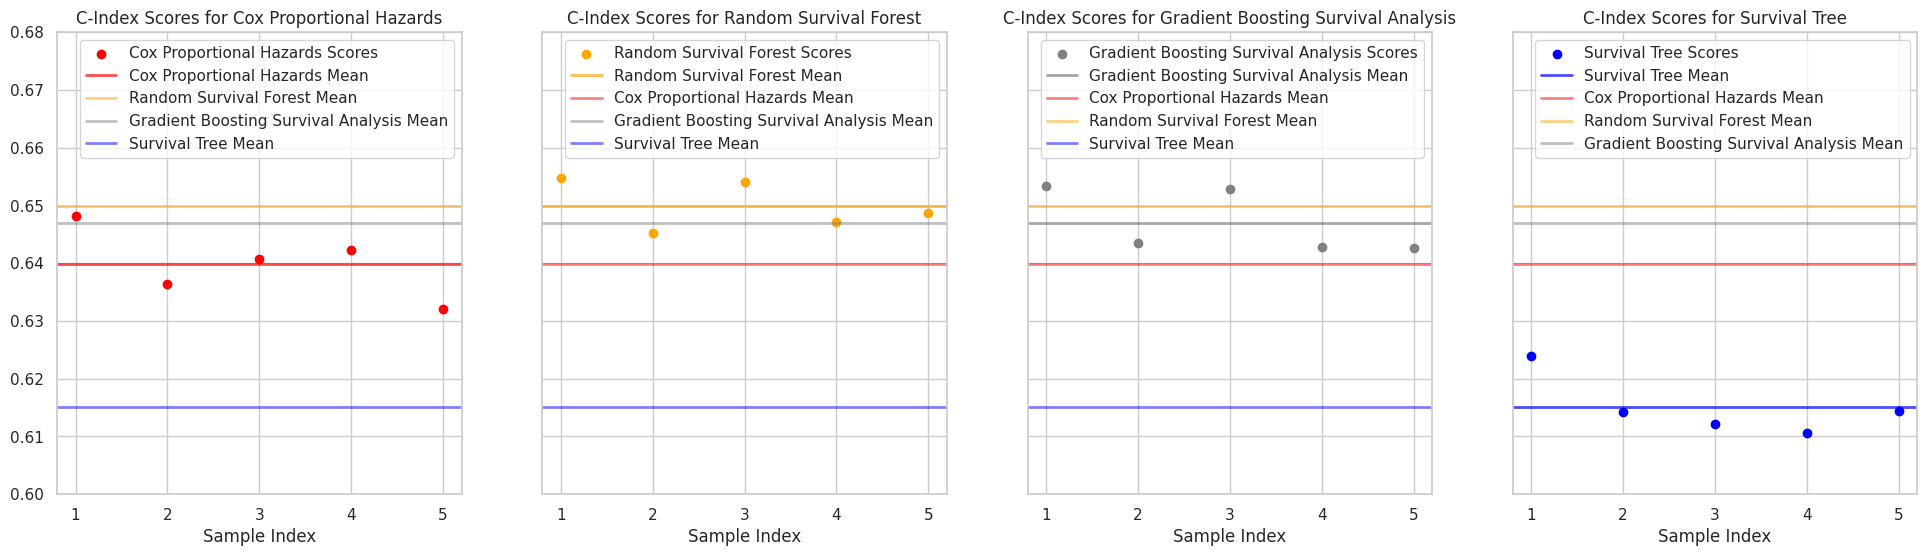

In [99]:
def plot_c_index_scores_subplots(c_index_scores_models):
    num_models = len(c_index_scores_models)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
    color_map = ['red', 'orange', 'grey', 'blue']

    for i, (model_name, model_data) in enumerate(c_index_scores_models.items()):
        ax = axes[i] if num_models > 1 else axes
        x_positions = np.linspace(1, 5, len(model_data['c_scores']))
        color = color_map[i]
        ax.scatter(x_positions, model_data['c_scores'], color = color, label = f'{model_name} Scores')
        ax.axhline(y = model_data['c_mean'], linestyle = '-', linewidth = 2, color = color, alpha = 0.7, label = f'{model_name} Mean')
        for j, (other_model, other_data) in enumerate(c_index_scores_models.items()):
            if other_model != model_name:
                ax.axhline(y = other_data['c_mean'], linestyle = '-', linewidth = 2, color = color_map[j], alpha = 0.5, label = f'{other_model} Mean')

        ax.set_title(f'C-Index Scores for {model_name}')
        ax.set_xlabel('Sample Index')
        ax.set_ylim(0.600, 0.680)
        ax.legend()

plot_c_index_scores_subplots(c_index_scores_models)


## **Comparison of original and predicted efs_time**

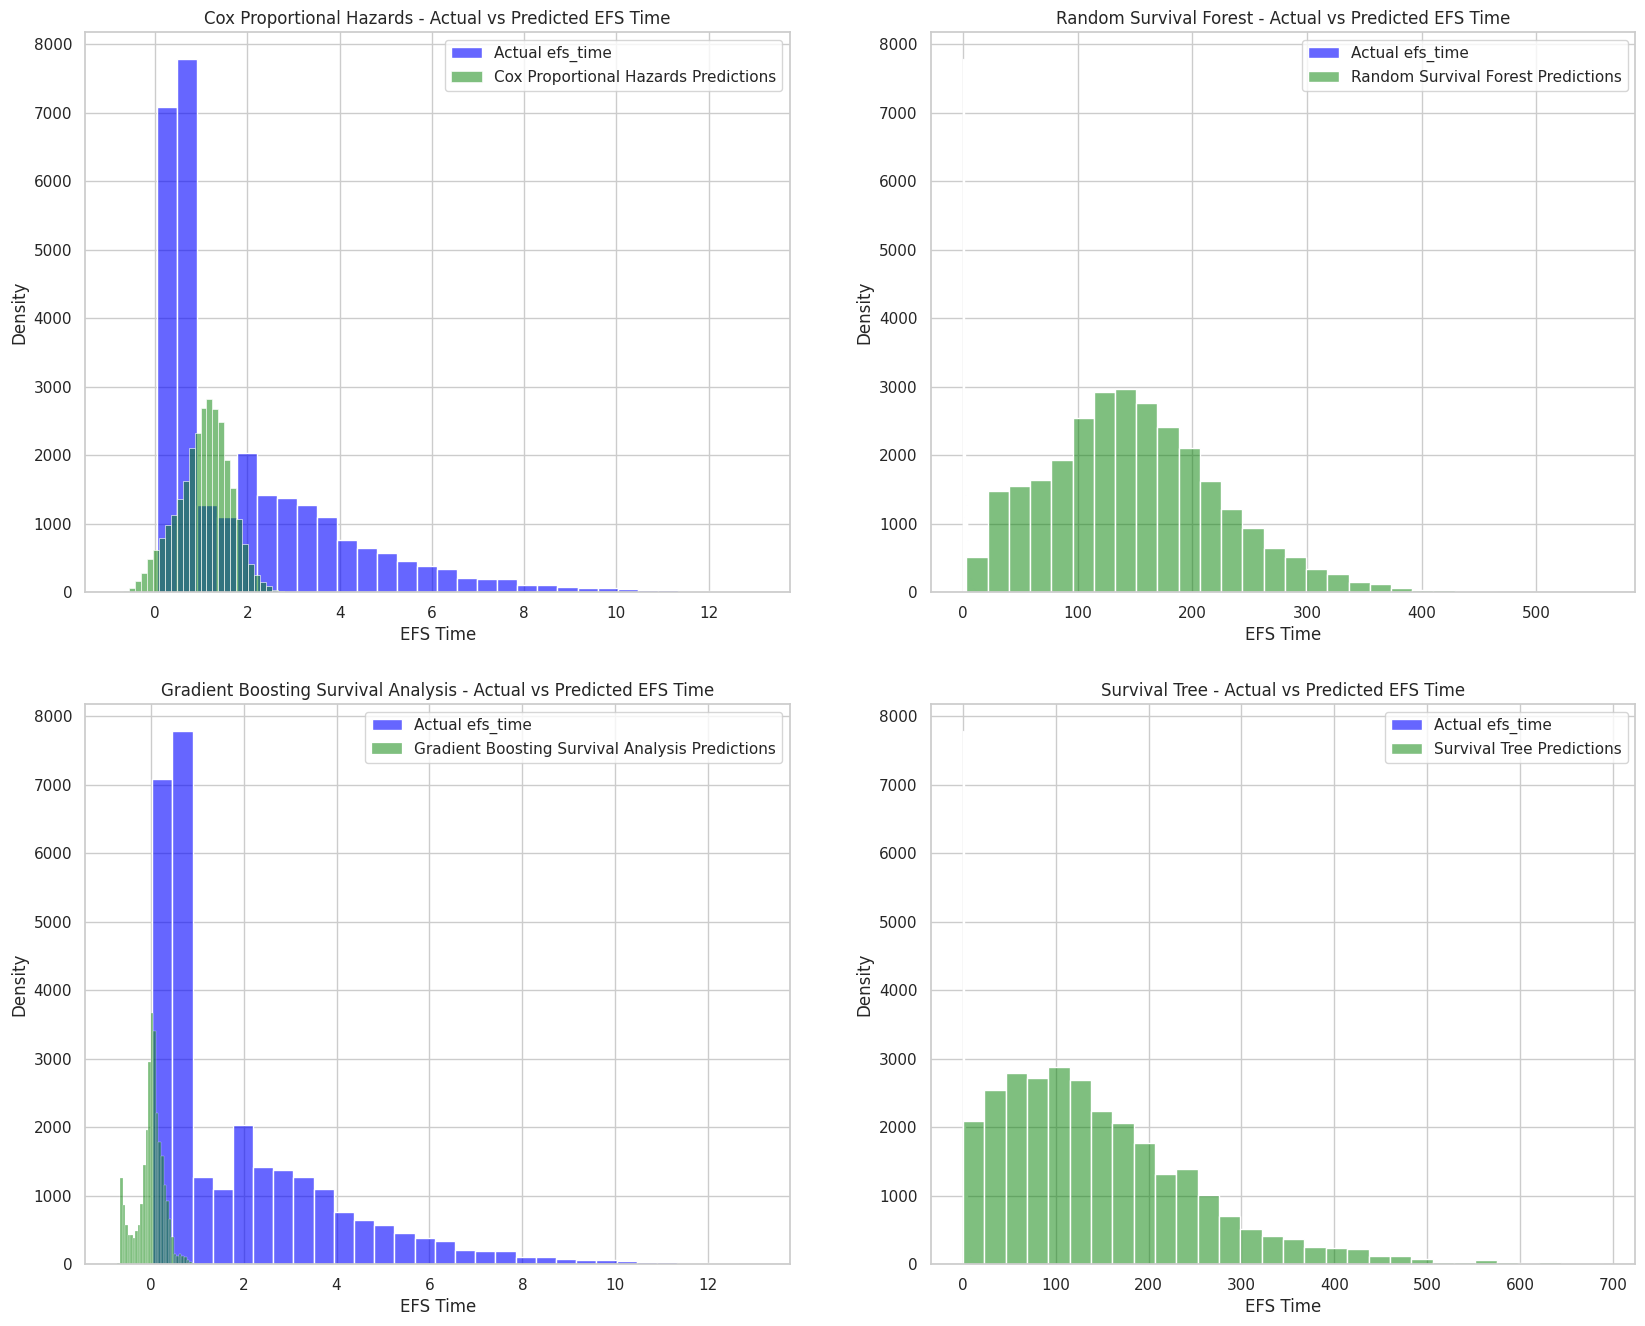

In [100]:
def plot_efs_comparison_subplots(df_y_train_efs, models, rows=2, cols=2):
    num_models = len(models)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.flatten()

    for i, (key, val) in enumerate(models.items()):
        if i >= len(axes):
            break

        model_name = val["name"]
        ax = axes[i]

        sns.histplot(df_y_train_efs["efs_time"], bins = 30, color = "blue", label = "Actual efs_time", alpha = 0.6, ax=ax)
        sns.histplot(df_y_train_efs[f"{model_name}_pred"], bins = 30, color = "green", label = f"{model_name} Predictions", alpha = 0.5, ax = ax)

        ax.set_xlabel("EFS Time")
        ax.set_ylabel("Density")
        ax.set_title(f"{model_name} - Actual vs Predicted EFS Time")
        ax.legend()

plot_efs_comparison_subplots(df_y_train_efs = df_y_train, models = models)

Even though Concordance Indices were similar in terms of power prediction, predicted efs times given in years clearly show us that Random Survival Forest and Survival Tree models gives ridiculous outputs. Gradient Boosting Survival Analysis does better, however negative values of efs time were returned which could be interpreted as death of a patient (this is my assumption as I don't really know if we can clearly say that). Therefore we should no longer consider them as valid models at all. The best model is Cox Proportional Hazard.

## **Test sample preparation**

In [88]:
# creating copy of test dataset
df_x_test = x_test.copy()

# extracting ID column
df_x_test_patient_ID = df_x_test["ID"]
df_x_test.drop(columns= "ID", inplace=True)

# variables separation
test_vars_separated = separate_variables(df = df_x_test)
df_test_hla_ratios = df_hla_ratios(df_num_hla = df_x_test[test_vars_separated["num_hla"]])

test_vars_separated["num_hla"] = df_test_hla_ratios
test_vars_separated["num_non_hla"] = df_x_test[test_vars_separated["num_non_hla"]]
test_vars_separated["cat"] = df_x_test[test_vars_separated["cat"]]

# clean numerical dataframe
df_test_cleaned_num = pd.concat([test_vars_separated["num_hla"], test_vars_separated["num_non_hla"]], axis=1)

# clean categorical dataframe
replace_with_unknown(df_cat = test_vars_separated["cat"])
df_test_cleaned_cat = apply_categorical_mapping(df_cat = test_vars_separated["cat"])

# applying mappings
df_test_cleaned_num = apply_mode_mapping(df_num = df_test_cleaned_num)
df_test_cleaned_cat = apply_weight_mapping(df_cat = df_test_cleaned_cat)

# clean dataset ready for predictions
df_test_cleaned = pd.concat([df_test_cleaned_num, df_test_cleaned_cat], axis=1)
df_test_cleaned = replace_year_hct(df_cleaned = df_test_cleaned)
df_test_cleaned = apply_scaler(df_cleaned = df_test_cleaned)
df_test_cleaned = apply_donor_age(df_cleaned = df_test_cleaned, imputer = "Iterative Imputer")

predictions_df = pd.DataFrame(index=df_x_test_patient_ID)

for key, value in models.items():
    model = value["model"]
    name = value["name"]
    predictions = model.predict(df_test_cleaned)
    predictions_df[name] = predictions.round(2)

Values represent predicted efs_time for patient in years.

In [89]:
predictions_df

Cox Proportional Hazards  Random Survival Forest  \
ID                                                        
28800                      0.49                   51.56   
28801                      2.74                  285.64   
28802                      0.72                   38.78   

       Gradient Boosting Survival Analysis  Survival Tree  
ID                                                         
28800                                -0.65          40.30  
28801                                 0.42         307.71  
28802                                -0.46           6.55

Propositions of improvements:

1.   Searching for better model's parameters by using Grid Search CV,
2.   Testing other models,
3.   Dropping variables of high Cramer's V value for lowering dimensionality of the dataset,
4.   Implementing Principal Component Analysis for HLA variables that show stron association collinearity between each other that would further lower dimensionality of dataset by losing least variance explanatory power,
5.   Better feature engineering.

